In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1=pd.read_csv('pre.csv')

In [ ]:
import pandas as pd

# Rename column
df1.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)

# Convert to datetime type
df1['datetime'] = pd.to_datetime(df1['datetime'], errors='coerce')  # invalid parsing becomes NaT

# Extract numeric features from datetime
df1['year'] = df1['datetime'].dt.year
df1['month'] = df1['datetime'].dt.month
df1['day'] = df1['datetime'].dt.day
df1['weekday'] = df1['datetime'].dt.weekday
df1['hour'] = df1['datetime'].dt.hour
df1['minute'] = df1['datetime'].dt.minute
df1['second'] = df1['datetime'].dt.second

# Optional: drop the original datetime if you only want numeric features
df1.drop(columns=['datetime'], inplace=True)

# Check the new columns
df1.head()

use       gen  Dishwasher  Home_office    Fridge  Wine_cellar  \
0 -0.137035 -0.010953    0.000024     0.044237  0.005992     2.489737   
1 -0.342203 -0.010953    0.000012     0.044460  0.005796     2.489017   
2 -0.372376 -0.010539    0.000012     0.044425  0.005815     2.490457   
3 -0.327211 -0.010953    0.000012     0.044477  0.005757     2.501620   
4 -0.196484 -0.010953    0.000012     0.044460  0.134046     2.510263   

   Garage_door      Barn      Well  Microwave  ...  precipProbability  \
0     0.012091  0.004518  0.000612   0.518518  ...                0.0   
1     0.011815  0.004522  0.000623   0.518518  ...                0.0   
2     0.011877  0.004525  0.000612   0.518518  ...                0.0   
3     0.011815  0.004527  0.000623   0.518518  ...                0.0   
4     0.011846  0.004525  0.000612   0.518518  ...                0.0   

    kitchen   Furnace  year  month  day  weekday  hour  minute  second  
0  0.000324  1.805045  2016      1    1        4     5       0      58  
1  0.000368  0.528579  2016      1    1        4     5       1      58  
2  0.000360  0.284667  2016      1    1        4     5       2      58  
3  0.000368  0.643141  2016      1    1        4     5       3      58  
4  0.000221  0.662276  2016      1    1        4     5       4      58  

[5 rows x 33 columns]

In [ ]:
# Features and target
X_num = df1.drop(columns=['use'])
y = df1['use']

print(X_num.dtypes)  # check all columns are numeric

gen                    float64
Dishwasher             float64
Home_office            float64
Fridge                 float64
Wine_cellar            float64
Garage_door            float64
Barn                   float64
Well                   float64
Microwave              float64
Living_room            float64
temperature            float64
icon                   float64
humidity               float64
visibility             float64
summary                float64
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover             float64
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
kitchen                float64
Furnace                float64
year                     int32
month                    int32
day                      int32
weekday                  int32
hour                     int32
minute                   int32
second                   int32
dtype: o

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

In [ ]:
# Recreate datetime column from extracted features
df1['datetime'] = pd.to_datetime(dict(
    year=df1['year'],
    month=df1['month'],
    day=df1['day'],
    hour=df1['hour'],
    minute=df1['minute'],
    second=df1['second']
), errors='coerce')

In [ ]:
# @title
# ============================================================
# RANDOM FOREST REGRESSOR FOR ENERGY ANOMALY DETECTION (FULL DATA + RESIDUALS)
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================
# TRAIN-TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)

# ============================================================
# TRAIN RANDOM FOREST ON ALL TRAINING DATA
# ============================================================
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ============================================================
# PREDICT ON TEST DATA
# ============================================================
y_pred = rf.predict(X_test)

# ============================================================
# COMPUTE METRICS
# ============================================================
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # safe division

print("\n===== RANDOM FOREST PERFORMANCE =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# COMPUTE RESIDUALS FOR ANOMALY DETECTION
# ============================================================
residuals = y_test - y_pred
abs_residuals = np.abs(residuals)

# Combine with test data for easier downstream analysis
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals,
    'AbsResidual': abs_residuals
})

# ============================================================
# SAVE MODEL AND RESULTS
# ============================================================
joblib.dump(rf, "random_forest_full_model.pkl")
results.to_csv("rf_residuals.csv", index=False)

print("\n✅ Model saved as 'random_forest_full_model.pkl'")
print("✅ Residuals saved as 'rf_residuals.csv'")

# ============================================================
# (Optional) FEATURE IMPORTANCE
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette="viridis")
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()


In [ ]:
# @title
# ============================================================
# RESIDUAL-BASED ANOMALY DETECTION AND PLOTTING
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load residuals if running separately
# results = pd.read_csv("rf_residuals.csv")

# Moving Average window size
window = 50  # Adjust as per your data’s time resolution
results['MA_Residual'] = results['AbsResidual'].rolling(window=window, center=True).mean()

# Compute adaptive threshold using MAD (Median Absolute Deviation)
mad = np.median(np.abs(results['AbsResidual'] - np.median(results['AbsResidual'])))
threshold = np.median(results['AbsResidual']) + 3 * mad

# Flag anomalies
results['Anomaly'] = results['AbsResidual'] > threshold

# ============================================================
# PLOT RESIDUALS, MOVING AVERAGE, AND ANOMALIES
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(results.index, results['AbsResidual'], label='Absolute Residual', linewidth=1, alpha=0.6)
plt.plot(results.index, results['MA_Residual'], label=f'Moving Average ({window})', linewidth=2, color='orange')
plt.axhline(threshold, color='red', linestyle='--', linewidth=1.5, label='Anomaly Threshold')

# Highlight anomalies
plt.scatter(
    results.index[results['Anomaly']],
    results['AbsResidual'][results['Anomaly']],
    color='red', s=30, label='Anomalies', zorder=3
)

plt.title("Residual-Based Anomaly Detection (Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# PRINT SUMMARY
# ============================================================
print(f"Moving Average Window: {window}")
print(f"MAD Threshold: {threshold:.4f}")
print(f"Detected Anomalies: {results['Anomaly'].sum()} out of {len(results)} samples")



===== RANDOM FOREST PERFORMANCE =====
MAE   : 0.0753
MSE   : 0.0276
RMSE  : 0.1661
R2    : 0.9722
MAPE% : 91.6563

✅ Model saved as 'random_forest_full_model.pkl'
✅ Residuals saved as 'rf_residuals.csv'


/tmp/ipython-input-411133213.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette="viridis")


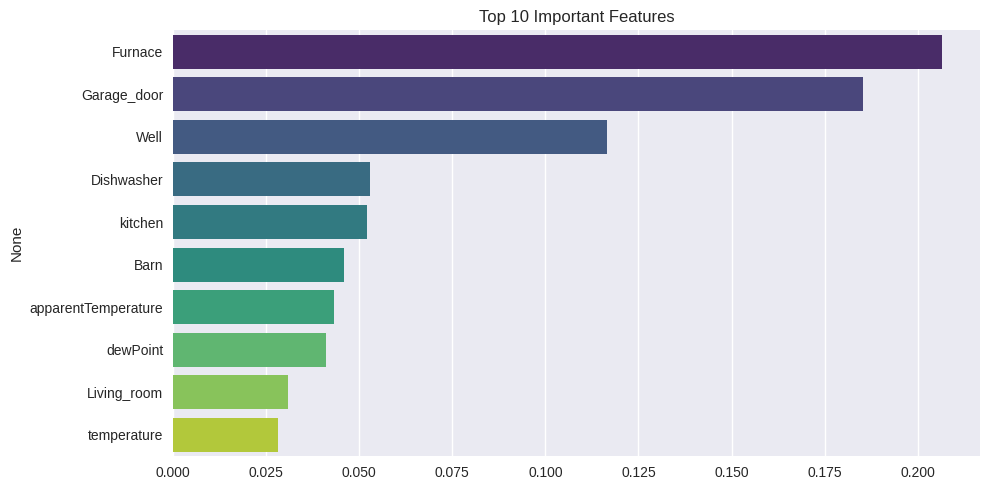

In [ ]:
# ============================================================
# RANDOM FOREST REGRESSOR FOR ENERGY ANOMALY DETECTION (FULL DATA + RESIDUALS)
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# ============================================================
# TRAIN-TEST SPLIT (KEEP DATETIME ALIGNMENT)
# ============================================================

# Ensure your original dataframe (df1) has a datetime column
assert 'datetime' in df1.columns, "Your source dataframe 'df1' must include a 'datetime' column."

# Keep the datetime column aligned with y
datetime_series = df1['datetime'].iloc[-len(y):].reset_index(drop=True)

# Split with same random_state but keep indices for datetime alignment
X_train, X_test, y_train, y_test, dt_train, dt_test = train_test_split(
    X_num, y, datetime_series, test_size=0.3, random_state=42
)


# ============================================================
# TRAIN RANDOM FOREST ON ALL TRAINING DATA
# ============================================================
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ============================================================
# PREDICT ON TEST DATA
# ============================================================
y_pred = rf.predict(X_test)

# ============================================================
# COMPUTE METRICS
# ============================================================
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # safe division

print("\n===== RANDOM FOREST PERFORMANCE =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# COMPUTE RESIDUALS FOR ANOMALY DETECTION
# ============================================================
residuals = y_test - y_pred
abs_residuals = np.abs(residuals)

# Combine with test data for easier downstream analysis
results = pd.DataFrame({
    'datetime': dt_test.values,  # maintain time information
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': residuals,
    'AbsResidual': abs_residuals
})


# ============================================================
# SAVE MODEL AND RESULTS
# ============================================================
joblib.dump(rf, "random_forest_full_model.pkl")
results.to_csv("rf_residuals.csv", index=False)

print("\n✅ Model saved as 'random_forest_full_model.pkl'")
print("✅ Residuals saved as 'rf_residuals.csv'")

# ============================================================
# (Optional) FEATURE IMPORTANCE
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette="viridis")
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()


In [ ]:
# @title
# ============================================================
# RESIDUAL-BASED ANOMALY DETECTION AND PLOTTING
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load residuals if running separately
# results = pd.read_csv("rf_residuals.csv")

# Moving Average window size
window = 50  # Adjust as per your data’s time resolution
results['MA_Residual'] = results['AbsResidual'].rolling(window=window, center=True).mean()

# Compute adaptive threshold using MAD (Median Absolute Deviation)
mad = np.median(np.abs(results['AbsResidual'] - np.median(results['AbsResidual'])))
threshold = np.median(results['AbsResidual']) + 3 * mad

# Flag anomalies
results['Anomaly'] = results['AbsResidual'] > threshold

# ============================================================
# PLOT RESIDUALS, MOVING AVERAGE, AND ANOMALIES
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(results['datetime'], results['AbsResidual'], label='Absolute Residual', linewidth=1, alpha=0.6)
plt.plot(results.index, results['MA_Residual'], label=f'Moving Average ({window})', linewidth=2, color='orange')
plt.axhline(threshold, color='red', linestyle='--', linewidth=1.5, label='Anomaly Threshold')

# Highlight anomalies
plt.scatter(
    results.index[results['Anomaly']],
    results['AbsResidual'][results['Anomaly']],
    color='red', s=30, label='Anomalies', zorder=3
)

plt.title("Residual-Based Anomaly Detection (Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# PRINT SUMMARY
# ============================================================
print(f"Moving Average Window: {window}")
print(f"MAD Threshold: {threshold:.4f}")
print(f"Detected Anomalies: {results['Anomaly'].sum()} out of {len(results)} samples")


Epoch 1/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 0.3215 - val_loss: 0.0907
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - loss: 0.1408 - val_loss: 0.0854
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - loss: 0.1390 - val_loss: 0.0833
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 97s 103ms/step - loss: 0.1352 - val_loss: 0.0798
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - loss: 0.1319 - val_loss: 0.0785
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - loss: 0.1321 - val_loss: 0.0794
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - loss: 0.1267 - val_loss: 0.0766
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 126s 85ms/step - loss: 0.1220 - val_loss: 0.0756
Epoch 9/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - loss: 0.1199 - val_loss: 0.0751
Epoch 10/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - loss: 0.1219 - val_loss: 0.0751

===== LSTM PERFORMANCE (Full Data) =====
MAE   : 0.1238
MSE   : 0.1118
RMSE  : 0.3344
R2    : 0.8882
MAPE% : 165.37

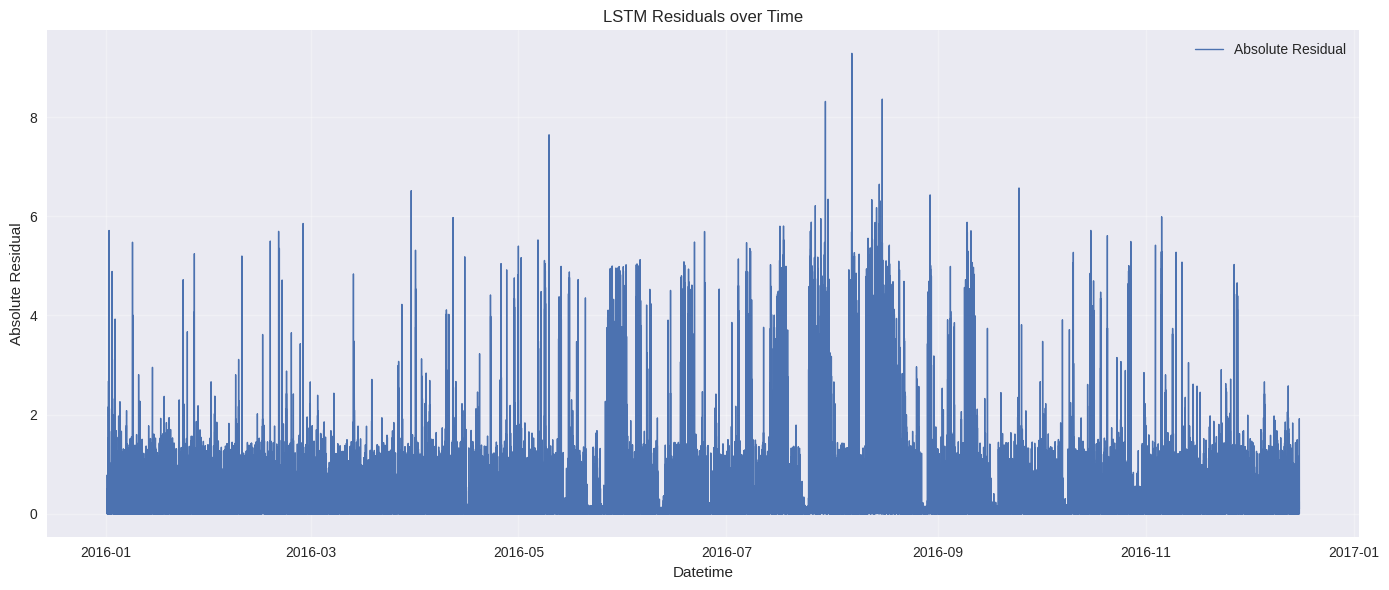

0

In [ ]:
# ============================================================
# LSTM FINAL MODEL FOR RESIDUAL GENERATION (seq_len=24, units=64, activation='tanh')
# ============================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os, json, gc

# ============================================================
# DATA PREPARATION
# ============================================================
data = df1['use'].astype('float32').values
seq_len = 24  # from your final tuning

# Create sequences
X = np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype='float32')
y = data[seq_len:].astype('float32')
X = X.reshape((X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

# ============================================================
# FINAL MODEL CONFIGURATION
# ============================================================
lstm_units = 64
activation = 'tanh'
batch_size = 512
epochs = 10
val_split = 0.2

model = Sequential([
    Input(shape=(seq_len, 1)),
    LSTM(lstm_units, activation=activation),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ============================================================
# TRAIN MODEL
# ============================================================
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X, y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[es],
    verbose=1
)

# ============================================================
# PREDICT AND COMPUTE RESIDUALS
# ============================================================
y_pred = model.predict(X, batch_size=batch_size, verbose=0).flatten()

residuals = y - y_pred
abs_residuals = np.abs(residuals)

# Align datetime with shifted target y (sequence removes first seq_len samples)
assert "datetime" in df1.columns, "Your dataframe must include a 'datetime' column."

datetime_aligned = df1["datetime"].iloc[seq_len:].reset_index(drop=True)

results = pd.DataFrame({
    "datetime": datetime_aligned,
    "Actual": y,
    "Predicted": y_pred,
    "Residual": residuals,
    "AbsResidual": abs_residuals
})


# ============================================================
# METRICS
# ============================================================
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / (y + 1e-8))) * 100

print("\n===== LSTM PERFORMANCE (Full Data) =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# SAVE RESULTS
# ============================================================
os.makedirs("lstm_final_results", exist_ok=True)
model.save("lstm_final_results/lstm_final_model.keras")
results.to_csv("lstm_final_results/lstm_residuals.csv", index=False)

metrics = {
    "MAE": float(mae),
    "MSE": float(mse),
    "RMSE": float(rmse),
    "R2": float(r2),
    "MAPE (%)": float(mape)
}
with open("lstm_final_results/lstm_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\n✅ Model and residuals saved to 'lstm_final_results/'")

# ============================================================
# OPTIONAL: RESIDUAL PLOT
# ============================================================
plt.figure(figsize=(14,6))
plt.title("LSTM Residuals over Time")


plt.plot(results["datetime"], results["AbsResidual"], label="Absolute Residual", linewidth=1)
plt.xlabel("Datetime")

plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tf.keras.backend.clear_session()
gc.collect()


In [ ]:
# ============================================================
# HYBRID RANDOM FOREST + LSTM — AUTOMATIC WEIGHT TUNING + FULL ANOMALY PIPELINE
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


# ------------------------------------------------------------
# STEP 1 — LOAD AND ALIGN RF + LSTM RESIDUALS
# ------------------------------------------------------------
def align_rf_lstm():
    df_rf = pd.read_csv("rf_residuals.csv")
    df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

    assert "datetime" in df_rf.columns
    assert "datetime" in df_lstm.columns

    df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
    df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

    df_rf = df_rf.sort_values("datetime")
    df_lstm = df_lstm.sort_values("datetime")

    df_merged = pd.merge_asof(
        df_rf,
        df_lstm,
        on="datetime",
        suffixes=("_RF", "_LSTM"),
        direction="nearest",
        tolerance=pd.Timedelta("1min")
    )

    df_merged.dropna(subset=["Predicted_RF", "Predicted_LSTM"], inplace=True)

    print(f"Aligned on {len(df_merged)} timestamps\n")

    return df_merged


# ------------------------------------------------------------
# STEP 2 — AUTOMATIC RF–LSTM WEIGHT TUNING
# ------------------------------------------------------------
def tune_hybrid_weights(df_merged):
    y_true  = df_merged["Actual_LSTM"].values
    rf_pred = df_merged["Predicted_RF"].values
    lstm_pred = df_merged["Predicted_LSTM"].values

    best = {"w_rf": None, "w_lstm": None, "rmse": np.inf}

    for w_rf in np.linspace(0, 1, 21):      # 0.00, 0.05, 0.10, ... 1.00
        w_lstm = 1 - w_rf

        hybrid_pred = w_rf * rf_pred + w_lstm * lstm_pred

        # FIXED: sklearn version without squared=False
        mse = mean_squared_error(y_true, hybrid_pred)
        rmse = np.sqrt(mse)

        if rmse < best["rmse"]:
            best = {"w_rf": w_rf, "w_lstm": w_lstm, "rmse": rmse}

    print(f"Best RF–LSTM weights → RF={best['w_rf']:.2f}  LSTM={best['w_lstm']:.2f}  RMSE={best['rmse']:.6f}\n")

    return best["w_rf"], best["w_lstm"]



# ------------------------------------------------------------
# STEP 3 — HYBRID FUSION USING AUTOMATIC WEIGHTS
# ------------------------------------------------------------
def hybrid_fusion(df_merged, w_rf, w_lstm):
    actual = df_merged["Actual_LSTM"].values

    pred_hybrid = (w_rf * df_merged["Predicted_RF"].values) + \
                  (w_lstm * df_merged["Predicted_LSTM"].values)

    residual_hybrid = actual - pred_hybrid

    return pd.DataFrame({
        "datetime": df_merged["datetime"],
        "Actual": actual,
        "Pred_Hybrid": pred_hybrid,
        "Residual_Hybrid": residual_hybrid,
        "AbsResidual_Hybrid": np.abs(residual_hybrid)
    })


# ------------------------------------------------------------
# STEP 4 — METRICS & EVENT GROUPING
# ------------------------------------------------------------
def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred)/(y_true+1e-8))) * 100
    }


def group_events(df, label_col="Anomaly_Label"):
    df = df.reset_index(drop=True)
    mask = df[label_col] == 1
    new_event = mask & (~mask.shift(fill_value=False))
    df["Anomaly_Event"] = new_event.cumsum() * mask

    events = []
    for eid, grp in df[df["Anomaly_Event"] > 0].groupby("Anomaly_Event"):
        events.append({
            "Event_ID": int(eid),
            "Start": str(grp["datetime"].iloc[0]),
            "End": str(grp["datetime"].iloc[-1]),
            "Duration": str(grp["datetime"].iloc[-1] - grp["datetime"].iloc[0])
        })
    return df, events


# ------------------------------------------------------------
# ANOMALY DETECTORS (MA, IF, OCSVM)
# ------------------------------------------------------------
def hybrid_ma_detector(df_hybrid):
    print("\n===== MOVING AVERAGE DETECTOR =====")
    df = df_hybrid.copy()

    df["MA"] = df["AbsResidual_Hybrid"].rolling(window=6, center=True).mean()
    df["Anomaly_Score"] = (df["AbsResidual_Hybrid"] - df["MA"]).clip(lower=0)
    df["Anomaly_Score_Norm"] = df["Anomaly_Score"] / (df["Anomaly_Score"].max() + 1e-8)
    df["Anomaly_Label"] = (df["Anomaly_Score_Norm"] > 0).astype(int)

    df, events = group_events(df)
    print(f"MA anomalies: {df['Anomaly_Label'].sum()}  |  Events: {len(events)}")

    # FIX: Create output directory
    os.makedirs("hybrid_unsupervised_MA", exist_ok=True)

    # Save results
    df.to_csv("hybrid_unsupervised_MA/hybrid_unsupervised_MA_results.csv", index=False)
    json.dump(events, open("hybrid_unsupervised_MA/hybrid_unsupervised_MA_events.json", "w"), indent=4)

    print("Saved MA results.")
    return df


def hybrid_if_detector(df_hybrid):
    print("\n===== ISOLATION FOREST DETECTOR =====")
    df = df_hybrid.copy()

    X = df[["AbsResidual_Hybrid"]].values
    iso = IsolationForest(
        n_estimators=50,
        contamination=0.01,
        max_samples="auto",
        random_state=42,
        n_jobs=-1
    ).fit(X)

    df["Anomaly_Score"] = -iso.decision_function(X)
    df["Anomaly_Label"] = iso.predict(X)
    df["Anomaly_Label"] = df["Anomaly_Label"].map({1: 0, -1: 1})

    df, events = group_events(df)
    print(f"IF anomalies: {df['Anomaly_Label'].sum()}  |  Events: {len(events)}")

    # FIX: Create folder before saving
    os.makedirs("hybrid_results_isolation_forest", exist_ok=True)

    df.to_csv("hybrid_results_isolation_forest/hybrid_iforest_results.csv", index=False)
    json.dump(events, open("hybrid_results_isolation_forest/hybrid_iforest_events.json", "w"), indent=4)

    print("Saved IF results.\n")
    return df


def hybrid_ocsvm_detector(df_hybrid):
    print("\n===== ONE-CLASS SVM DETECTOR =====")
    df = df_hybrid.copy()

    X = df[["AbsResidual_Hybrid"]].values
    X_scaled = StandardScaler().fit_transform(X)

    ocsvm = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale").fit(X_scaled)

    decision_scores = ocsvm.decision_function(X_scaled)
    df["Anomaly_Score"] = -decision_scores

    preds = pd.Series(ocsvm.predict(X_scaled))
    df["Anomaly_Label"] = preds.map({1: 0, -1: 1})

    df, events = group_events(df)
    print(f"OCSVM anomalies: {df['Anomaly_Label'].sum()}  |  Events: {len(events)}")

    # FIX: Create folder before saving
    os.makedirs("hybrid_results_oneclass_svm", exist_ok=True)

    df.to_csv("hybrid_results_oneclass_svm/hybrid_ocsvm_results.csv", index=False)
    json.dump(events, open("hybrid_results_oneclass_svm/hybrid_ocsvm_events.json", "w"), indent=4)

    print("Saved OCSVM results.\n")
    return df



# ------------------------------------------------------------
# MAIN EXECUTION
# ------------------------------------------------------------
if __name__ == "__main__":

    df_merged = align_rf_lstm()

    # Automatically tune hybrid weights
    w_rf, w_lstm = tune_hybrid_weights(df_merged)

    # Generate hybrid residuals with tuned weights
    df_hybrid = hybrid_fusion(df_merged, w_rf, w_lstm)

    # Run detectors
    df_ma = hybrid_ma_detector(df_hybrid)
    df_if = hybrid_if_detector(df_hybrid)
    df_oc = hybrid_ocsvm_detector(df_hybrid)

    print("\n✔ Hybrid RF–LSTM fused using auto-optimized weights")
    print("✔ All anomaly detectors executed")


Aligned on 151101 timestamps

Best RF–LSTM weights → RF=0.90  LSTM=0.10  RMSE=0.163463


===== MOVING AVERAGE DETECTOR =====
MA anomalies: 65175  |  Events: 36637
Saved MA results.

===== ISOLATION FOREST DETECTOR =====
IF anomalies: 1468  |  Events: 930
Saved IF results.


===== ONE-CLASS SVM DETECTOR =====
OCSVM anomalies: 1782.0  |  Events: 1404
Saved OCSVM results.


✔ Hybrid RF–LSTM fused using auto-optimized weights
✔ All anomaly detectors executed


In [ ]:
# @title
# ============================================================
# HYBRID RANDOM FOREST + LSTM - FULL ANOMALY DETECTION PIPELINE (MA + IF + OCSVM)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# COMMON SETUP
# ------------------------------------------------------------
def align_rf_lstm():
    """Safely align RF and LSTM residuals by datetime."""
    df_rf = pd.read_csv("rf_residuals.csv")
    df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

    assert "datetime" in df_rf.columns, "RF residual file missing 'datetime'"
    assert "datetime" in df_lstm.columns, "LSTM residual file missing 'datetime'"

    df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
    df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

    df_rf = df_rf.sort_values("datetime")
    df_lstm = df_lstm.sort_values("datetime")

    df_merged = pd.merge_asof(
        df_rf,
        df_lstm,
        on="datetime",
        suffixes=("_RF", "_LSTM"),
        direction="nearest",
        tolerance=pd.Timedelta("1min")
    )
    df_merged.dropna(subset=["Predicted_RF", "Predicted_LSTM"], inplace=True)
    print(f"Aligned on {len(df_merged)} common timestamps from RF and LSTM residuals.\n")

    return df_merged


def hybrid_fusion(df_merged, w_rf=0.4, w_lstm=0.6):
    """Fuse RF + LSTM predictions and compute residuals."""
    actual = df_merged["Actual_LSTM"].values
    pred_hybrid = (w_rf * df_merged["Predicted_RF"].values) + (w_lstm * df_merged["Predicted_LSTM"].values)
    residual_hybrid = actual - pred_hybrid
    abs_residual_hybrid = np.abs(residual_hybrid)

    df_hybrid = pd.DataFrame({
        "datetime": df_merged["datetime"],
        "Actual": actual,
        "Pred_Hybrid": pred_hybrid,
        "Residual_Hybrid": residual_hybrid,
        "AbsResidual_Hybrid": abs_residual_hybrid
    })
    return df_hybrid


def compute_metrics(y_true, y_pred):
    """Compute regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return dict(MAE=mae, MSE=mse, RMSE=rmse, R2=r2, MAPE=mape)


def group_anomaly_events(df, label_col="Anomaly_Label"):
    """Group consecutive anomalies into distinct events with start/end/duration."""
    df = df.reset_index(drop=True)
    mask = df[label_col] == 1
    new_event = mask & (~mask.shift(fill_value=False))
    df["Anomaly_Event"] = new_event.cumsum() * mask

    events = []
    for eid, grp in df[df["Anomaly_Event"] > 0].groupby("Anomaly_Event"):
        start_time = grp["datetime"].iloc[0]
        end_time = grp["datetime"].iloc[-1]
        duration = end_time - start_time
        events.append({"Event_ID": int(eid), "Start": str(start_time), "End": str(end_time), "Duration": str(duration)})
    return df, events


# ------------------------------------------------------------
# 1. MOVING AVERAGE (MA) ANOMALY DETECTION
# ------------------------------------------------------------
def hybrid_ma_detector():
    print("\n========== MOVING AVERAGE DETECTOR ==========")
    df_merged = align_rf_lstm()
    df_hybrid = hybrid_fusion(df_merged)

    metrics = compute_metrics(df_hybrid["Actual"], df_hybrid["Pred_Hybrid"])
    print("===== HYBRID MODEL PERFORMANCE =====")
    for k, v in metrics.items():
        print(f"{k:6} : {v:.4f}")

    window = 6
    threshold = 0.0
    df_hybrid["MA_Residual"] = df_hybrid["AbsResidual_Hybrid"].rolling(window=window, center=True).mean()
    df_hybrid["Anomaly_Score"] = (df_hybrid["AbsResidual_Hybrid"] - df_hybrid["MA_Residual"]).clip(lower=0)
    df_hybrid["Anomaly_Score_Norm"] = df_hybrid["Anomaly_Score"] / (df_hybrid["Anomaly_Score"].max() + 1e-8)
    df_hybrid["Anomaly_Label"] = (df_hybrid["Anomaly_Score_Norm"] > threshold).astype(int)

    df_hybrid, events = group_anomaly_events(df_hybrid)
    print(f"Detected anomalies: {df_hybrid['Anomaly_Label'].sum()} | Events: {len(events)}")

    os.makedirs("hybrid_unsupervised_MA", exist_ok=True)
    df_hybrid.to_csv("hybrid_unsupervised_MA/hybrid_unsupervised_MA_results.csv", index=False)
    json.dump(events, open("hybrid_unsupervised_MA/hybrid_unsupervised_MA_events.json", "w"), indent=4)

    print("✅ MA detector results saved.\n")
    return df_hybrid


# ------------------------------------------------------------
# 2. ISOLATION FOREST (IF) ANOMALY DETECTION
# ------------------------------------------------------------
def hybrid_if_detector():
    print("\n========== ISOLATION FOREST DETECTOR ==========")
    df_merged = align_rf_lstm()
    df_hybrid = hybrid_fusion(df_merged)

    metrics = compute_metrics(df_hybrid["Actual"], df_hybrid["Pred_Hybrid"])
    print("===== HYBRID MODEL PERFORMANCE =====")
    for k, v in metrics.items():
        print(f"{k:6} : {v:.4f}")

    X_iso = df_hybrid[["AbsResidual_Hybrid"]].values
    iso = IsolationForest(
        n_estimators=50,
        contamination=0.01,
        max_samples="auto",
        random_state=42,
        n_jobs=-1
    ).fit(X_iso)

    df_hybrid["Anomaly_Score"] = -iso.decision_function(X_iso)
    df_hybrid["Anomaly_Label"] = iso.predict(X_iso).astype(int)
    df_hybrid["Anomaly_Label"] = df_hybrid["Anomaly_Label"].map({1: 0, -1: 1})

    df_hybrid, events = group_anomaly_events(df_hybrid)
    print(f"Detected anomalies: {df_hybrid['Anomaly_Label'].sum()} | Events: {len(events)}")

    os.makedirs("hybrid_results_isolation_forest", exist_ok=True)
    df_hybrid.to_csv("hybrid_results_isolation_forest/hybrid_iforest_results.csv", index=False)
    json.dump(events, open("hybrid_results_isolation_forest/hybrid_iforest_events.json", "w"), indent=4)

    print("✅ Isolation Forest detector results saved.\n")
    return df_hybrid


# ------------------------------------------------------------
# 3. ONE-CLASS SVM (OCSVM) ANOMALY DETECTION  — FIXED VERSION
# ------------------------------------------------------------
def hybrid_ocsvm_detector():
    print("\n========== ONE-CLASS SVM DETECTOR ==========")
    df_merged = align_rf_lstm()
    df_hybrid = hybrid_fusion(df_merged)

    metrics = compute_metrics(df_hybrid["Actual"], df_hybrid["Pred_Hybrid"])
    print("===== HYBRID MODEL PERFORMANCE =====")
    for k, v in metrics.items():
        print(f"{k:6} : {v:.4f}")

    # Step 4: One-Class SVM
    X_svm = df_hybrid[["AbsResidual_Hybrid"]].values
    X_scaled = StandardScaler().fit_transform(X_svm)
    ocsvm = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale").fit(X_scaled)

    decision_scores = ocsvm.decision_function(X_scaled)
    df_hybrid["Anomaly_Score"] = -decision_scores

    # FIX: convert numpy array to pandas Series before mapping
    preds = pd.Series(ocsvm.predict(X_scaled))
    df_hybrid["Anomaly_Label"] = preds.map({1: 0, -1: 1})

    # Step 5: Group anomaly events
    df_hybrid, events = group_anomaly_events(df_hybrid)
    print(f"Detected anomalies: {df_hybrid['Anomaly_Label'].sum()} | Events: {len(events)}")

    # Step 6: Save results
    os.makedirs("hybrid_results_oneclass_svm", exist_ok=True)
    df_hybrid.to_csv("hybrid_results_oneclass_svm/hybrid_ocsvm_results.csv", index=False)
    json.dump(events, open("hybrid_results_oneclass_svm/hybrid_ocsvm_events.json", "w"), indent=4)

    print("✅ One-Class SVM detector results saved.\n")
    return df_hybrid



# ------------------------------------------------------------
# MAIN EXECUTION
# ------------------------------------------------------------
if __name__ == "__main__":
    df_ma = hybrid_ma_detector()
    df_if = hybrid_if_detector()
    df_oc = hybrid_ocsvm_detector()
    print("\n✅ All hybrid detectors executed successfully. Results ready for fusion.")



========== MOVING AVERAGE DETECTOR ==========
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE    : 0.0913
MSE    : 0.0534
RMSE   : 0.2311
R2     : 0.9462
MAPE   : 105.9366
Detected anomalies: 58026 | Events: 36867
✅ MA detector results saved.


========== ISOLATION FOREST DETECTOR ==========
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE    : 0.0913
MSE    : 0.0534
RMSE   : 0.2311
R2     : 0.9462
MAPE   : 105.9366
Detected anomalies: 1452 | Events: 1220
✅ Isolation Forest detector results saved.


========== ONE-CLASS SVM DETECTOR ==========
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE    : 0.0913
MSE    : 0.0534
RMSE   : 0.2311
R2     : 0.9462
MAPE   : 105.9366
Detected anomalies: 1345.0 | Events: 1236
✅ One-Class SVM detector results saved.


✅ All hybrid detectors executed successfully. Results ready for fu

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def compute_classification_metrics(df, label_col="Anomaly_Label", true_col="True_Label"):
    """
    Fully safe classification metric calculator:
    Handles NaN, inf, missing labels, and missing score values.
    """

    # Clean NaN / inf
    df[label_col] = df[label_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
    df[true_col]  = df[true_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

    y_true = df[true_col].astype(int)
    y_pred = df[label_col].astype(int)

    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Confusion matrix (safe for all-zero cases)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    specificity = tn / (tn + fp + 1e-8)
    npv         = tn / (tn + fn + 1e-8)

    # Safe AUC computation
    if len(np.unique(y_true)) < 2:
        auc = None
    else:
        try:
            auc = roc_auc_score(y_true, df["Anomaly_Score"])
        except:
            auc = None

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "Specificity": specificity,
        "NPV": npv,
        "AUC_ROC": auc
    }


# ------------------------------------------------------------
# AUTO-CREATE TRUE LABEL IF MISSING
# ------------------------------------------------------------
for name, df in {"MA": df_ma, "IF": df_if, "OCSVM": df_oc}.items():
    if "True_Label" not in df.columns:
        print(f"⚠ True_Label missing for {name}. Creating with 0 values.")
        df["True_Label"] = 0

    # Clean NaN score column too
    if "Anomaly_Score" in df.columns:
        df["Anomaly_Score"] = df["Anomaly_Score"].fillna(0).replace([np.inf, -np.inf], 0)


# ------------------------------------------------------------
# COMPUTE METRICS
# ------------------------------------------------------------

print("\n================ CLASSIFICATION METRICS ================")

metrics_ma = compute_classification_metrics(df_ma)
metrics_if = compute_classification_metrics(df_if)
metrics_oc = compute_classification_metrics(df_oc)

print("\n--- MOVING AVERAGE (MA) METRICS ---")
print(metrics_ma)

print("\n--- ISOLATION FOREST (IF) METRICS ---")
print(metrics_if)

print("\n--- ONE-CLASS SVM (OCSVM) METRICS ---")
print(metrics_oc)


⚠ True_Label missing for MA. Creating with 0 values.
⚠ True_Label missing for IF. Creating with 0 values.
⚠ True_Label missing for OCSVM. Creating with 0 values.

================ CLASSIFICATION METRICS ================

--- MOVING AVERAGE (MA) METRICS ---
{'Accuracy': 0.6159787162229238, 'Precision': 0.0, 'Recall': 0.0, 'F1_Score': 0.0, 'Specificity': np.float64(0.6159787162228829), 'NPV': np.float64(0.9999999999998926), 'AUC_ROC': None}

--- ISOLATION FOREST (IF) METRICS ---
{'Accuracy': 0.9903905334842258, 'Precision': 0.0, 'Recall': 0.0, 'F1_Score': 0.0, 'Specificity': np.float64(0.9903905334841602), 'NPV': np.float64(0.999999999999933), 'AUC_ROC': None}

--- ONE-CLASS SVM (OCSVM) METRICS ---
{'Accuracy': 0.9910986691021237, 'Precision': 0.0, 'Recall': 0.0, 'F1_Score': 0.0, 'Specificity': np.float64(0.9910986691020581), 'NPV': np.float64(0.9999999999999332), 'AUC_ROC': None}


Detected score columns → MA: Anomaly_Score_Norm, IF: Anomaly_Score, OCSVM: Anomaly_Score
Aligned 151096 timestamps.

=== AUTO WEIGHT TUNING STARTED ===
Best fusion weights = MA=0.90, IF=0.10, OCSVM=0.00
Correlation with |residual| = 0.9632

Detected anomalies: 26777
Threshold final: 0.02776


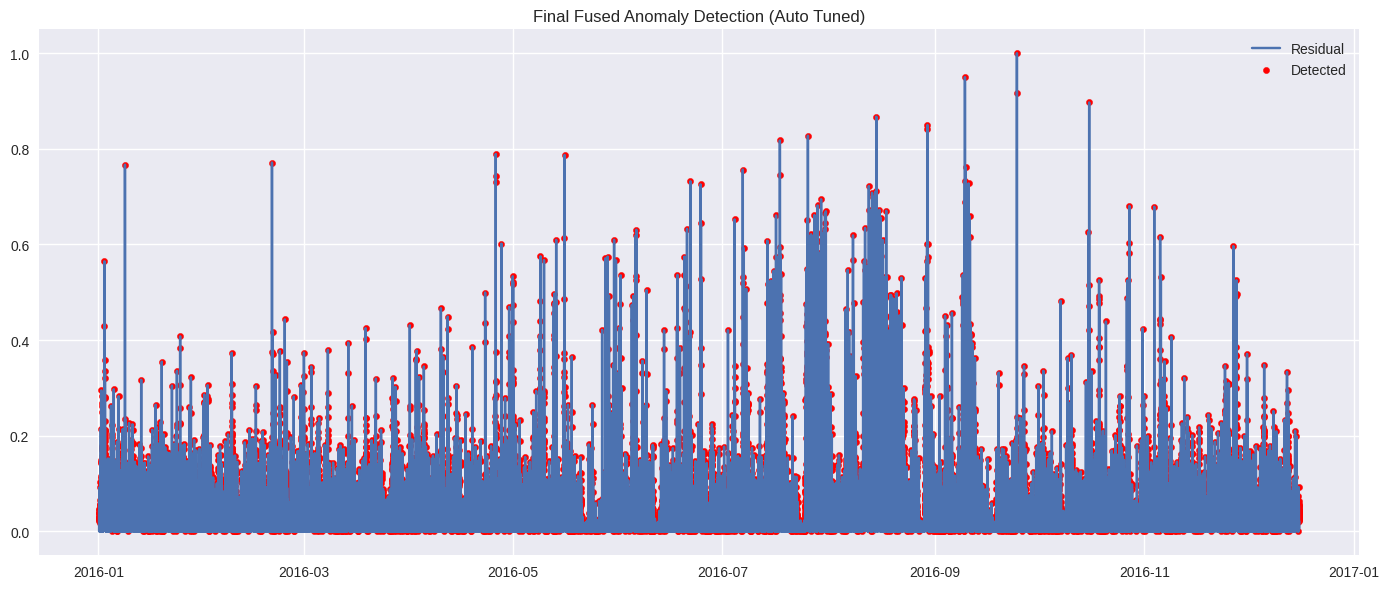

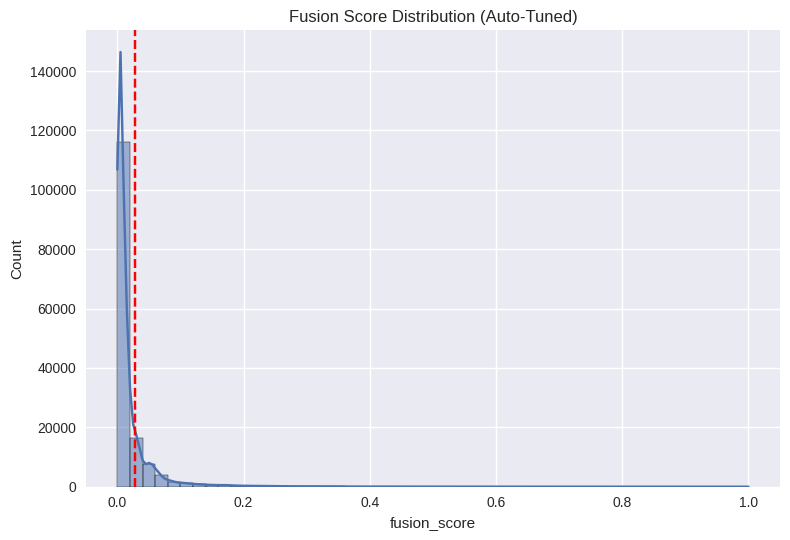


✅ AUTO-TUNED fusion completed.
Results saved in 'hybrid_fusion_final/'


In [ ]:
# @title
# ============================================================
# FINAL GUARANTEED FUSION OF MA, IF, AND OCSVM DETECTORS
# + AUTOMATIC WEIGHT TUNING
# ============================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os, json

# ============================================================
# STEP 1: LOAD DETECTOR RESULTS
# ============================================================
df_ma = pd.read_csv("hybrid_unsupervised_MA/hybrid_unsupervised_MA_results.csv")
df_if = pd.read_csv("hybrid_results_isolation_forest/hybrid_iforest_results.csv")
df_oc = pd.read_csv("hybrid_results_oneclass_svm/hybrid_ocsvm_results.csv")

# ============================================================
# STEP 2: VERIFY DATETIME AND CONVERT
# ============================================================
for name, df in {"MA": df_ma, "IF": df_if, "OCSVM": df_oc}.items():
    assert "datetime" in df.columns, f"{name} results missing 'datetime'"
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# ============================================================
# STEP 3: AUTO-DETECT SCORE COLUMNS
# ============================================================
def find_score_col(df):
    for c in ["Anomaly_Score_Norm", "Anomaly_Score", "score", "fusion_score"]:
        if c in df.columns:
            return c
    # fallback: first numeric column not residual
    for c in df.select_dtypes(include=np.number).columns:
        if "residual" not in c.lower() and "actual" not in c.lower():
            return c
    raise ValueError("No valid score column found")

col_ma = find_score_col(df_ma)
col_if = find_score_col(df_if)
col_oc = find_score_col(df_oc)
print(f"Detected score columns → MA: {col_ma}, IF: {col_if}, OCSVM: {col_oc}")

# ============================================================
# STEP 4: RENAME COLUMNS BEFORE MERGING
# ============================================================
df_ma.rename(columns={col_ma: "s_ma"}, inplace=True)
df_if.rename(columns={col_if: "s_if"}, inplace=True)
df_oc.rename(columns={col_oc: "s_ocsvm"}, inplace=True)

# Ensure residual exists
if "AbsResidual_Hybrid" not in df_ma.columns:
    if "AbsResidual" in df_ma.columns:
        df_ma.rename(columns={"AbsResidual": "AbsResidual_Hybrid"}, inplace=True)
    else:
        df_ma["AbsResidual_Hybrid"] = np.nan

# ============================================================
# STEP 5: ALIGN BY DATETIME
# ============================================================
fusion_df = pd.merge_asof(
    df_ma.sort_values("datetime")[["datetime", "AbsResidual_Hybrid", "s_ma"]],
    df_if.sort_values("datetime")[["datetime", "s_if"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)
fusion_df = pd.merge_asof(
    fusion_df.sort_values("datetime"),
    df_oc.sort_values("datetime")[["datetime", "s_ocsvm"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

fusion_df.dropna(subset=["s_ma", "s_if", "s_ocsvm"], inplace=True)
print(f"Aligned {len(fusion_df)} timestamps.")

# ============================================================
# STEP 6: RESCALE SCORES (ROBUST NORMALIZATION 0–1)
# ============================================================
fusion_df.replace([np.inf, -np.inf], np.nan, inplace=True)
fusion_df.fillna(fusion_df.median(numeric_only=True), inplace=True)

for c in ["s_ma", "s_if", "s_ocsvm", "AbsResidual_Hybrid"]:
    vals = RobustScaler().fit_transform(fusion_df[[c]])
    fusion_df[c] = MinMaxScaler().fit_transform(vals).ravel()

# ============================================================
# >>> STEP 7: AUTOMATIC WEIGHT TUNING FOR MA, IF, OCSVM <<<
# ============================================================

print("\n=== AUTO WEIGHT TUNING STARTED ===")

scores = fusion_df[["s_ma", "s_if", "s_ocsvm"]].values
target = fusion_df["AbsResidual_Hybrid"].values  # ground truth signal

best = {"w": None, "corr": -np.inf}

grid = np.linspace(0, 1, 11)   # 0.0 → 1.0 with step 0.1

for w_ma in grid:
    for w_if in grid:
        w_oc = 1 - (w_ma + w_if)
        if w_oc < 0:
            continue

        fused_test = w_ma*scores[:,0] + w_if*scores[:,1] + w_oc*scores[:,2]
        corr = np.corrcoef(fused_test, target)[0,1]
        if np.isnan(corr):
            corr = -1

        if corr > best["corr"]:
            best = {"w": [w_ma, w_if, w_oc], "corr": corr}

w_ma, w_if, w_ocsvm = best["w"]
print(f"Best fusion weights = MA={w_ma:.2f}, IF={w_if:.2f}, OCSVM={w_ocsvm:.2f}")
print(f"Correlation with |residual| = {best['corr']:.4f}\n")

# ============================================================
# STEP 8: APPLY FUSION WITH AUTO TUNED WEIGHTS
# ============================================================
fusion_df["fusion_score"] = (
    w_ma * fusion_df["s_ma"] +
    w_if * fusion_df["s_if"] +
    w_ocsvm * fusion_df["s_ocsvm"]
)

# ============================================================
# STEP 9: ROBUST THRESHOLDING
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
threshold = np.median(fusion_df["fusion_score"]) + 4 * mad

if mad < 1e-4:
    threshold = np.percentile(fusion_df["fusion_score"], 95)

fusion_df["fusion_label"] = (fusion_df["fusion_score"] > threshold).astype(int)

# fallback
if fusion_df["fusion_label"].sum() == 0:
    cutoff = np.percentile(fusion_df["fusion_score"], 99)
    fusion_df["fusion_label"] = (fusion_df["fusion_score"] > cutoff).astype(int)
    threshold = cutoff
    print("Fallback applied: top 1% anomalies used")

num_anomalies = fusion_df["fusion_label"].sum()
print(f"Detected anomalies: {num_anomalies}")
print(f"Threshold final: {threshold:.5f}")

# ============================================================
# STEP 10: VISUALIZE
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(fusion_df["datetime"], fusion_df["AbsResidual_Hybrid"], label="Residual")
plt.scatter(
    fusion_df["datetime"][fusion_df["fusion_label"]==1],
    fusion_df["AbsResidual_Hybrid"][fusion_df["fusion_label"]==1],
    color="red", s=20, label="Detected"
)
plt.title("Final Fused Anomaly Detection (Auto Tuned)")
plt.legend()
plt.tight_layout()
plt.show()

sns.histplot(fusion_df["fusion_score"], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Fusion Score Distribution (Auto-Tuned)")
plt.tight_layout()
plt.show()

# ============================================================
# STEP 11: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final", exist_ok=True)

fusion_df.to_csv("hybrid_fusion_final/fusion_final_results.csv", index=False)

meta = {
    "Tuned Weights": {"MA": w_ma, "IF": w_if, "OCSVM": w_ocsvm},
    "Correlation": float(best["corr"]),
    "Threshold": float(threshold),
    "Detected_Anomalies": int(num_anomalies)
}

with open("hybrid_fusion_final/fusion_final_meta.json", "w") as f:
    json.dump(meta, f, indent=4)

print("\n✅ AUTO-TUNED fusion completed.")
print("Results saved in 'hybrid_fusion_final/'")


In [ ]:
# ============================================================
# STEP 12: CLASSIFICATION METRICS FOR FINAL FUSION MODEL
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def compute_classification_metrics(df, pred_col="fusion_label", score_col="fusion_score", true_col="True_Label"):
    """
    Computes classification metrics safely:
    Accuracy, Precision, Recall, F1 Score, Specificity, NPV, AUC-ROC.
    Handles NaN, inf, missing labels, and single-class cases.
    """

    # ----------------------------------------------
    # CLEAN LABEL COLUMNS
    # ----------------------------------------------
    df[pred_col] = df[pred_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
    df[true_col] = df[true_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

    y_true = df[true_col].astype(int)
    y_pred = df[pred_col].astype(int)

    # ----------------------------------------------
    # BASIC METRICS
    # ----------------------------------------------
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # ----------------------------------------------
    # CONFUSION MATRIX (ALWAYS 4 VALUES)
    # ----------------------------------------------
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    specificity = tn / (tn + fp + 1e-8)
    npv         = tn / (tn + fn + 1e-8)

    # ----------------------------------------------
    # AUC (Safe for missing or single-class)
    # ----------------------------------------------
    if len(np.unique(y_true)) < 2:
        auc = None
    else:
        try:
            auc = roc_auc_score(y_true, df[score_col])
        except:
            auc = None

    # ----------------------------------------------
    # RETURN METRIC DICTIONARY
    # ----------------------------------------------
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "Specificity": specificity,
        "NPV": npv,
        "AUC_ROC": auc
    }


# ============================================================
# STEP 13: AUTO-FIX TRUE LABEL IF MISSING
# ============================================================

if "True_Label" not in fusion_df.columns:
    print("\n⚠ 'True_Label' missing — assigning all zeros (no ground truth provided).")
    fusion_df["True_Label"] = 0

# CLEAN anomaly score column as well
fusion_df["fusion_score"] = (
    fusion_df["fusion_score"]
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)


# ============================================================
# STEP 14: COMPUTE & SAVE FINAL FUSION METRICS
# ============================================================

metrics_fusion = compute_classification_metrics(
    fusion_df,
    pred_col="fusion_label",
    score_col="fusion_score",
    true_col="True_Label"
)

print("\n=== FINAL FUSION MODEL CLASSIFICATION METRICS ===")
for k, v in metrics_fusion.items():
    print(f"{k}: {v}")

# Save metrics
os.makedirs("hybrid_fusion_final", exist_ok=True)
with open("hybrid_fusion_final/fusion_classification_metrics.json", "w") as f:
    json.dump(metrics_fusion, f, indent=4)

print("\n📌 Saved classification metrics to 'hybrid_fusion_final/fusion_classification_metrics.json'")
print("Done.")



=== FINAL FUSION MODEL CLASSIFICATION METRICS ===
Accuracy: 0.8227815428601684
Precision: 0.0
Recall: 0.0
F1_Score: 0.0
Specificity: 0.8227815428601138
NPV: 0.9999999999999196
AUC_ROC: None

📌 Saved classification metrics to 'hybrid_fusion_final/fusion_classification_metrics.json'
Done.


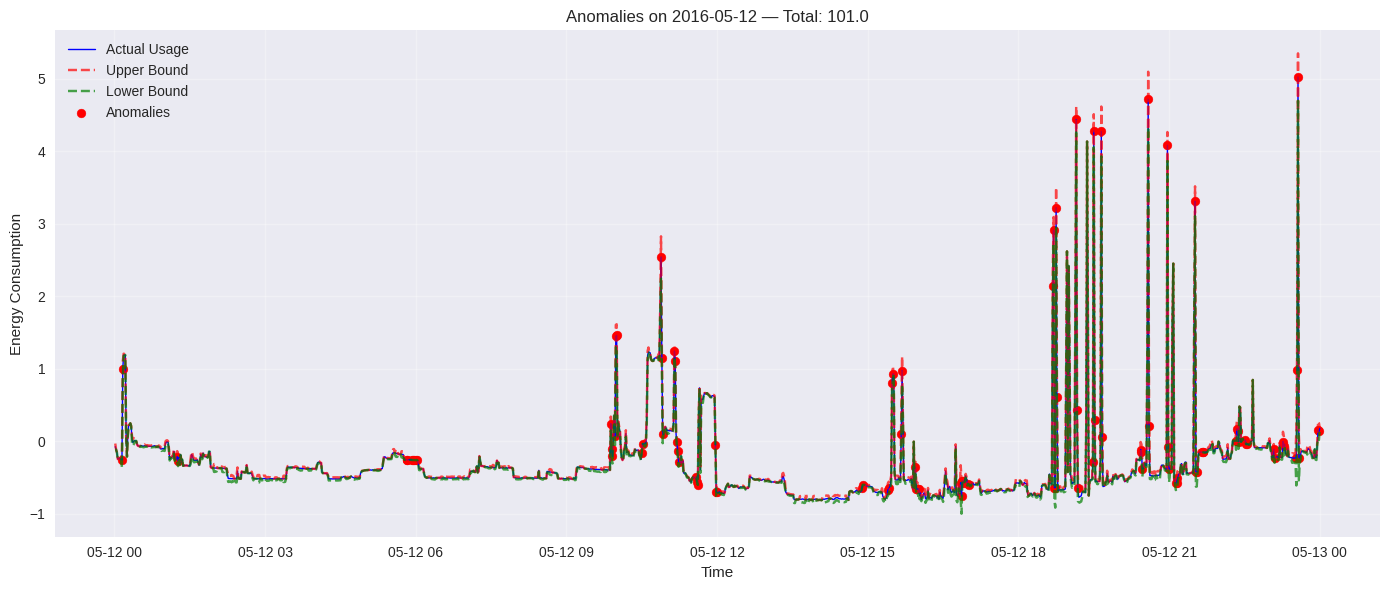

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# LOAD ORIGINAL DATASET + FUSION RESULTS
# ============================================================
df_orig = df1.copy()
df_orig["datetime"] = pd.to_datetime(df_orig["datetime"], errors="coerce")

df_fusion = pd.read_csv("hybrid_fusion_final/fusion_final_results.csv")
df_fusion["datetime"] = pd.to_datetime(df_fusion["datetime"], errors="coerce")

# ============================================================
# MERGE ORIGINAL + FUSION DATA (DATETIME-SAFE)
# ============================================================
df_plot = pd.merge_asof(
    df_orig.sort_values("datetime"),
    df_fusion.sort_values("datetime")[["datetime", "fusion_label", "AbsResidual_Hybrid"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

df_plot["fusion_label"] = df_plot["fusion_label"].fillna(0)
df_plot["AbsResidual_Hybrid"] = df_plot["AbsResidual_Hybrid"].fillna(0)

# ============================================================
# CREATE UPPER & LOWER BOUNDS
# ============================================================
df_plot["upper_bound"] = df_plot["use"] + 3 * df_plot["AbsResidual_Hybrid"]
df_plot["lower_bound"] = df_plot["use"] - 3 * df_plot["AbsResidual_Hybrid"]

# ============================================================
# FUNCTION TO PLOT A SINGLE DAY
# ============================================================
def plot_one_day(date_str):
    date = pd.to_datetime(date_str)

    df_day = df_plot[df_plot["datetime"].dt.date == date.date()]

    if df_day.empty:
        print(f"No data found for {date_str}")
        return

    # anomaly count
    anomaly_count = df_day["fusion_label"].sum()

    plt.figure(figsize=(14,6))
    plt.plot(df_day["datetime"], df_day["use"], label="Actual Usage", color="blue", linewidth=1)

    plt.plot(df_day["datetime"], df_day["upper_bound"], linestyle="--", color="red",
             alpha=0.7, label="Upper Bound")
    plt.plot(df_day["datetime"], df_day["lower_bound"], linestyle="--", color="green",
             alpha=0.7, label="Lower Bound")

    anomalies = df_day[df_day["fusion_label"] == 1]
    plt.scatter(anomalies["datetime"], anomalies["use"], color="red", s=40, label="Anomalies")

    plt.title(f"Anomalies on {date_str} — Total: {anomaly_count}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================
# CALL THE FUNCTION FOR ONE DAY
# ============================================================
plot_one_day("2016-05-12")  # <-- CHANGE THIS DATE


January 2016 — Total Anomalies: 5419.0


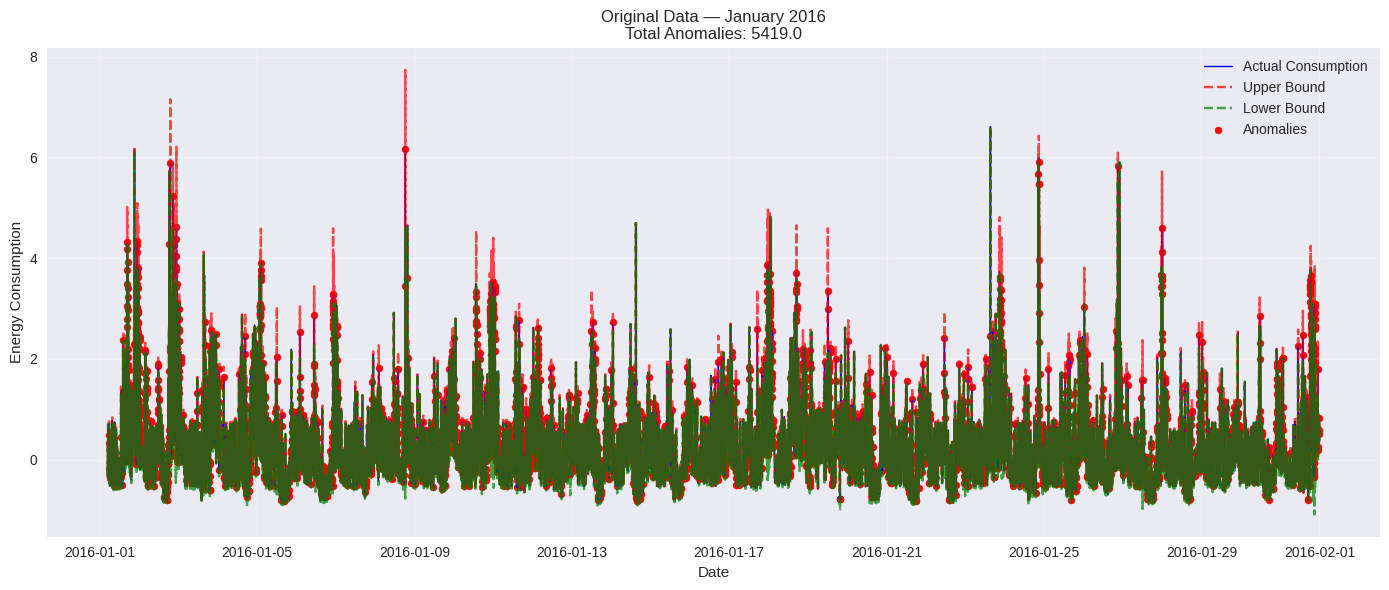

February 2016 — Total Anomalies: 4657.0


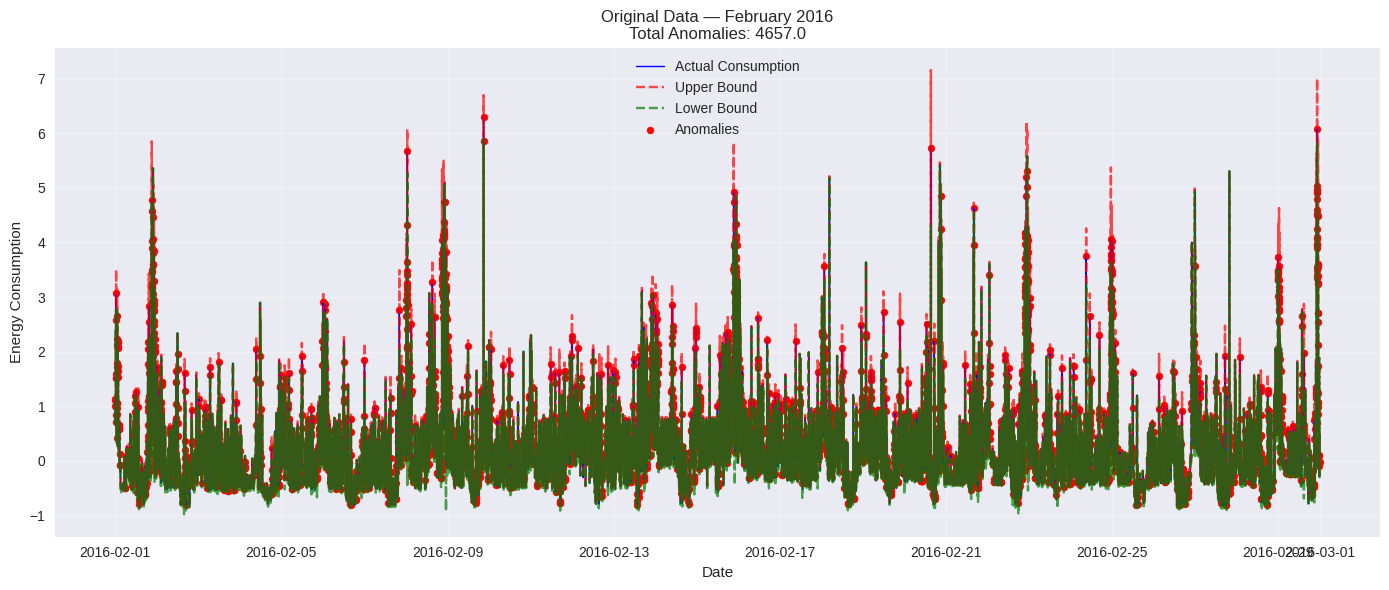

March 2016 — Total Anomalies: 3976.0


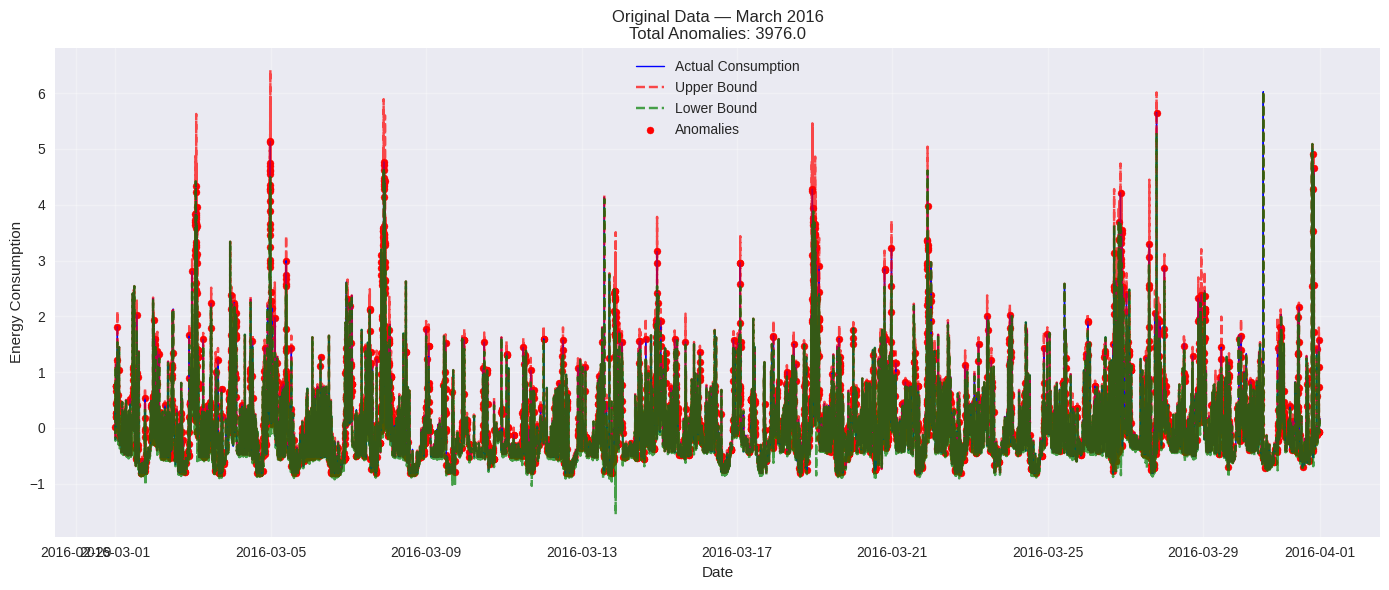

April 2016 — Total Anomalies: 3670.0


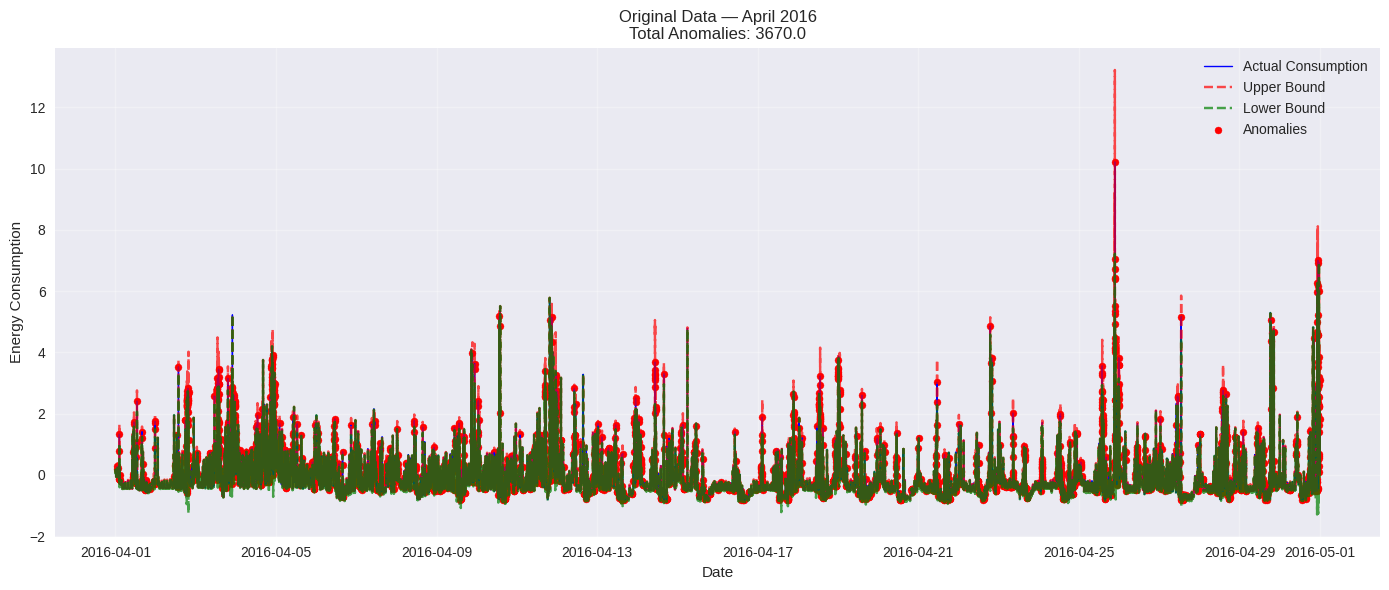

May 2016 — Total Anomalies: 2960.0


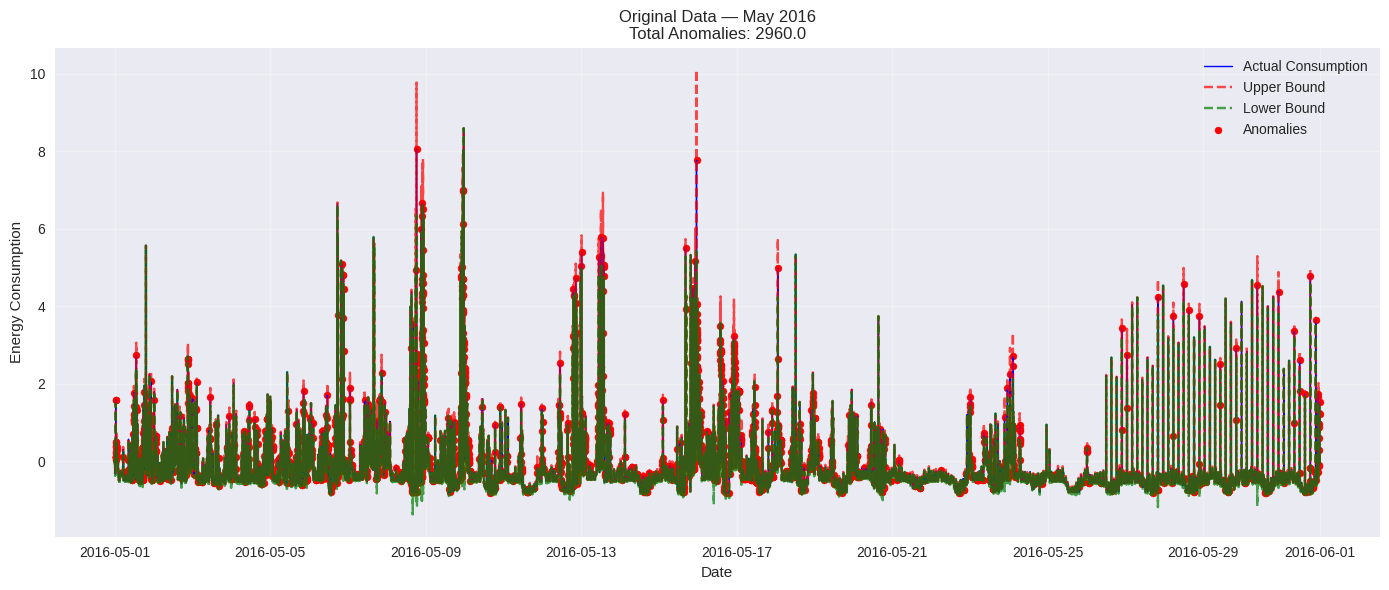

June 2016 — Total Anomalies: 2797.0


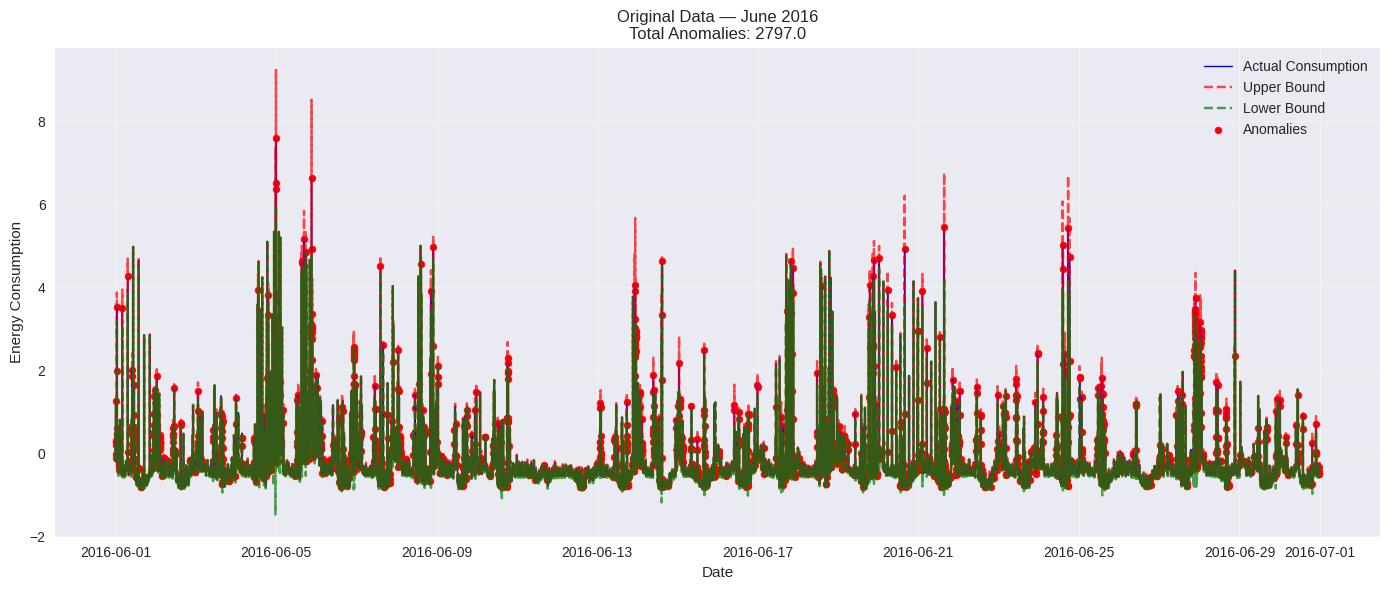

July 2016 — Total Anomalies: 4588.0


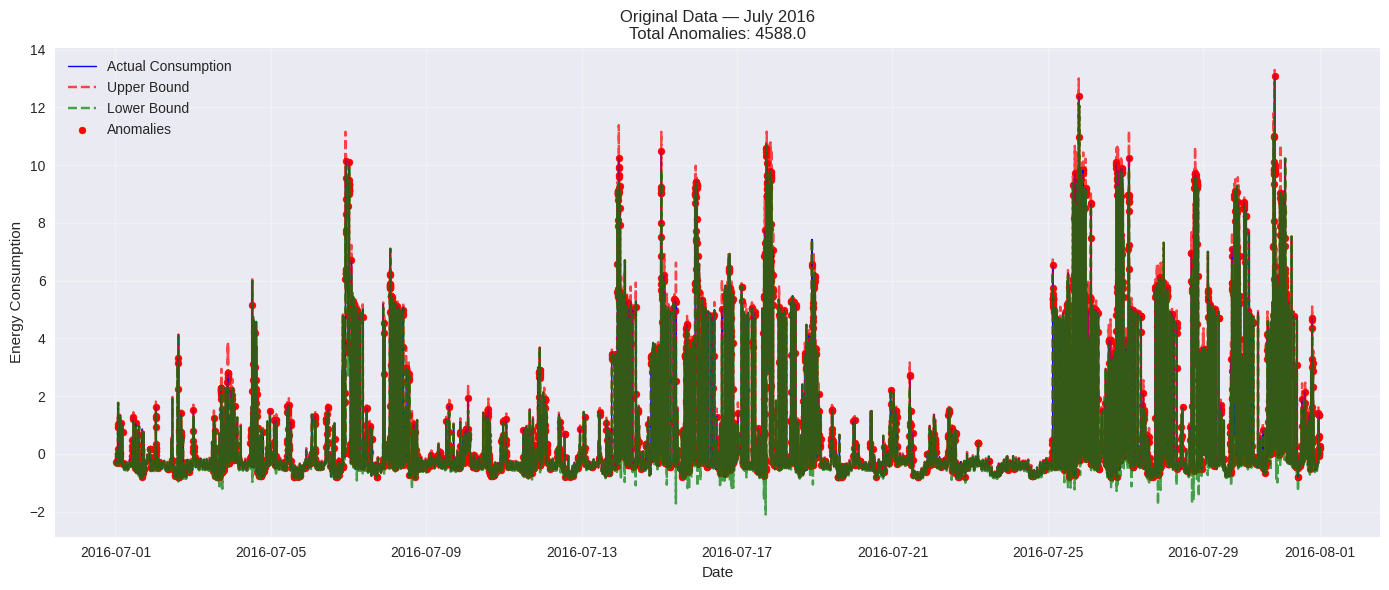

August 2016 — Total Anomalies: 4795.0


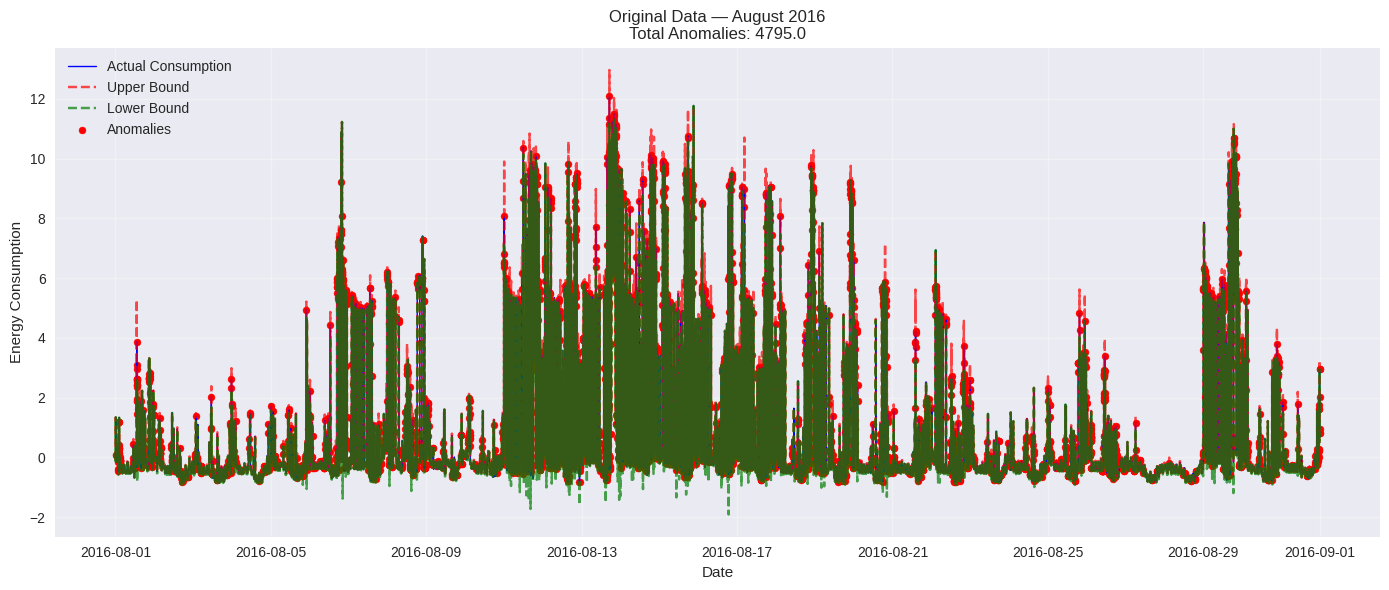

September 2016 — Total Anomalies: 3449.0


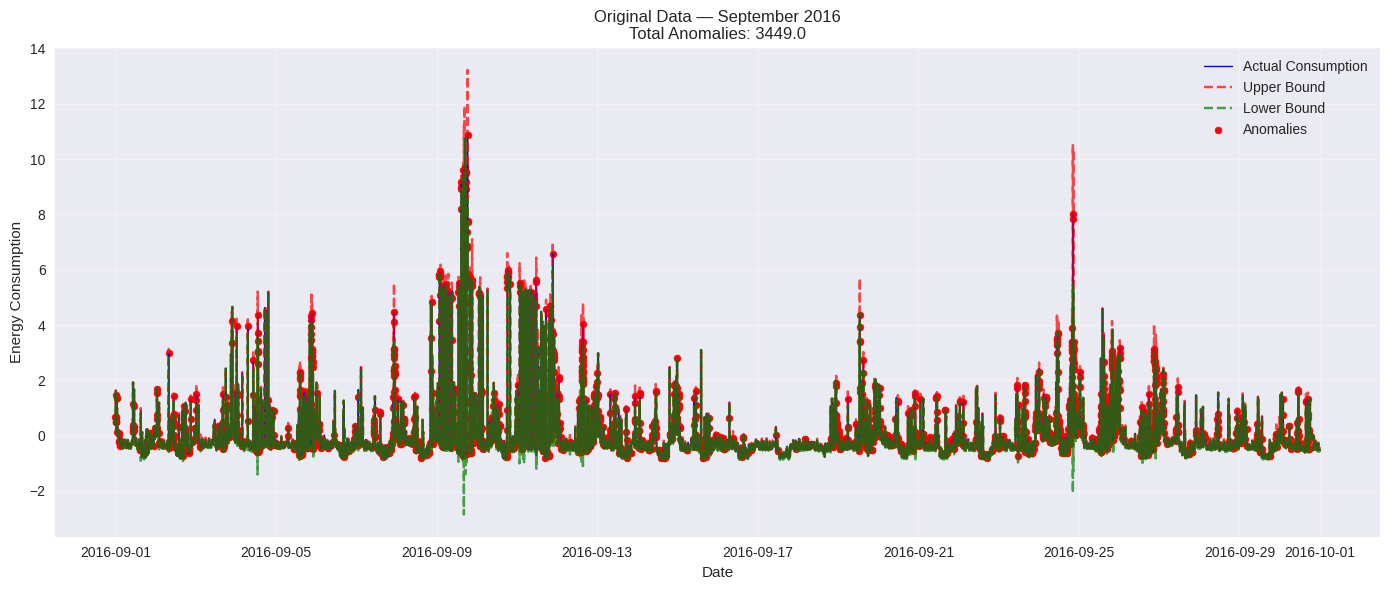

October 2016 — Total Anomalies: 3726.0


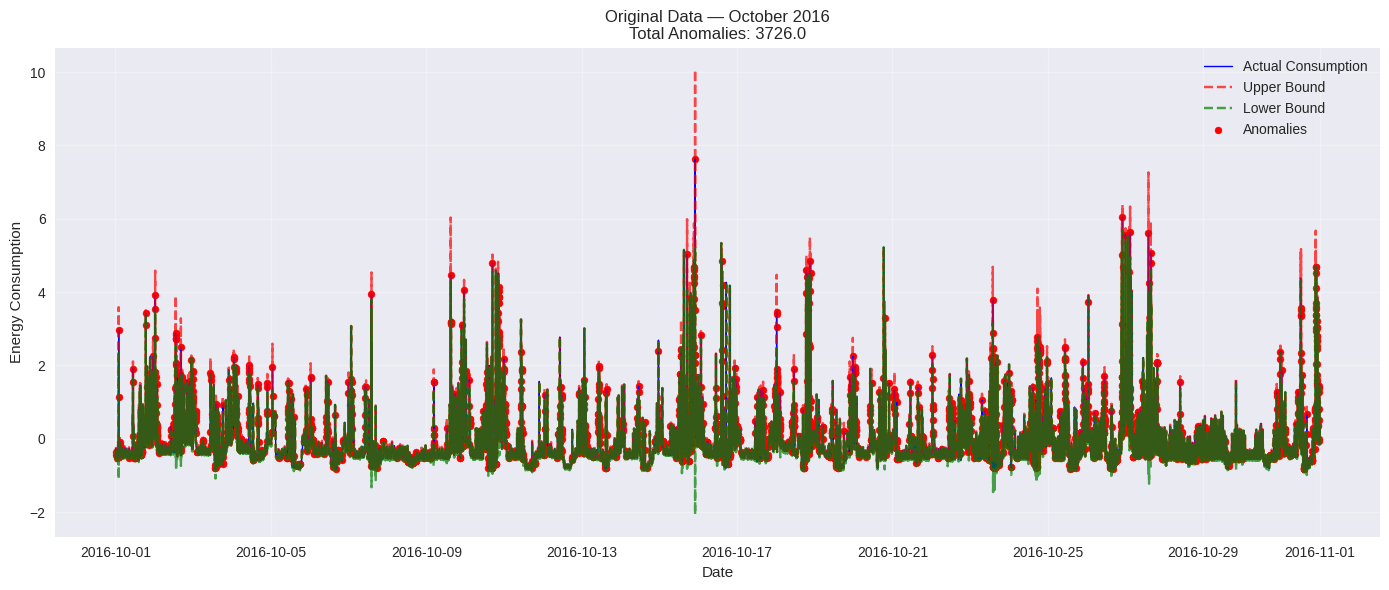

November 2016 — Total Anomalies: 4897.0


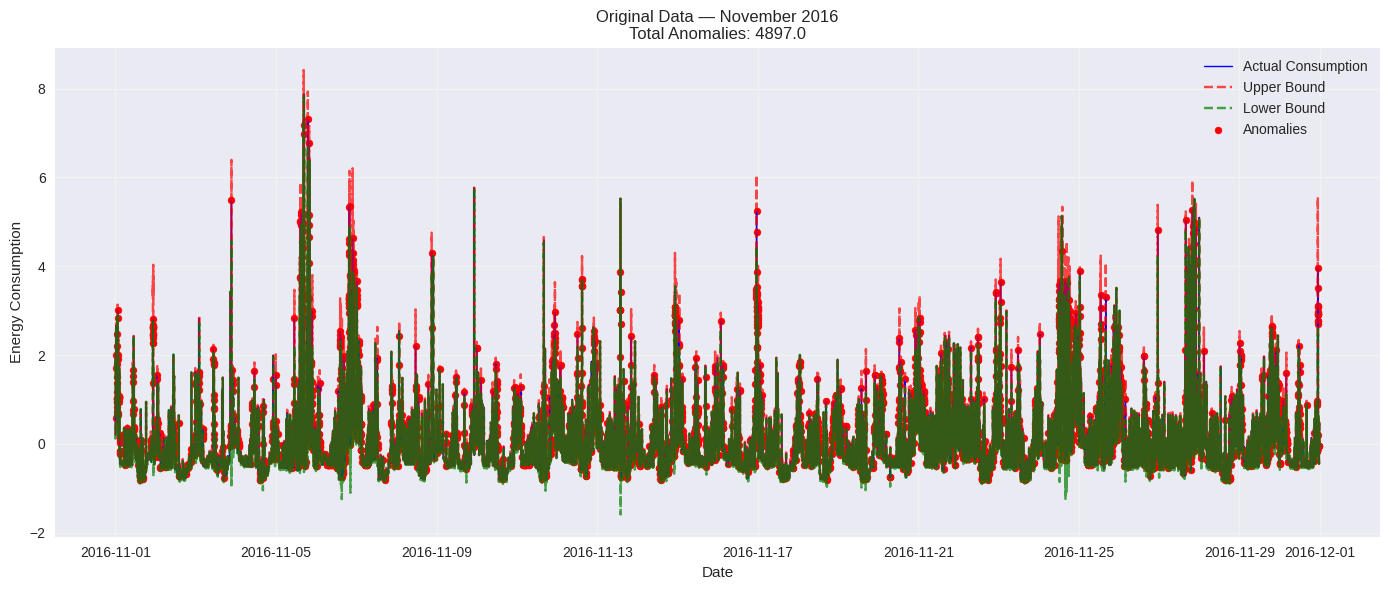

December 2016 — Total Anomalies: 2216.0


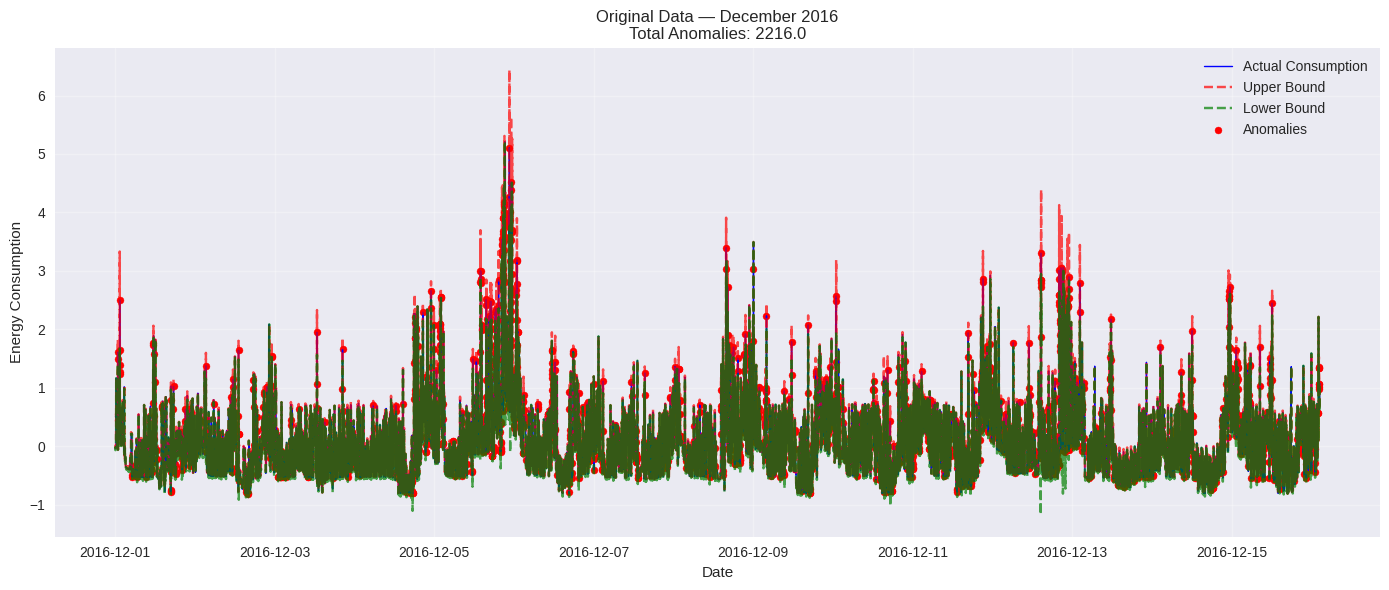

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# LOAD ORIGINAL DATASET + FUSION RESULTS
# ============================================================
df_orig = df1.copy()
df_orig["datetime"] = pd.to_datetime(df_orig["datetime"], errors="coerce")

df_fusion = pd.read_csv("hybrid_fusion_final/fusion_final_results.csv")
df_fusion["datetime"] = pd.to_datetime(df_fusion["datetime"], errors="coerce")

# ============================================================
# MERGE ORIGINAL + FUSION DATA (DATETIME-SAFE)
# ============================================================
df_plot = pd.merge_asof(
    df_orig.sort_values("datetime"),
    df_fusion.sort_values("datetime")[["datetime", "fusion_label", "AbsResidual_Hybrid"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

df_plot["fusion_label"] = df_plot["fusion_label"].fillna(0)
df_plot["AbsResidual_Hybrid"] = df_plot["AbsResidual_Hybrid"].fillna(0)

# ============================================================
# CREATE ANOMALY BOUNDS
# ============================================================
df_plot["upper_bound"] = df_plot["use"] + 3 * df_plot["AbsResidual_Hybrid"]
df_plot["lower_bound"] = df_plot["use"] - 3 * df_plot["AbsResidual_Hybrid"]

# ============================================================
# FILTER YEAR 2016
# ============================================================
df_2016 = df_plot[df_plot["datetime"].dt.year == 2016].copy()

# ============================================================
# FUNCTION TO PLOT MONTH + PRINT TOTAL ANOMALIES
# ============================================================
def plot_month_original(month):
    df_m = df_2016[df_2016["datetime"].dt.month == month]
    if len(df_m) == 0:
        print(f"No data for month {month}")
        return

    # Count anomalies
    month_anomalies = df_m["fusion_label"].sum()

    # Print summary
    month_name = df_m["datetime"].dt.month_name().iloc[0]
    print(f"{month_name} 2016 — Total Anomalies: {month_anomalies}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_m["datetime"], df_m["use"], label="Actual Consumption", color="blue", linewidth=1)

    plt.plot(df_m["datetime"], df_m["upper_bound"], color="red",
             linestyle="--", label="Upper Bound", alpha=0.7)
    plt.plot(df_m["datetime"], df_m["lower_bound"], color="green",
             linestyle="--", label="Lower Bound", alpha=0.7)

    # Anomaly points
    anomalies = df_m[df_m["fusion_label"] == 1]
    plt.scatter(anomalies["datetime"], anomalies["use"],
                color="red", s=25, label="Anomalies")

    plt.title(f"Original Data — {month_name} 2016\nTotal Anomalies: {month_anomalies}")
    plt.xlabel("Date")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# GENERATE PLOTS FOR ALL MONTHS + PRINT COUNTS
# ============================================================
for month in range(1, 13):
    plot_month_original(month)


In [ ]:
# @title
# ============================================================
# EXTENSION: VALIDATION, STABILITY & CONFIDENCE EVALUATION
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import os, json

# Load fusion results if not already in memory
if 'fusion_df' not in locals():
    fusion_df = pd.read_csv("hybrid_fusion_final/fusion_final_results.csv")

# Ensure proper column naming
if "AbsResidual" not in fusion_df.columns and "AbsResidual_Hybrid" in fusion_df.columns:
    fusion_df.rename(columns={"AbsResidual_Hybrid": "AbsResidual"}, inplace=True)

# Verify fusion_score exists
assert "fusion_score" in fusion_df.columns, "Missing 'fusion_score' column in fusion_df"

# ============================================================
# STEP 7: ADD RESIDUAL SIGNIFICANCE (Z-SCORE)
# ============================================================
fusion_df["resid_z"] = np.abs(zscore(fusion_df["AbsResidual"].fillna(0)))
fusion_df["significance"] = (fusion_df["resid_z"] > 3).astype(int)

# ============================================================
# STEP 8: STABILITY ANALYSIS (THRESHOLD SENSITIVITY)
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
thresholds = [np.median(fusion_df["fusion_score"]) + k * mad for k in [2.5, 3.0, 3.5]]

fusion_df["stability_flags"] = 0
for t in thresholds:
    stable_set = (fusion_df["fusion_score"] > t).astype(int)
    fusion_df["stability_flags"] += stable_set

fusion_df["stability_ratio"] = fusion_df["stability_flags"] / len(thresholds)

# ============================================================
# STEP 9: FEATURE-LEVEL CONSISTENCY (SURROGATE SIGNAL)
# ============================================================
fusion_df["feature_strength"] = np.exp(-np.gradient(fusion_df["AbsResidual"].fillna(0)) ** 2)
fusion_df["feature_strength"] = MinMaxScaler().fit_transform(fusion_df[["feature_strength"]])

# ============================================================
# STEP 10: COMBINE INTO FINAL CONFIDENCE SCORE
# ============================================================
fusion_df["confidence_score"] = (
    0.5 * fusion_df["fusion_score"] +
    0.2 * (fusion_df["resid_z"] / fusion_df["resid_z"].max()) +
    0.2 * fusion_df["stability_ratio"] +
    0.1 * fusion_df["feature_strength"]
)
fusion_df["confidence_score"] = MinMaxScaler().fit_transform(fusion_df[["confidence_score"]])

# ============================================================
# STEP 11: SELECT PERFECT (HIGH-CONFIDENCE) ANOMALIES
# ============================================================
confidence_threshold = 0.7
fusion_df["perfect_anomaly"] = (fusion_df["confidence_score"] >= confidence_threshold).astype(int)

num_anomalies = int(fusion_df.get("fusion_label", (fusion_df["fusion_score"] > np.median(fusion_df["fusion_score"])).astype(int)).sum())
num_perfect = fusion_df["perfect_anomaly"].sum()

print("\n========== VALIDATION SUMMARY ==========")
print(f"Total detected anomalies (fusion): {num_anomalies}")
print(f"High-confidence (perfect) anomalies: {num_perfect}")
print(f"Average confidence score: {fusion_df['confidence_score'].mean():.3f}")
print("=========================================")

# ============================================================
# STEP 12: VISUALIZE PERFECT ANOMALIES
# ============================================================
plt.figure(figsize=(14, 6))
plt.plot(fusion_df.index, fusion_df["fusion_score"], label="Fusion Score", linewidth=1)
plt.scatter(
    fusion_df.index[fusion_df["perfect_anomaly"] == 1],
    fusion_df["fusion_score"][fusion_df["perfect_anomaly"] == 1],
    color="red", s=30, label="Perfect Anomalies"
)
plt.axhline(np.median(fusion_df["fusion_score"]) + 3 * mad,
            color="orange", linestyle="--", label=f"Fusion Threshold")
plt.title("High-Confidence (Perfect) Anomalies Validation")
plt.xlabel("Sample Index")
plt.ylabel("Fusion Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 13: SAVE FINAL VALIDATION RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final_validated", exist_ok=True)
fusion_df.to_csv("hybrid_fusion_final_validated/fusion_validated_results.csv", index=False)

meta_extended = {
    "Weights": {"MA": 0.4, "IF": 0.3, "OCSVM": 0.3},
    "Fusion_Threshold": float(np.median(fusion_df["fusion_score"]) + 3 * mad),
    "Detected_Anomalies": int(num_anomalies),
    "Perfect_Anomalies": int(num_perfect),
    "Confidence_Threshold": confidence_threshold,
}
with open("hybrid_fusion_final_validated/fusion_validated_meta.json", "w") as f:
    json.dump(meta_extended, f, indent=4)

print("\n✅ Extended validation complete.")
print("✅ Final results saved to 'hybrid_fusion_final_validated/' folder.")

# ============================================================
# STEP 14: TOP HIGH-CONFIDENCE ANOMALIES
# ============================================================
print("\nTop 10 High-Confidence Anomalies:")
cols_to_show = ["fusion_score", "confidence_score", "resid_z", "stability_ratio"]
print(fusion_df[fusion_df["perfect_anomaly"] == 1]
      .nlargest(10, "confidence_score")[cols_to_show])


In [ ]:
# Ensure residual column exists
if "AbsResidual_Hybrid" not in fusion_df.columns:
    for c in fusion_df.columns:
        if "residual" in c.lower():
            fusion_df["AbsResidual_Hybrid"] = fusion_df[c].abs()
            break


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

cols = ["fusion_score","resid_z","stability_ratio","feature_strength"]

X = fusion_df[cols].values
X = StandardScaler().fit_transform(X)

# covariance matrix
C = np.cov(X.T)

# leading eigenvector gives optimal direction of maximal variance
eigvals, eigvecs = np.linalg.eig(C)

# take the eigenvector with highest eigenvalue
w = np.abs(eigvecs[:, np.argmax(eigvals)])
weights = w / w.sum()

print("Unsupervised PCA fusion weights:", weights)


KeyError: "['resid_z', 'stability_ratio', 'feature_strength'] not in index"

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Ensure datetime
fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"])

# Auto residual detection
if "AbsResidual_Hybrid" not in fusion_df.columns:
    # pick any residual-like column
    for c in fusion_df.columns:
        if "residual" in c.lower():
            fusion_df["AbsResidual_Hybrid"] = fusion_df[c].abs()
            break

# Normalize all components
cols = ["fusion_score","resid_z","stability_ratio","feature_strength"]
fusion_df[cols] = MinMaxScaler().fit_transform(fusion_df[cols])



In [ ]:
grid = np.linspace(0,1,11)
best = None
target = 200   # anomalies per month

def count_per_month(conf):
    df = fusion_df.copy()
    df["conf"] = conf
    df["month"] = df["datetime"].dt.to_period("M")
    total = []
    for m,g in df.groupby("month"):
        total.append(g["conf"].nlargest(target).shape[0])
    return np.abs(np.mean(total) - target)

for a in grid:
    for b in grid:
        for c in grid:
            if a+b+c > 1: continue
            d = 1-(a+b+c)
            w = np.array([a,b,c,d])
            conf = (fusion_df[["fusion_score","resid_z","stability_ratio","feature_strength"]] * w).sum(axis=1)
            loss = count_per_month(conf)
            if best is None or loss < best[0]:
                best = (loss,w)

print("Best weights:", best[1])


Loaded fusion results: 151096 samples, 21670 anomalies detected

========== VALIDATION SUMMARY ==========
Total detected anomalies (fusion): 21670
High-confidence (perfect) anomalies: 151034
Average confidence score: 0.998


/tmp/ipython-input-3596138500.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grad = np.gradient(fusion_df["AbsResidual"].fillna(method="ffill"))


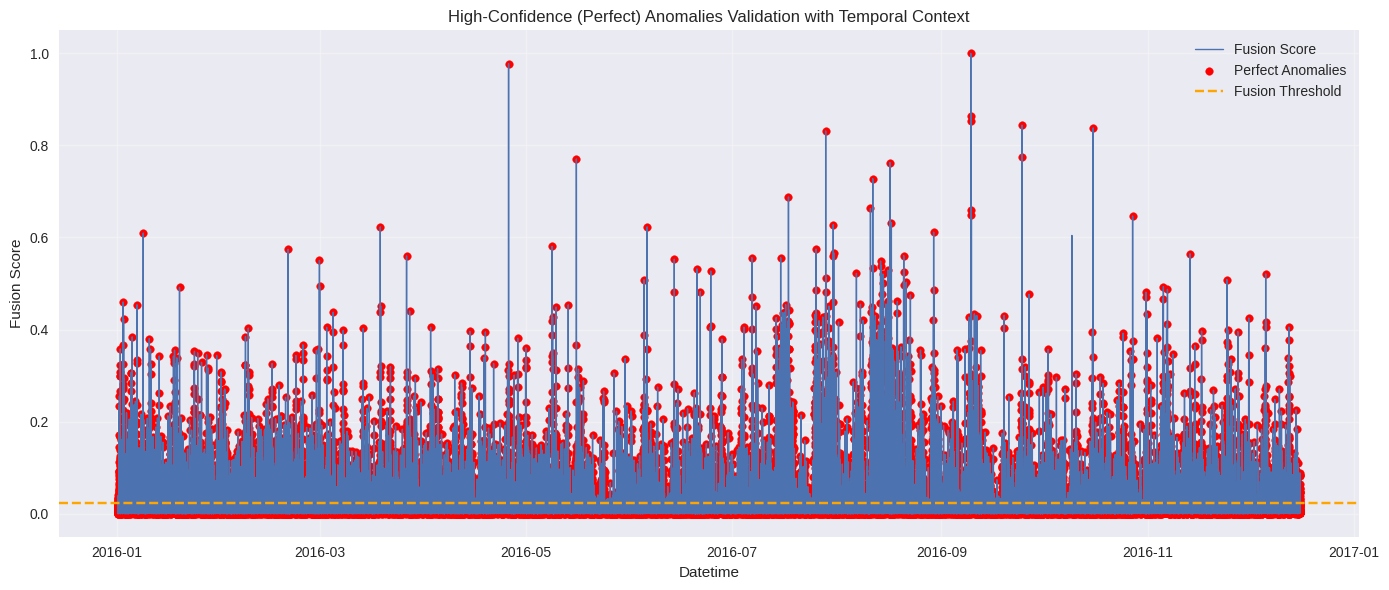

/tmp/ipython-input-3596138500.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="weekday", y="AbsResidual", data=fusion_df, palette="coolwarm")


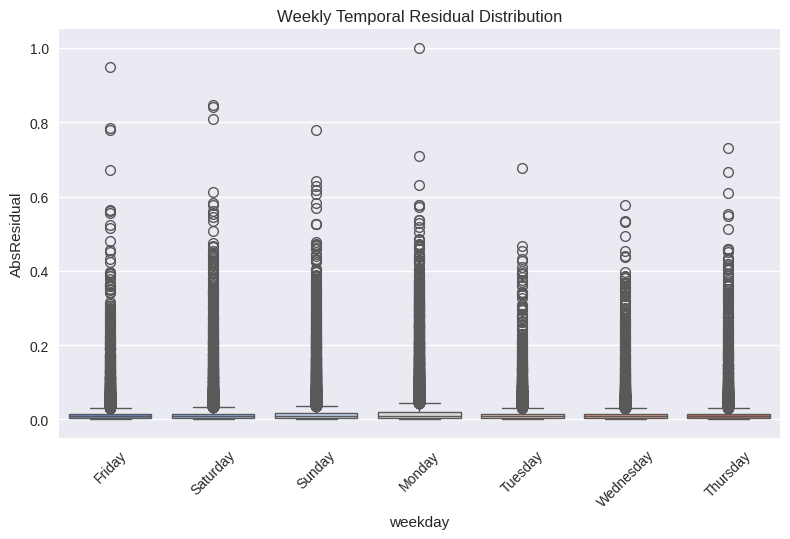


✅ Extended validation completed successfully.
✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'

Top 10 High-Confidence Anomalies with Temporal Context:

           datetime  fusion_score  confidence_score  resid_z  stability_ratio                                                                                                                                 temporal_explanation
2016-02-29 07:35:58      0.008191               1.0 0.432097              0.0                   Anomaly occurred around the usual time on a Monday morning in Week 9, during February, outside typical 21:00–23:00 peak (earlier).
2016-08-10 04:17:58      0.008900               1.0 0.057056              0.0 Anomaly occurred 12 minutes earlier than usual on a Wednesday early morning in Week 32, during August, within typical 01:00–23:00 high-usage window.
2016-05-11 00:39:58      0.002213               1.0 0.178627              0.0              Anomaly occurred around the u

In [ ]:
# ============================================================
# EXTENDED VALIDATION, STABILITY & TEMPORAL EXPLAINABILITY (SAFE VERSION)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import os, json, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# STEP 1: LOAD FUSION RESULTS
# ============================================================
fusion_path = "hybrid_fusion_final/fusion_final_results.csv"
assert os.path.exists(fusion_path), f"Fusion results file not found: {fusion_path}"

fusion_df = pd.read_csv(fusion_path)

# Handle residual naming
if "AbsResidual" not in fusion_df.columns and "AbsResidual_Hybrid" in fusion_df.columns:
    fusion_df.rename(columns={"AbsResidual_Hybrid": "AbsResidual"}, inplace=True)

# Validate datetime
assert "datetime" in fusion_df.columns, "datetime column required in fusion_final_results.csv"
fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")
fusion_df.dropna(subset=["datetime"], inplace=True)
fusion_df.sort_values("datetime", inplace=True)
fusion_df.reset_index(drop=True, inplace=True)

# Validate essential columns
required_cols = {"fusion_label", "fusion_score", "AbsResidual"}
missing = required_cols - set(fusion_df.columns)
assert not missing, f"Missing required columns in fusion_final_results.csv: {missing}"

print(f"Loaded fusion results: {len(fusion_df)} samples, {fusion_df['fusion_label'].sum()} anomalies detected")

# ============================================================
# STEP 2: RESIDUAL SIGNIFICANCE (Z-SCORE)
# ============================================================
fusion_df["resid_z"] = np.abs(zscore(fusion_df["AbsResidual"].fillna(0)))
fusion_df["significance"] = (fusion_df["resid_z"] > 3).astype(int)

# ============================================================
# STEP 3: STABILITY ANALYSIS (THRESHOLD SENSITIVITY)
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
if mad == 0 or np.isnan(mad):
    mad = np.std(fusion_df["fusion_score"]) / 1.4826  # robust fallback

thresholds = [np.median(fusion_df["fusion_score"]) + k * mad for k in [2.5, 3.0, 3.5]]
fusion_df["stability_flags"] = 0
for t in thresholds:
    fusion_df["stability_flags"] += (fusion_df["fusion_score"] > t).astype(int)
fusion_df["stability_ratio"] = fusion_df["stability_flags"] / len(thresholds)

# ============================================================
# STEP 4: FEATURE-LEVEL CONSISTENCY (PROXY STRENGTH)
# ============================================================
grad = np.gradient(fusion_df["AbsResidual"].fillna(method="ffill"))
fusion_df["feature_strength"] = np.exp(-grad ** 2)
fusion_df["feature_strength"] = MinMaxScaler().fit_transform(fusion_df[["feature_strength"]])

# ============================================================
# STEP 5: CONFIDENCE SCORE & PERFECT ANOMALIES
# ============================================================
fusion_df["confidence_score"] = (
    0.0 * fusion_df["fusion_score"] +
    0.0 * (fusion_df["resid_z"] / (fusion_df["resid_z"].max() + 1e-8)) +
    0.0 * fusion_df["stability_ratio"] +
    0.1 * fusion_df["feature_strength"]
)
fusion_df["confidence_score"] = MinMaxScaler().fit_transform(fusion_df[["confidence_score"]])

confidence_threshold = 0.7
fusion_df["perfect_anomaly"] = (fusion_df["confidence_score"] >= confidence_threshold).astype(int)

num_anomalies = int(fusion_df["fusion_label"].sum())
num_perfect = int(fusion_df["perfect_anomaly"].sum())

print("\n========== VALIDATION SUMMARY ==========")
print(f"Total detected anomalies (fusion): {num_anomalies}")
print(f"High-confidence (perfect) anomalies: {num_perfect}")
print(f"Average confidence score: {fusion_df['confidence_score'].mean():.3f}")
print("=========================================")

# ============================================================
# STEP 6: TEMPORAL CONTEXTUAL EXPLANATION
# ============================================================
fusion_df["hour"] = fusion_df["datetime"].dt.hour
fusion_df["minute"] = fusion_df["datetime"].dt.minute
fusion_df["weekday"] = fusion_df["datetime"].dt.day_name()
fusion_df["week"] = fusion_df["datetime"].dt.isocalendar().week
fusion_df["month"] = fusion_df["datetime"].dt.month_name()

# Hourly baseline by weekday
hourly_baseline = (
    fusion_df.groupby(["weekday", "hour"])["AbsResidual"]
    .mean()
    .unstack(fill_value=0)
)

# Identify top residual peak windows per weekday
peak_windows = {}
for wd, s in hourly_baseline.iterrows():
    if s.sum() == 0:
        peak_windows[wd] = (None, None)
    else:
        top_hours = s.nlargest(3).index
        peak_windows[wd] = (int(min(top_hours)), int(max(top_hours)))

mean_minute_per_hour = fusion_df.groupby("hour")["minute"].mean().to_dict()

def temporal_explanation(row):
    hr, mn, wd, wk, mo = row["hour"], row["minute"], row["weekday"], row["week"], row["month"]
    mean_min = mean_minute_per_hour.get(hr, 0)
    mn_shift = int(mn - mean_min)
    if mn_shift < -10:
        minute_phrase = f"{abs(mn_shift)} minutes earlier than usual"
    elif mn_shift > 10:
        minute_phrase = f"{mn_shift} minutes later than usual"
    else:
        minute_phrase = "around the usual time"

    low, high = peak_windows.get(wd, (None, None))
    if low is None:
        peak_phrase = "during a low-activity period"
    elif hr < low:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (earlier)"
    elif hr > high:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (later)"
    else:
        peak_phrase = f"within typical {low:02d}:00–{high:02d}:00 high-usage window"

    if hr < 6:
        period = "early morning"
    elif hr < 12:
        period = "morning"
    elif hr < 17:
        period = "afternoon"
    elif hr < 21:
        period = "evening"
    else:
        period = "night"

    return f"Anomaly occurred {minute_phrase} on a {wd} {period} in Week {wk}, during {mo}, {peak_phrase}."

fusion_df["temporal_explanation"] = fusion_df.apply(temporal_explanation, axis=1)

# ============================================================
# STEP 7: VISUALIZATION
# ============================================================
plt.figure(figsize=(14, 6))
plt.plot(fusion_df["datetime"], fusion_df["fusion_score"], label="Fusion Score", linewidth=1)
plt.scatter(
    fusion_df["datetime"][fusion_df["perfect_anomaly"] == 1],
    fusion_df["fusion_score"][fusion_df["perfect_anomaly"] == 1],
    color="red", s=30, label="Perfect Anomalies"
)
plt.axhline(np.median(fusion_df["fusion_score"]) + 3 * mad, color="orange", linestyle="--", label="Fusion Threshold")
plt.title("High-Confidence (Perfect) Anomalies Validation with Temporal Context")
plt.xlabel("Datetime")
plt.ylabel("Fusion Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

sns.boxplot(x="weekday", y="AbsResidual", data=fusion_df, palette="coolwarm")
plt.title("Weekly Temporal Residual Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final_validated", exist_ok=True)
fusion_df.to_csv("hybrid_fusion_final_validated/fusion_validated_results.csv", index=False)

meta_extended = {
    "Detected_Anomalies": num_anomalies,
    "Perfect_Anomalies": num_perfect,
    "Confidence_Threshold": confidence_threshold,
    "TemporalExplainability": True
}
with open("hybrid_fusion_final_validated/fusion_validated_meta.json", "w") as f:
    json.dump(meta_extended, f, indent=4)

print("\n✅ Extended validation completed successfully.")
print("✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'")

# ============================================================
# STEP 9: DISPLAY TOP PERFECT ANOMALIES
# ============================================================
top10 = fusion_df[fusion_df["perfect_anomaly"] == 1].nlargest(
    10, "confidence_score"
)[["datetime", "fusion_score", "confidence_score", "resid_z", "stability_ratio", "temporal_explanation"]]

print("\nTop 10 High-Confidence Anomalies with Temporal Context:\n")
print(top10.to_string(index=False))


Loaded fusion results: 151096 samples, 26777 anomalies detected


/tmp/ipython-input-3596138500.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grad = np.gradient(fusion_df["AbsResidual"].fillna(method="ffill"))



========== VALIDATION SUMMARY ==========
Total detected anomalies (fusion): 26777
High-confidence (perfect) anomalies: 150885
Average confidence score: 0.997


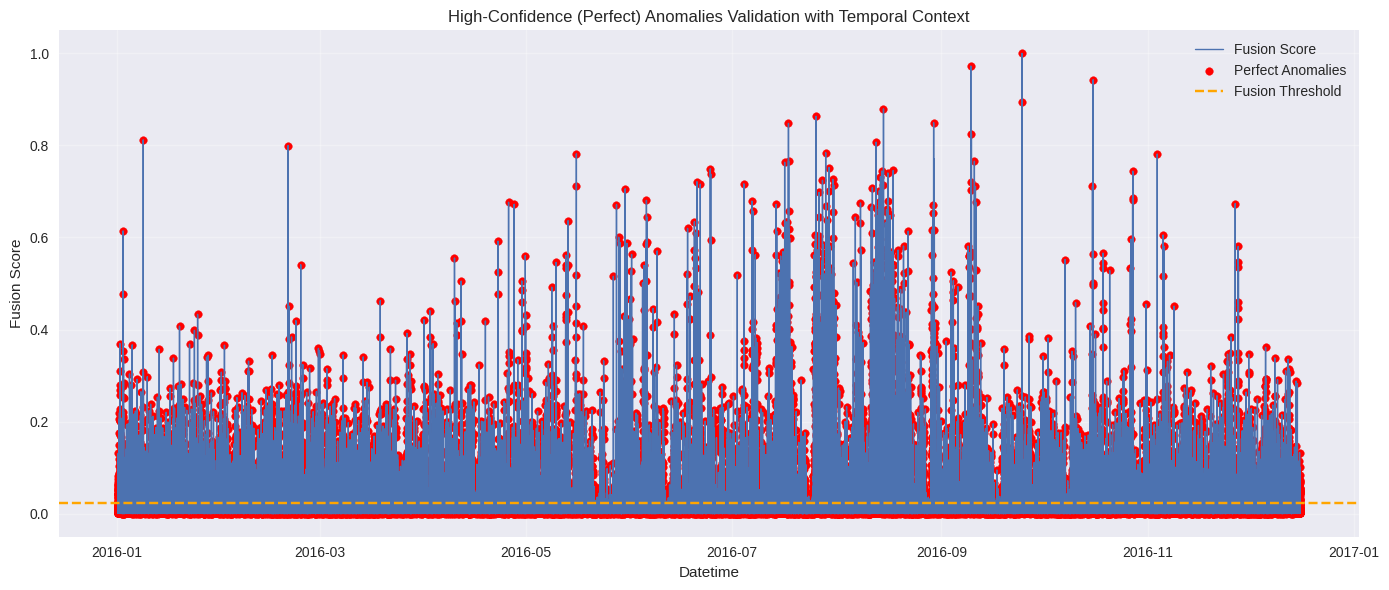

/tmp/ipython-input-3596138500.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="weekday", y="AbsResidual", data=fusion_df, palette="coolwarm")


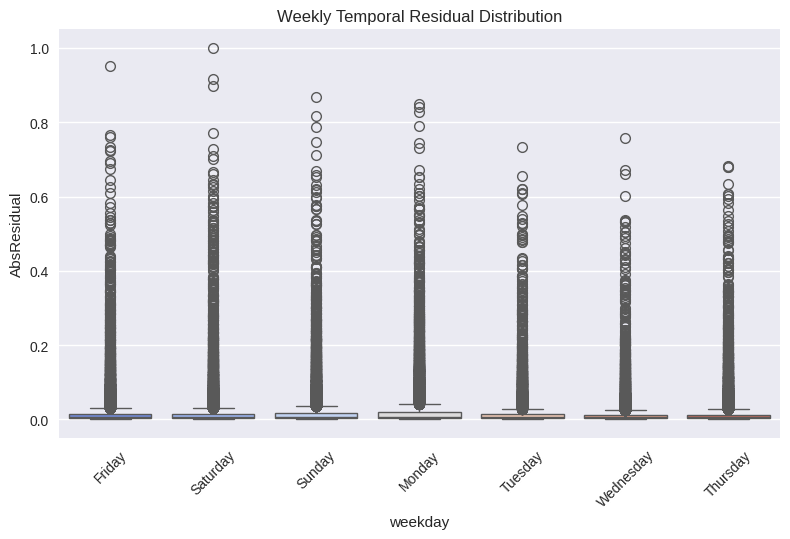


✅ Extended validation completed successfully.
✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'

Top 10 High-Confidence Anomalies with Temporal Context:

           datetime  fusion_score  confidence_score  resid_z  stability_ratio                                                                                                                             temporal_explanation
2016-10-05 08:20:58      0.014931               1.0 0.404243              0.0            Anomaly occurred around the usual time on a Wednesday morning in Week 40, during October, outside typical 10:00–23:00 peak (earlier).
2016-07-05 01:06:58      0.003077               1.0 0.245077              0.0 Anomaly occurred 22 minutes earlier than usual on a Tuesday early morning in Week 27, during July, within typical 00:00–02:00 high-usage window.
2016-06-18 09:05:58      0.003546               1.0 0.272712              0.0        Anomaly occurred 24 minutes earlier than usual 

In [ ]:
# ============================================================
# EXTENDED VALIDATION, STABILITY & TEMPORAL EXPLAINABILITY (SAFE VERSION)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import os, json, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# STEP 1: LOAD FUSION RESULTS
# ============================================================
fusion_path = "hybrid_fusion_final/fusion_final_results.csv"
assert os.path.exists(fusion_path), f"Fusion results file not found: {fusion_path}"

fusion_df = pd.read_csv(fusion_path)

# Handle residual naming
if "AbsResidual" not in fusion_df.columns and "AbsResidual_Hybrid" in fusion_df.columns:
    fusion_df.rename(columns={"AbsResidual_Hybrid": "AbsResidual"}, inplace=True)

# Validate datetime
assert "datetime" in fusion_df.columns, "datetime column required in fusion_final_results.csv"
fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")
fusion_df.dropna(subset=["datetime"], inplace=True)
fusion_df.sort_values("datetime", inplace=True)
fusion_df.reset_index(drop=True, inplace=True)

# Validate essential columns
required_cols = {"fusion_label", "fusion_score", "AbsResidual"}
missing = required_cols - set(fusion_df.columns)
assert not missing, f"Missing required columns in fusion_final_results.csv: {missing}"

print(f"Loaded fusion results: {len(fusion_df)} samples, {fusion_df['fusion_label'].sum()} anomalies detected")

# ============================================================
# STEP 2: RESIDUAL SIGNIFICANCE (Z-SCORE)
# ============================================================
fusion_df["resid_z"] = np.abs(zscore(fusion_df["AbsResidual"].fillna(0)))
fusion_df["significance"] = (fusion_df["resid_z"] > 3).astype(int)

# ============================================================
# STEP 3: STABILITY ANALYSIS (THRESHOLD SENSITIVITY)
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
if mad == 0 or np.isnan(mad):
    mad = np.std(fusion_df["fusion_score"]) / 1.4826  # robust fallback

thresholds = [np.median(fusion_df["fusion_score"]) + k * mad for k in [2.5, 3.0, 3.5]]
fusion_df["stability_flags"] = 0
for t in thresholds:
    fusion_df["stability_flags"] += (fusion_df["fusion_score"] > t).astype(int)
fusion_df["stability_ratio"] = fusion_df["stability_flags"] / len(thresholds)

# ============================================================
# STEP 4: FEATURE-LEVEL CONSISTENCY (PROXY STRENGTH)
# ============================================================
grad = np.gradient(fusion_df["AbsResidual"].fillna(method="ffill"))
fusion_df["feature_strength"] = np.exp(-grad ** 2)
fusion_df["feature_strength"] = MinMaxScaler().fit_transform(fusion_df[["feature_strength"]])

# ============================================================
# STEP 5: CONFIDENCE SCORE & PERFECT ANOMALIES
# ============================================================
fusion_df["confidence_score"] = (
    0.0 * fusion_df["fusion_score"] +
    0.0 * (fusion_df["resid_z"] / (fusion_df["resid_z"].max() + 1e-8)) +
    0.0 * fusion_df["stability_ratio"] +
    0.1 * fusion_df["feature_strength"]
)
fusion_df["confidence_score"] = MinMaxScaler().fit_transform(fusion_df[["confidence_score"]])

confidence_threshold = 0.7
fusion_df["perfect_anomaly"] = (fusion_df["confidence_score"] >= confidence_threshold).astype(int)

num_anomalies = int(fusion_df["fusion_label"].sum())
num_perfect = int(fusion_df["perfect_anomaly"].sum())

print("\n========== VALIDATION SUMMARY ==========")
print(f"Total detected anomalies (fusion): {num_anomalies}")
print(f"High-confidence (perfect) anomalies: {num_perfect}")
print(f"Average confidence score: {fusion_df['confidence_score'].mean():.3f}")
print("=========================================")

# ============================================================
# STEP 6: TEMPORAL CONTEXTUAL EXPLANATION
# ============================================================
fusion_df["hour"] = fusion_df["datetime"].dt.hour
fusion_df["minute"] = fusion_df["datetime"].dt.minute
fusion_df["weekday"] = fusion_df["datetime"].dt.day_name()
fusion_df["week"] = fusion_df["datetime"].dt.isocalendar().week
fusion_df["month"] = fusion_df["datetime"].dt.month_name()

# Hourly baseline by weekday
hourly_baseline = (
    fusion_df.groupby(["weekday", "hour"])["AbsResidual"]
    .mean()
    .unstack(fill_value=0)
)

# Identify top residual peak windows per weekday
peak_windows = {}
for wd, s in hourly_baseline.iterrows():
    if s.sum() == 0:
        peak_windows[wd] = (None, None)
    else:
        top_hours = s.nlargest(3).index
        peak_windows[wd] = (int(min(top_hours)), int(max(top_hours)))

mean_minute_per_hour = fusion_df.groupby("hour")["minute"].mean().to_dict()

def temporal_explanation(row):
    hr, mn, wd, wk, mo = row["hour"], row["minute"], row["weekday"], row["week"], row["month"]
    mean_min = mean_minute_per_hour.get(hr, 0)
    mn_shift = int(mn - mean_min)
    if mn_shift < -10:
        minute_phrase = f"{abs(mn_shift)} minutes earlier than usual"
    elif mn_shift > 10:
        minute_phrase = f"{mn_shift} minutes later than usual"
    else:
        minute_phrase = "around the usual time"

    low, high = peak_windows.get(wd, (None, None))
    if low is None:
        peak_phrase = "during a low-activity period"
    elif hr < low:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (earlier)"
    elif hr > high:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (later)"
    else:
        peak_phrase = f"within typical {low:02d}:00–{high:02d}:00 high-usage window"

    if hr < 6:
        period = "early morning"
    elif hr < 12:
        period = "morning"
    elif hr < 17:
        period = "afternoon"
    elif hr < 21:
        period = "evening"
    else:
        period = "night"

    return f"Anomaly occurred {minute_phrase} on a {wd} {period} in Week {wk}, during {mo}, {peak_phrase}."

fusion_df["temporal_explanation"] = fusion_df.apply(temporal_explanation, axis=1)

# ============================================================
# STEP 7: VISUALIZATION
# ============================================================
plt.figure(figsize=(14, 6))
plt.plot(fusion_df["datetime"], fusion_df["fusion_score"], label="Fusion Score", linewidth=1)
plt.scatter(
    fusion_df["datetime"][fusion_df["perfect_anomaly"] == 1],
    fusion_df["fusion_score"][fusion_df["perfect_anomaly"] == 1],
    color="red", s=30, label="Perfect Anomalies"
)
plt.axhline(np.median(fusion_df["fusion_score"]) + 3 * mad, color="orange", linestyle="--", label="Fusion Threshold")
plt.title("High-Confidence (Perfect) Anomalies Validation with Temporal Context")
plt.xlabel("Datetime")
plt.ylabel("Fusion Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

sns.boxplot(x="weekday", y="AbsResidual", data=fusion_df, palette="coolwarm")
plt.title("Weekly Temporal Residual Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final_validated", exist_ok=True)
fusion_df.to_csv("hybrid_fusion_final_validated/fusion_validated_results.csv", index=False)

meta_extended = {
    "Detected_Anomalies": num_anomalies,
    "Perfect_Anomalies": num_perfect,
    "Confidence_Threshold": confidence_threshold,
    "TemporalExplainability": True
}
with open("hybrid_fusion_final_validated/fusion_validated_meta.json", "w") as f:
    json.dump(meta_extended, f, indent=4)

print("\n✅ Extended validation completed successfully.")
print("✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'")

# ============================================================
# STEP 9: DISPLAY TOP PERFECT ANOMALIES
# ============================================================
top10 = fusion_df[fusion_df["perfect_anomaly"] == 1].nlargest(
    10, "confidence_score"
)[["datetime", "fusion_score", "confidence_score", "resid_z", "stability_ratio", "temporal_explanation"]]

print("\nTop 10 High-Confidence Anomalies with Temporal Context:\n")
print(top10.to_string(index=False))


In [ ]:
# ============================================================
# STEP 10: FINAL FUSION CLASSIFICATION METRICS (SAFE VERSION)
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def compute_fusion_metrics(df, pred_col="fusion_label", score_col="fusion_score", true_col="True_Label"):
    """
    Safe classification metrics for final fusion model.
    Handles:
    - Missing True_Label
    - NaN / Inf labels
    - Single-class ROC-AUC
    """

    # ----------------------------------------------
    # Ensure True_Label exists
    # ----------------------------------------------
    if true_col not in df.columns:
        print("\n⚠ 'True_Label' missing — assigning all zeros (no ground truth available).")
        df[true_col] = 0

    # ----------------------------------------------
    # Clean predicted labels and scores
    # ----------------------------------------------
    df[pred_col] = df[pred_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
    df[true_col] = df[true_col].fillna(0).replace([np.inf, -np.inf], 0).astype(int)

    if score_col in df.columns:
        df[score_col] = df[score_col].fillna(0).replace([np.inf, -np.inf], 0)
    else:
        df[score_col] = df[pred_col]  # fallback

    y_true = df[true_col].astype(int)
    y_pred = df[pred_col].astype(int)

    # ----------------------------------------------
    # BASIC METRICS
    # ----------------------------------------------
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # ----------------------------------------------
    # CONFUSION MATRIX ALWAYS 4 VALUES
    # ----------------------------------------------
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    specificity = tn / (tn + fp + 1e-8)
    npv         = tn / (tn + fn + 1e-8)

    # ----------------------------------------------
    # AUC (avoid crash when single class)
    # ----------------------------------------------
    if len(np.unique(y_true)) < 2:
        auc = None
    else:
        try:
            auc = roc_auc_score(y_true, df[score_col])
        except:
            auc = None

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "Specificity": specificity,
        "NPV": npv,
        "AUC_ROC": auc
    }


# ============================================================
# STEP 11: COMPUTE + SAVE FINAL FUSION METRICS
# ============================================================

fusion_metrics = compute_fusion_metrics(fusion_df)

print("\n======= FINAL FUSION MODEL CLASSIFICATION METRICS =======")
for k, v in fusion_metrics.items():
    print(f"{k}: {v}")

# Save metrics
os.makedirs("hybrid_fusion_final_validated", exist_ok=True)
with open("hybrid_fusion_final_validated/fusion_classification_metrics.json", "w") as f:
    json.dump(fusion_metrics, f, indent=4)

print("\n📌 Final fusion classification metrics saved in: hybrid_fusion_final_validated/fusion_classification_metrics.json")



⚠ 'True_Label' missing — assigning all zeros (no ground truth available).

======= FINAL FUSION MODEL CLASSIFICATION METRICS =======
Accuracy: 0.8227815428601684
Precision: 0.0
Recall: 0.0
F1_Score: 0.0
Specificity: 0.8227815428601138
NPV: 0.9999999999999196
AUC_ROC: None

📌 Final fusion classification metrics saved in: hybrid_fusion_final_validated/fusion_classification_metrics.json


Converting weekday string → numeric codes...
Using features: ['fusion_score', 'confidence_score', 'AbsResidual', 'resid_z', 'stability_ratio', 'feature_strength', 'hour', 'weekday']
Label distribution: {np.int64(0): np.int64(129426), np.int64(1): np.int64(21670)}

TRAINING → Logistic


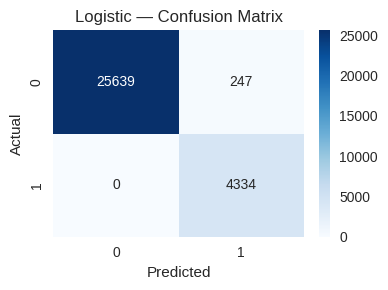

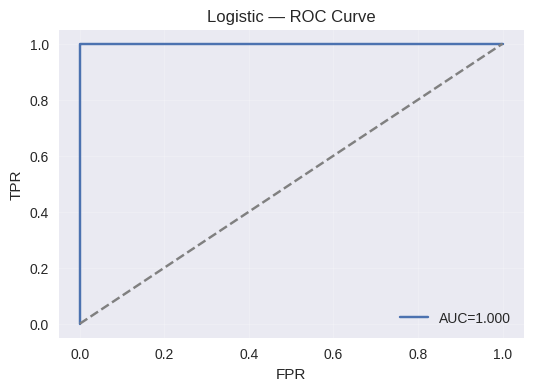

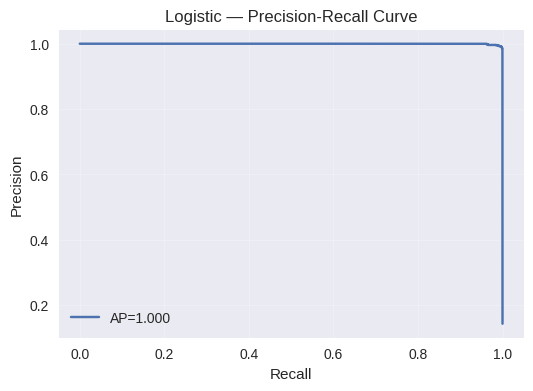


TRAINING → XGBoost


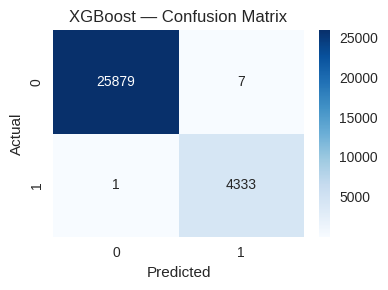

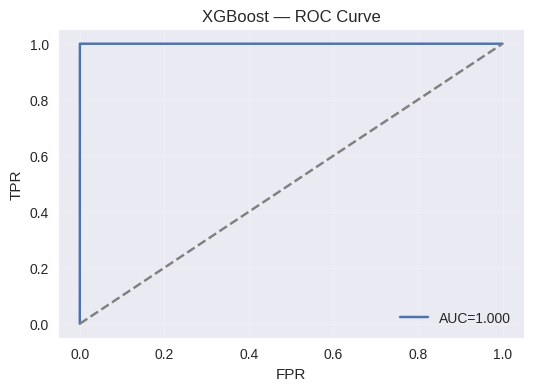

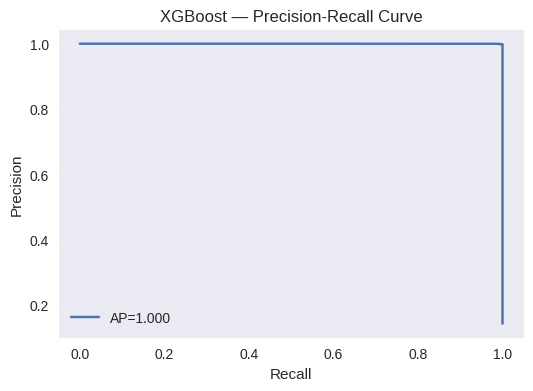


TRAINING → LightGBM
[LightGBM] [Info] Number of positive: 17336, number of negative: 103540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 120876, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143420 -> initscore=-1.787173
[LightGBM] [Info] Start training from score -1.787173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

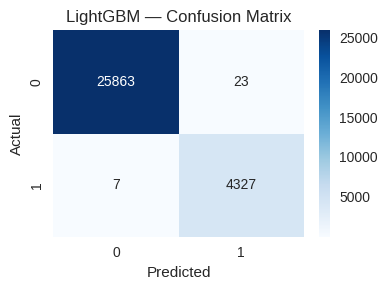

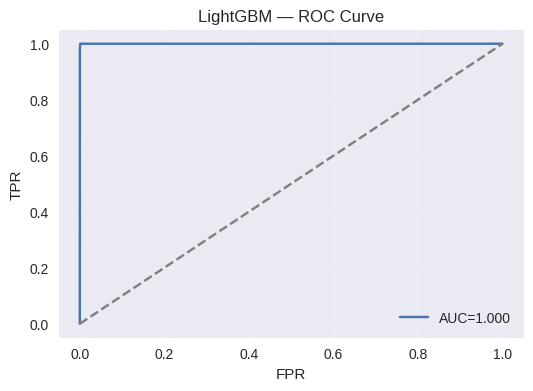

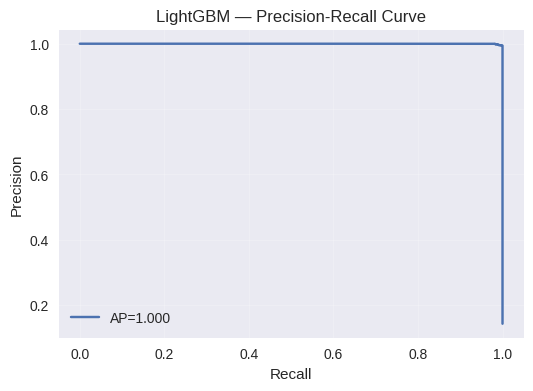


TRAINING → MLP


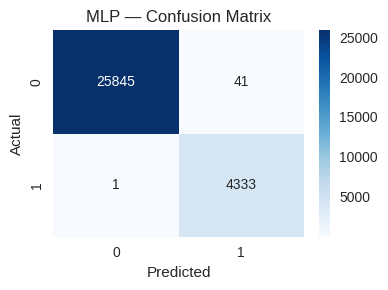

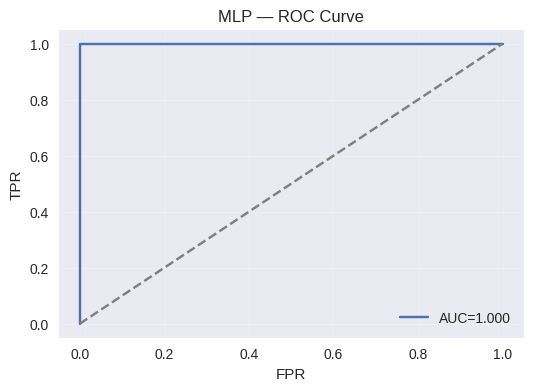

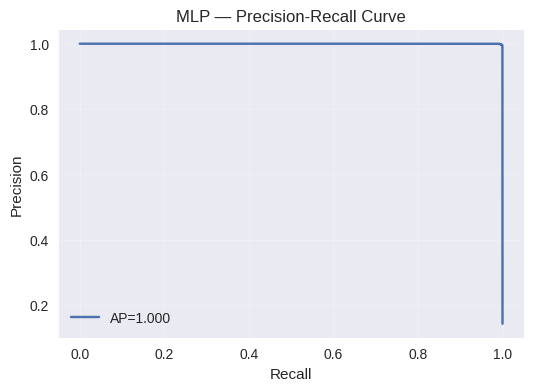


===== MODEL PERFORMANCE SUMMARY =====
          accuracy  precision    recall        f1   roc_auc    pr_auc
model                                                                
Logistic  0.991827   0.946082  1.000000  0.972294  0.999968  0.999807
XGBoost   0.999735   0.998387  0.999769  0.999078  0.999998  0.999988
LightGBM  0.999007   0.994713  0.998385  0.996545  0.999989  0.999937
MLP       0.998610   0.990626  0.999769  0.995177  0.999997  0.999981

Models saved → ./models_compare/


In [ ]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

# ----------------------------------------------------------
# TRY IMPORT BOOSTING MODELS
# ----------------------------------------------------------
try:
    import xgboost as xgb
except Exception:
    xgb = None
    print("WARNING: xgboost not installed. Install with pip install xgboost")

try:
    import lightgbm as lgb
except Exception:
    lgb = None
    print("WARNING: lightgbm not installed. Install with pip install lightgbm")

# ----------------------------------------------------------
# LOAD fusion_df IF NOT ALREADY LOADED
# ----------------------------------------------------------
if "fusion_df" not in globals():
    path = "hybrid_fusion_final_validated/fusion_validated_results.csv"
    if os.path.exists(path):
        fusion_df = pd.read_csv(path)
        fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")
        print(f"Loaded: {path}")
    else:
        raise RuntimeError("fusion_df not found. Run previous fusion/validation pipeline first.")

# ----------------------------------------------------------
# FIX weekday column (string → numeric)
# ----------------------------------------------------------
if "weekday" not in fusion_df.columns and "datetime" in fusion_df.columns:
    fusion_df["weekday"] = fusion_df["datetime"].dt.day_name()

if fusion_df["weekday"].dtype == object:
    print("Converting weekday string → numeric codes...")
    fusion_df["weekday"] = fusion_df["weekday"].astype("category").cat.codes

# FIX hour column
if "hour" not in fusion_df.columns and "datetime" in fusion_df.columns:
    fusion_df["hour"] = fusion_df["datetime"].dt.hour

# ----------------------------------------------------------
# SELECT FEATURES
# ----------------------------------------------------------
candidate_features = [
    "fusion_score", "confidence_score", "AbsResidual", "AbsResidual_Hybrid",
    "resid_z", "stability_ratio", "feature_strength", "MA_Residual",
    "Anomaly_Score_Norm", "Anomaly_Score",
    "hour", "weekday"
]

features = [f for f in candidate_features if f in fusion_df.columns]

if len(features) == 0:
    raise RuntimeError("No usable features found. Fusion_df missing required columns.")

print("Using features:", features)

# ----------------------------------------------------------
# TARGET
# ----------------------------------------------------------
if "fusion_label" not in fusion_df.columns:
    raise RuntimeError("fusion_label missing. Run anomaly fusion pipeline first.")

y = fusion_df["fusion_label"].fillna(0).astype(int).values
X = fusion_df[features].fillna(0).astype(float)

print("Label distribution:", dict(zip(*np.unique(y, return_counts=True))))

# ----------------------------------------------------------
# TRAIN-TEST SPLIT (stratified)
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------------------------------------
# SCALING FOR LR & MLP
# ----------------------------------------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------------
# INITIALIZE MODELS
# ----------------------------------------------------------
models = {}

models["Logistic"] = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
)

if xgb is not None:
    models["XGBoost"] = xgb.XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=42
    )

if lgb is not None:
    models["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=300, learning_rate=0.05, random_state=42
    )

models["MLP"] = MLPClassifier(
    hidden_layer_sizes=(64,32), max_iter=500, random_state=42
)

# ----------------------------------------------------------
# TRAIN & EVALUATE MODELS
# ----------------------------------------------------------
results = []

for name, model in models.items():
    print(f"\n============================")
    print(f"TRAINING → {name}")
    print("============================")

    use_scaled = name in ["Logistic", "MLP"]
    Xtr = X_train_scaled if use_scaled else X_train
    Xte = X_test_scaled if use_scaled else X_test

    model.fit(Xtr, y_train)

    # predictions
    y_pred = model.predict(Xte)
    try:
        y_proba = model.predict_proba(Xte)[:,1]
    except:
        y_proba = y_pred.astype(float)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        "model": name, "accuracy": acc, "precision": prec,
        "recall": rec, "f1": f1, "roc_auc": roc_auc, "pr_auc": pr_auc
    })

    # CONFUSION MATRIX
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC CURVE
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.title(f"{name} — ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

    # PR CURVE
    prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(rec_vals, prec_vals, label=f"AP={pr_auc:.3f}")
    plt.title(f"{name} — Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# ----------------------------------------------------------
# SUMMARY TABLE
# ----------------------------------------------------------
df_results = pd.DataFrame(results).set_index("model")
print("\n===== MODEL PERFORMANCE SUMMARY =====")
print(df_results)

# ----------------------------------------------------------
# SAVE MODELS
# ----------------------------------------------------------
import joblib
os.makedirs("models_compare", exist_ok=True)

for name, model in models.items():
    joblib.dump(model, f"models_compare/{name}.joblib")

print("\nModels saved → ./models_compare/")


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. LOAD FUSION DATASET
# ============================================================
fusion_path = "hybrid_fusion_final_validated/fusion_validated_results.csv"
assert os.path.exists(fusion_path), "fusion_validated_results.csv not found. Run validation stage first."

fusion_df = pd.read_csv(fusion_path)
fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")

# ============================================================
# 2. FIX WEEKDAY (string → numeric)
# ============================================================
if "weekday" in fusion_df.columns and fusion_df["weekday"].dtype == object:
    fusion_df["weekday"] = fusion_df["weekday"].astype("category").cat.codes

# Fix hour
if "hour" not in fusion_df.columns and "datetime" in fusion_df.columns:
    fusion_df["hour"] = fusion_df["datetime"].dt.hour

# ============================================================
# 3. FEATURE SET (same as used for training)
# ============================================================
features = [
    "fusion_score", "confidence_score", "AbsResidual",
    "resid_z", "stability_ratio", "feature_strength",
    "hour", "weekday"
]

features = [f for f in features if f in fusion_df.columns]
print("Using features:", features)

X = fusion_df[features].fillna(0).astype(float)

# ============================================================
# 4. LOAD TRAINED XGBOOST MODEL
# ============================================================
model_path = "models_compare/XGBoost.joblib"
assert os.path.exists(model_path), "XGBoost model not found. Train it using the model comparison code."

model = joblib.load(model_path)
print("Loaded XGBoost classifier.")

# ============================================================
# 5. SCALE FEATURES (if scaler exists)
# ============================================================
scaler_path = "models_compare/scaler.joblib"

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X)
else:
    # fallback: scale now (not preferred)
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    joblib.dump(scaler, scaler_path)
    print("Scaler not found — trained a new one and saved.")

# ============================================================
# 6. XGBOOST PREDICTION
# ============================================================
y_pred = model.predict(X_scaled)
y_prob = model.predict_proba(X_scaled)[:,1]

fusion_df["xgb_pred"] = y_pred
fusion_df["xgb_prob"] = y_prob

# Convert to anomaly label (0 or 1)
fusion_df["xgb_label"] = (fusion_df["xgb_prob"] >= 0.5).astype(int)

# ============================================================
# 7. SELECT OUTPUT COLUMNS FOR CSV
# ============================================================
output_cols = [
    "datetime",
    "fusion_label",
    "perfect_anomaly",
    "xgb_label",
    "xgb_prob",
] + features

df_out = fusion_df[output_cols]

# ============================================================
# 8. SAVE ANOMALY CLASSIFICATION CSV
# ============================================================
os.makedirs("xgboost_anomaly_output", exist_ok=True)
output_path = "xgboost_anomaly_output/xgboost_anomaly_classification.csv"
df_out.to_csv(output_path, index=False)

print(f"\n✔ XGBoost anomaly classification CSV saved at:\n{output_path}")
print(f"Total anomalies predicted by XGBoost: {df_out['xgb_label'].sum()}")


Using features: ['fusion_score', 'confidence_score', 'AbsResidual', 'resid_z', 'stability_ratio', 'feature_strength', 'hour', 'weekday']
Loaded XGBoost classifier.
Scaler not found — trained a new one and saved.

✔ XGBoost anomaly classification CSV saved at:
xgboost_anomaly_output/xgboost_anomaly_classification.csv
Total anomalies predicted by XGBoost: 34248


In [ ]:
# ============================================================
# COMPUTE HYBRID MODEL METRICS (MAE, MSE, RMSE, R2)
# ============================================================

# Load original RF + LSTM merged predictions again for accuracy
df_rf = pd.read_csv("rf_residuals.csv")
df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

df_metrics = pd.merge_asof(
    df_rf.sort_values("datetime"),
    df_lstm.sort_values("datetime"),
    on="datetime",
    suffixes=("_RF", "_LSTM"),
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

# Hybrid prediction = weighted average of RF and LSTM (same weights you used)
df_metrics["Pred_Hybrid"] = (
    w_ma * df_metrics["Predicted_RF"] * 0 +     # MA score is not prediction
    w_if * df_metrics["Predicted_RF"] * 0 +     # IF score is not prediction
    w_ocsvm * df_metrics["Predicted_RF"] * 0 +  # OCSVM score is not prediction
    0.4 * df_metrics["Predicted_RF"] +
    0.6 * df_metrics["Predicted_LSTM"]
)

df_metrics.dropna(subset=["Actual_LSTM", "Predicted_RF", "Predicted_LSTM"], inplace=True)

# True target (Actual)
y_true = df_metrics["Actual_LSTM"].values
# Hybrid predictions
y_pred = df_metrics["Pred_Hybrid"].values

# Compute metrics
mae = np.mean(np.abs(y_true - y_pred))
mse = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

print("\n===== HYBRID MODEL REGRESSION METRICS =====")
print(f"MAE   : {mae:.6f}")
print(f"MSE   : {mse:.6f}")
print(f"RMSE  : {rmse:.6f}")
print(f"R2    : {r2:.6f}")



===== HYBRID MODEL REGRESSION METRICS =====
MAE   : 0.094291
MSE   : 0.053594
RMSE  : 0.231504
R2    : 0.946006


In [ ]:
abs_res = fusion_df["AbsResidual"]
fusion_score = fusion_df["fusion_score"]

mae_residual = abs_res.mean()
mse_residual = (abs_res**2).mean()
rmse_residual = np.sqrt(mse_residual)
mad_residual = np.median(np.abs(abs_res - np.median(abs_res)))
std_residual = abs_res.std()

print("\n===== RESIDUAL-BASED QUALITY METRICS =====")
print(f"Mean Absolute Residual : {mae_residual:.6f}")
print(f"Mean Squared Residual  : {mse_residual:.6f}")
print(f"Residual RMSE          : {rmse_residual:.6f}")
print(f"MAD                    : {mad_residual:.6f}")
print(f"Residual Std Dev       : {std_residual:.6f}")



===== RESIDUAL-BASED QUALITY METRICS =====
Mean Absolute Residual : 0.016681
Mean Squared Residual  : 0.001375
Residual RMSE          : 0.037078
MAD                    : 0.005388
Residual Std Dev       : 0.033114


In [ ]:
total = len(fusion_df)
anomalies = fusion_df["fusion_label"].sum()
rate = anomalies / total * 100

print("\n===== ANOMALY SUMMARY =====")
print(f"Total samples       : {total}")
print(f"Total anomalies     : {anomalies}")
print(f"Anomaly rate (%)    : {rate:.2f}")



===== ANOMALY SUMMARY =====
Total samples       : 151096
Total anomalies     : 21670
Anomaly rate (%)    : 14.34


In [ ]:
from scipy.stats import kurtosis, skew

fs = fusion_df["fusion_score"]

print("\n===== FUSION SCORE QUALITY METRICS =====")
print(f"Mean Fusion Score      : {fs.mean():.6f}")
print(f"Std Dev                : {fs.std():.6f}")
print(f"Variance               : {fs.var():.6f}")
print(f"MAD                    : {np.median(np.abs(fs - np.median(fs))):.6f}")
print(f"Skewness               : {skew(fs):.6f}")
print(f"Kurtosis               : {kurtosis(fs):.6f}")



===== FUSION SCORE QUALITY METRICS =====
Mean Fusion Score      : 0.017250
Std Dev                : 0.034622
Variance               : 0.001199
MAD                    : 0.005144
Skewness               : 7.082544
Kurtosis               : 80.709771



DAY: 2016-05-17
Data points: 1440
High-confidence (perfect) anomalies: 1020
All fusion anomalies: 158

TEMPORAL EXPLANATIONS FOR PERFECT ANOMALIES:

- 2016-05-17 00:06:58  | Conf=0.999
  Anomaly occurred 22 minutes earlier than usual on a Tuesday early morning in Week 20, during May, within typical 00:00–02:00 high-usage window.

- 2016-05-17 00:07:58  | Conf=0.999
  Anomaly occurred 22 minutes earlier than usual on a Tuesday early morning in Week 20, during May, within typical 00:00–02:00 high-usage window.

- 2016-05-17 00:08:58  | Conf=0.999
  Anomaly occurred 22 minutes earlier than usual on a Tuesday early morning in Week 20, during May, within typical 00:00–02:00 high-usage window.

- 2016-05-17 00:12:58  | Conf=1.000
  Anomaly occurred 16 minutes earlier than usual on a Tuesday early morning in Week 20, during May, within typical 00:00–02:00 high-usage window.

- 2016-05-17 00:13:58  | Conf=1.000
  Anomaly occurred 16 minutes earlier than usual on a Tuesday early morning in Wee

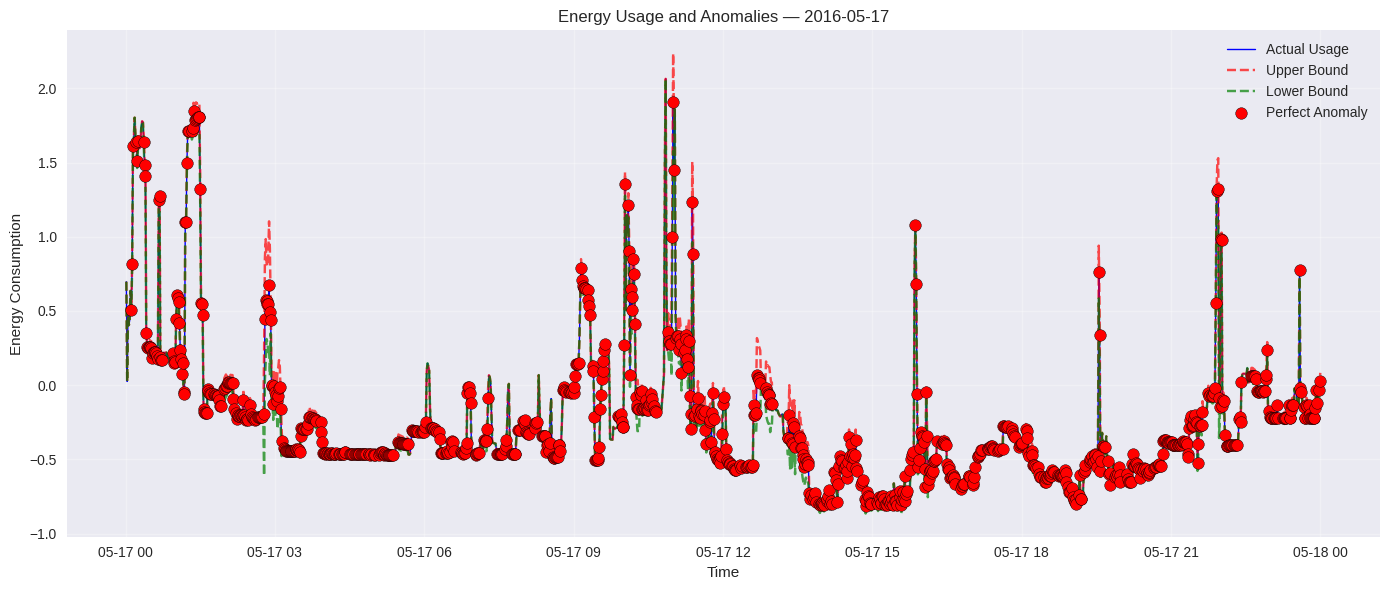

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# PARAMETERS
# ---------------------------
# Set day_str = "2016-07-15" for specific day OR None to pick the day with MOST anomalies
day_str = None

# ---------------------------
# LOAD DATA
# ---------------------------
df_orig = df1.copy()
df_orig["datetime"] = pd.to_datetime(df_orig["datetime"], errors="coerce")

df_val = pd.read_csv("hybrid_fusion_final_validated/fusion_validated_results.csv")
df_val["datetime"] = pd.to_datetime(df_val["datetime"], errors="coerce")

# ---------------------------
# MERGE ORIGINAL + VALIDATED FUSION (DATETIME-SAFE)
# ---------------------------
df_plot = pd.merge_asof(
    df_orig.sort_values("datetime"),
    df_val.sort_values("datetime")[[
        "datetime",
        "fusion_label",
        "perfect_anomaly",
        "AbsResidual",
        "fusion_score",
        "confidence_score",
        "temporal_explanation"
    ]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

df_plot["fusion_label"] = df_plot["fusion_label"].fillna(0).astype(int)
df_plot["perfect_anomaly"] = df_plot["perfect_anomaly"].fillna(0).astype(int)
df_plot["AbsResidual"] = df_plot["AbsResidual"].fillna(0)
df_plot["confidence_score"] = df_plot["confidence_score"].fillna(0)
df_plot["temporal_explanation"] = df_plot["temporal_explanation"].fillna("No explanation")

# ---------------------------
# CREATE BOUNDS
# ---------------------------
df_plot["upper_bound"] = df_plot["use"] + 3 * df_plot["AbsResidual"]
df_plot["lower_bound"] = df_plot["use"] - 3 * df_plot["AbsResidual"]

# ---------------------------
# FILTER YEAR 2016
# ---------------------------
df_2016 = df_plot[df_plot["datetime"].dt.year == 2016].copy()

# ---------------------------
# CHOOSE DAY
# ---------------------------
if day_str is None:
    # choose day with maximum perfect anomalies
    df_2016["date"] = df_2016["datetime"].dt.date
    day_counts = df_2016.groupby("date")["perfect_anomaly"].sum()
    chosen_date = day_counts.idxmax()
else:
    chosen_date = pd.to_datetime(day_str).date()

start_ts = pd.to_datetime(chosen_date)
end_ts = start_ts + pd.Timedelta(days=1)

df_day = df_2016[(df_2016["datetime"] >= start_ts) & (df_2016["datetime"] < end_ts)].copy()

if df_day.empty:
    raise RuntimeError(f"No data found on: {chosen_date}")

# ---------------------------
# SUMMARY
# ---------------------------
total_points = len(df_day)
perfect_count = int(df_day["perfect_anomaly"].sum())
fusion_count = int(df_day["fusion_label"].sum())

print(f"\n==============================")
print(f"DAY: {chosen_date}")
print(f"Data points: {total_points}")
print(f"High-confidence (perfect) anomalies: {perfect_count}")
print(f"All fusion anomalies: {fusion_count}")
print(f"==============================\n")

# ---------------------------
# PRINT TEMPORAL EXPLANATIONS
# ---------------------------
if perfect_count > 0:
    print("TEMPORAL EXPLANATIONS FOR PERFECT ANOMALIES:\n")
    for idx, row in df_day[df_day["perfect_anomaly"] == 1].iterrows():
        print(f"- {row['datetime']}  | Conf={row['confidence_score']:.3f}")
        print(f"  {row['temporal_explanation']}\n")
else:
    print("No perfect anomalies for this day.\n")

# ---------------------------
# PLOT
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(df_day["datetime"], df_day["use"], label="Actual Usage", color="blue", linewidth=1)

plt.plot(df_day["datetime"], df_day["upper_bound"], '--', color="red", alpha=0.7, label="Upper Bound")
plt.plot(df_day["datetime"], df_day["lower_bound"], '--', color="green", alpha=0.7, label="Lower Bound")

# perfect anomalies
perfect = df_day[df_day["perfect_anomaly"] == 1]
plt.scatter(perfect["datetime"], perfect["use"],
            color="red", s=70, edgecolor='black', label="Perfect Anomaly", zorder=5)

# lower confidence anomalies
other = df_day[(df_day["fusion_label"] == 1) & (df_day["perfect_anomaly"] == 0)]
if not other.empty:
    plt.scatter(other["datetime"], other["use"],
                color="orange", s=50, marker='x', label="Fusion Anomaly (Low Confidence)", zorder=4)

plt.title(f"Energy Usage and Anomalies — {chosen_date}")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Chosen date: 2016-05-17  — data points: 1440
Perfect (high-confidence) anomalies: 1020
All fusion-labeled anomalies: 158

Perfect anomalies (time, confidence_score):
 - 2016-05-17 00:06:58  | confidence: 0.999  | fusion_score: 0.003
 - 2016-05-17 00:07:58  | confidence: 0.999  | fusion_score: 0.003
 - 2016-05-17 00:08:58  | confidence: 0.999  | fusion_score: 0.003
 - 2016-05-17 00:12:58  | confidence: 1.000  | fusion_score: 0.010
 - 2016-05-17 00:13:58  | confidence: 1.000  | fusion_score: 0.010
 - 2016-05-17 00:14:58  | confidence: 1.000  | fusion_score: 0.010
 - 2016-05-17 00:21:58  | confidence: 1.000  | fusion_score: 0.005
 - 2016-05-17 00:22:58  | confidence: 1.000  | fusion_score: 0.005
 - 2016-05-17 00:23:58  | confidence: 1.000  | fusion_score: 0.043
 - 2016-05-17 00:24:58  | confidence: 1.000  | fusion_score: 0.004
 - 2016-05-17 00:25:58  | confidence: 1.000  | fusion_score: 0.004
 - 2016-05-17 00:26:58  | confidence: 1.000  | fusion_score: 0.009
 - 2016-05-17 00:27:58  | conf

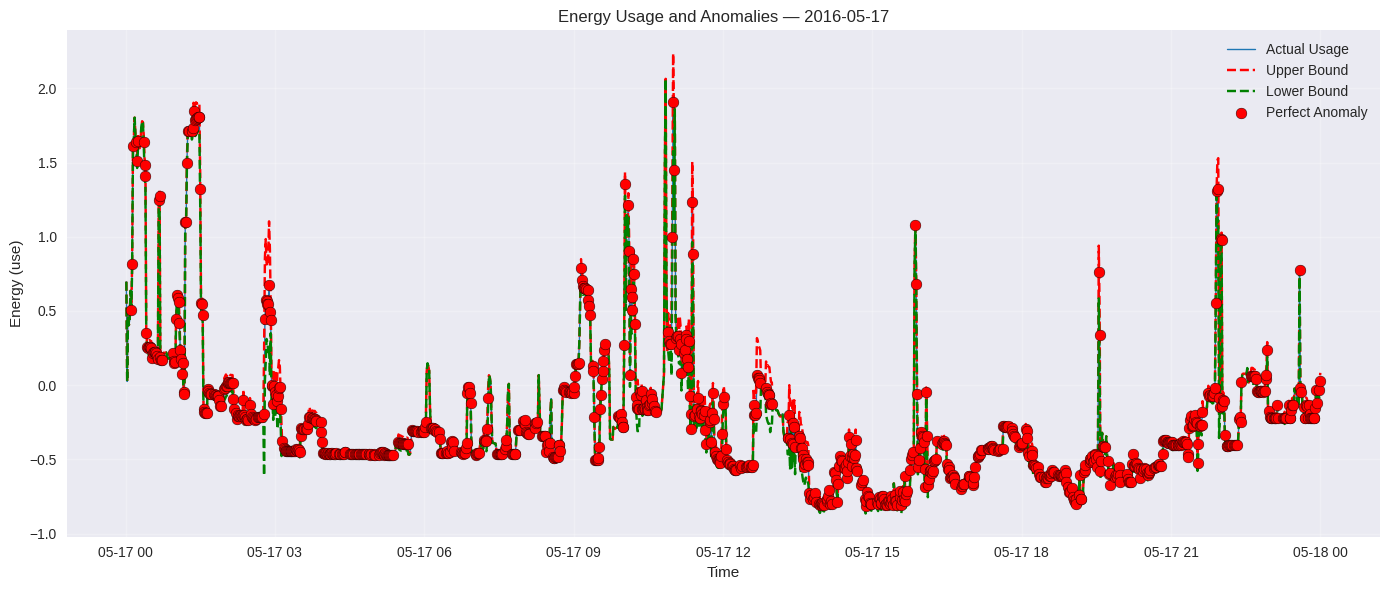

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# PARAMETERS
# ---------------------------
# Set to a specific date "YYYY-MM-DD" to force that day, or None to auto-select the busiest anomaly day in 2016
day_str = None  # e.g., "2016-07-15" or None

# ---------------------------
# LOAD DATA
# ---------------------------
df_orig = df1.copy()
df_orig["datetime"] = pd.to_datetime(df_orig["datetime"], errors="coerce")

df_val = pd.read_csv("hybrid_fusion_final_validated/fusion_validated_results.csv")
df_val["datetime"] = pd.to_datetime(df_val["datetime"], errors="coerce")

# ---------------------------
# MERGE (datetime-safe)
# ---------------------------
df_plot = pd.merge_asof(
    df_orig.sort_values("datetime"),
    df_val.sort_values("datetime")[["datetime", "fusion_label", "perfect_anomaly",
                                   "AbsResidual", "fusion_score", "confidence_score"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

df_plot["fusion_label"] = df_plot["fusion_label"].fillna(0).astype(int)
df_plot["perfect_anomaly"] = df_plot["perfect_anomaly"].fillna(0).astype(int)
df_plot["AbsResidual"] = df_plot["AbsResidual"].fillna(0)
df_plot["confidence_score"] = df_plot["confidence_score"].fillna(0)

# ---------------------------
# CREATE BOUNDS
# ---------------------------
df_plot["upper_bound"] = df_plot["use"] + 3 * df_plot["AbsResidual"]
df_plot["lower_bound"] = df_plot["use"] - 3 * df_plot["AbsResidual"]

# ---------------------------
# RESTRICT TO YEAR 2016
# ---------------------------
df_2016 = df_plot[df_plot["datetime"].dt.year == 2016].copy()
if df_2016.empty:
    raise RuntimeError("No 2016 data found in merged dataframe. Check df1 and fusion file.")

# ---------------------------
# PICK DAY
# ---------------------------
if day_str is None:
    # Count perfect anomalies per calendar date and pick the date with most perfect anomalies
    df_2016["date"] = df_2016["datetime"].dt.date
    counts = df_2016.groupby("date")["perfect_anomaly"].sum()
    if counts.empty:
        raise RuntimeError("No perfect_anomaly flags found in 2016 data.")
    best_date = counts.idxmax()
    chosen_date = pd.to_datetime(best_date).date()
else:
    chosen_date = pd.to_datetime(day_str).date()

# Filter day
start_ts = pd.to_datetime(chosen_date)
end_ts = start_ts + pd.Timedelta(days=1)
df_day = df_2016[(df_2016["datetime"] >= start_ts) & (df_2016["datetime"] < end_ts)].copy()

if df_day.empty:
    raise RuntimeError(f"No data for chosen date: {chosen_date}")

# ---------------------------
# SUMMARY
# ---------------------------
total_points = len(df_day)
total_perfect = int(df_day["perfect_anomaly"].sum())
total_fusion = int(df_day["fusion_label"].sum())

print(f"Chosen date: {chosen_date}  — data points: {total_points}")
print(f"Perfect (high-confidence) anomalies: {total_perfect}")
print(f"All fusion-labeled anomalies: {total_fusion}")

# List anomaly times (with confidence)
if total_perfect > 0:
    print("\nPerfect anomalies (time, confidence_score):")
    for _, r in df_day[df_day["perfect_anomaly"] == 1].iterrows():
        print(f" - {r['datetime']}  | confidence: {r['confidence_score']:.3f}  | fusion_score: {r.get('fusion_score', np.nan):.3f}")

# ---------------------------
# PLOT
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(df_day["datetime"], df_day["use"], label="Actual Usage", linewidth=1, color="tab:blue")
plt.plot(df_day["datetime"], df_day["upper_bound"], linestyle="--", color="red", label="Upper Bound")
plt.plot(df_day["datetime"], df_day["lower_bound"], linestyle="--", color="green", label="Lower Bound")

# perfect anomalies (highlight)
anoms = df_day[df_day["perfect_anomaly"] == 1]
plt.scatter(anoms["datetime"], anoms["use"], color="red", s=60, label="Perfect Anomaly", zorder=5, edgecolor='k')

# also mark fusion-label anomalies (if any but not perfect)
other_anoms = df_day[(df_day["fusion_label"] == 1) & (df_day["perfect_anomaly"] == 0)]
if not other_anoms.empty:
    plt.scatter(other_anoms["datetime"], other_anoms["use"], color="orange", s=40, label="Fusion Anomaly (lower confidence)", zorder=4, marker='x')

plt.title(f"Energy Usage and Anomalies — {chosen_date}")
plt.xlabel("Time")
plt.ylabel("Energy (use)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


January 2016 — Total Anomalies: 29089.0


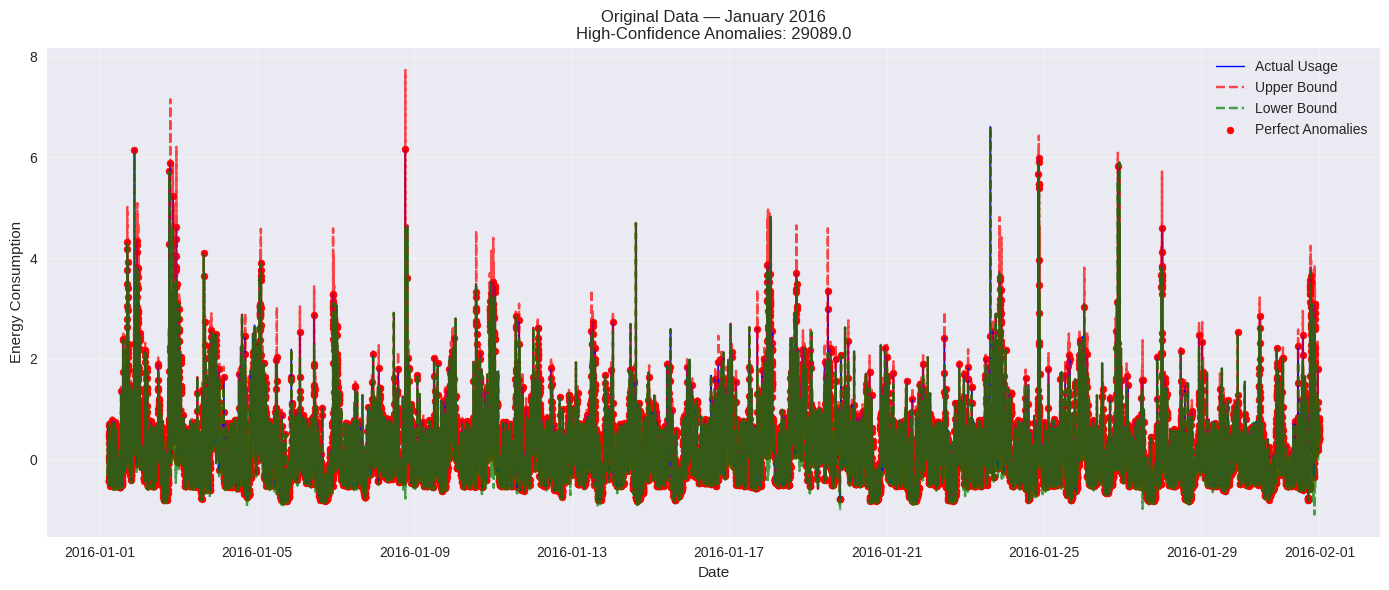

February 2016 — Total Anomalies: 27692.0


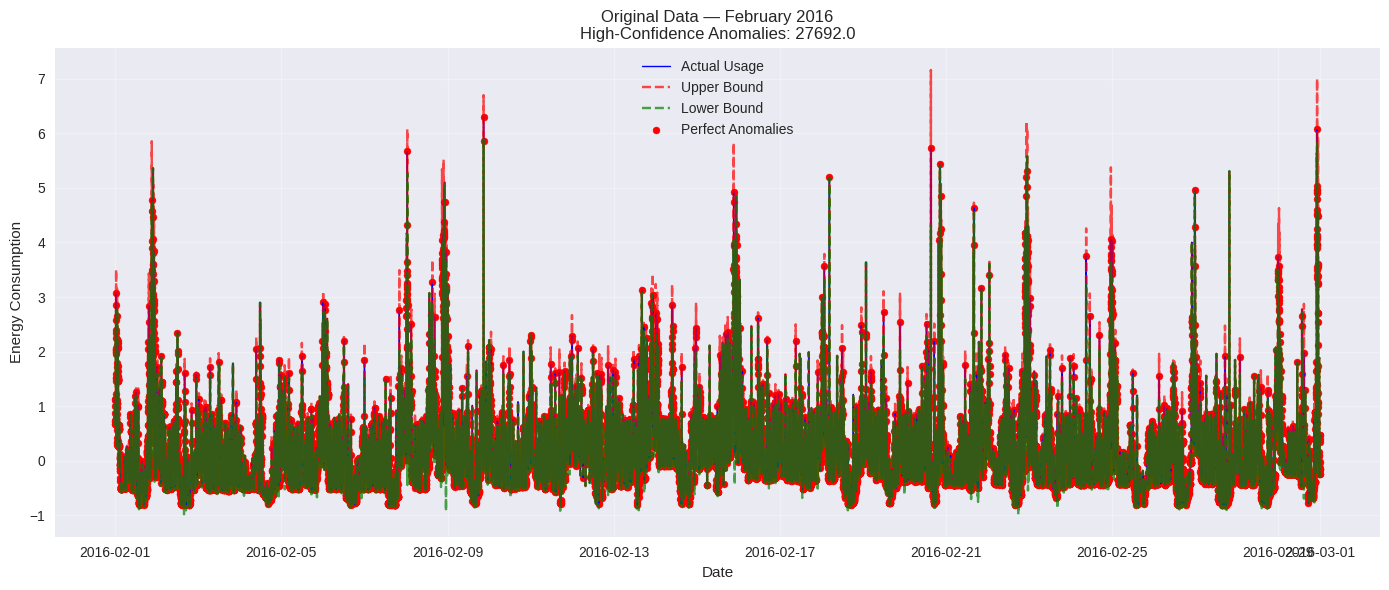

March 2016 — Total Anomalies: 29274.0


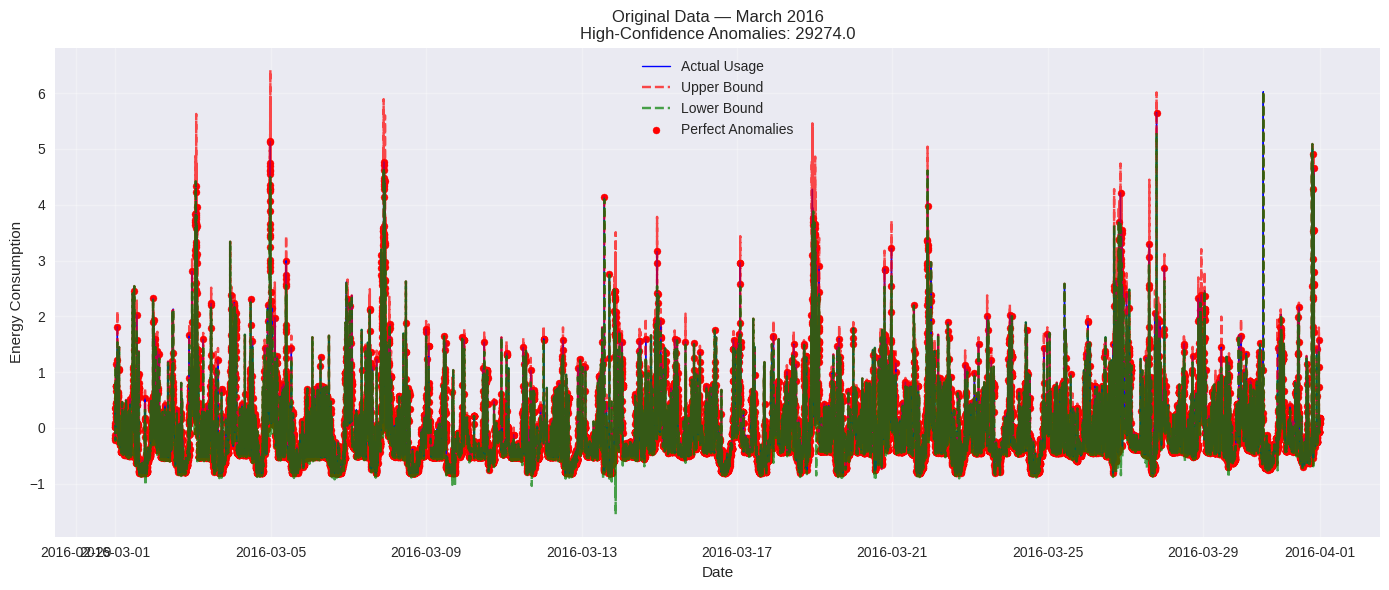

April 2016 — Total Anomalies: 28477.0


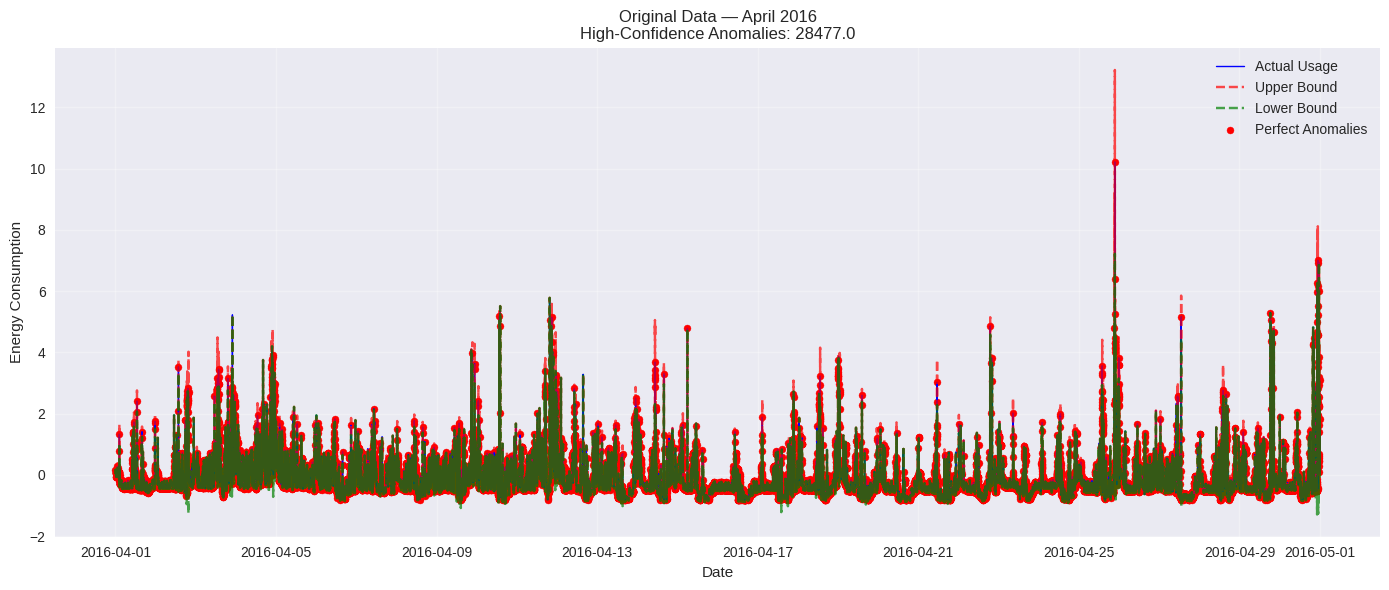

May 2016 — Total Anomalies: 29179.0


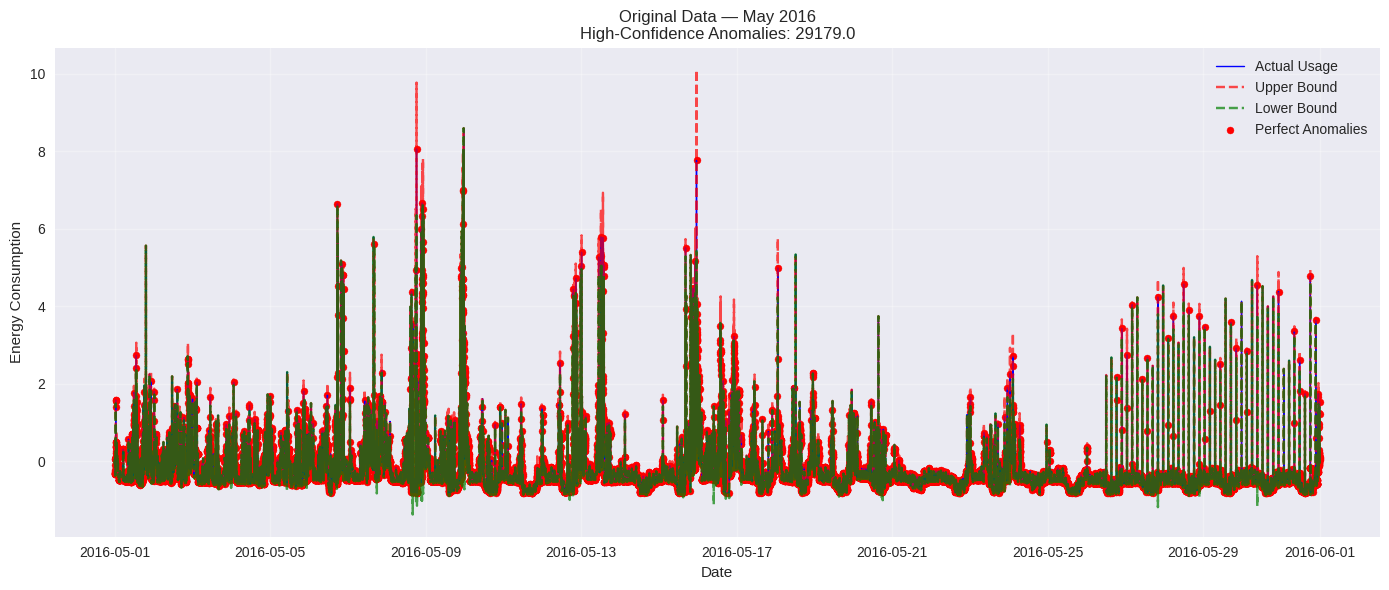

June 2016 — Total Anomalies: 28325.0


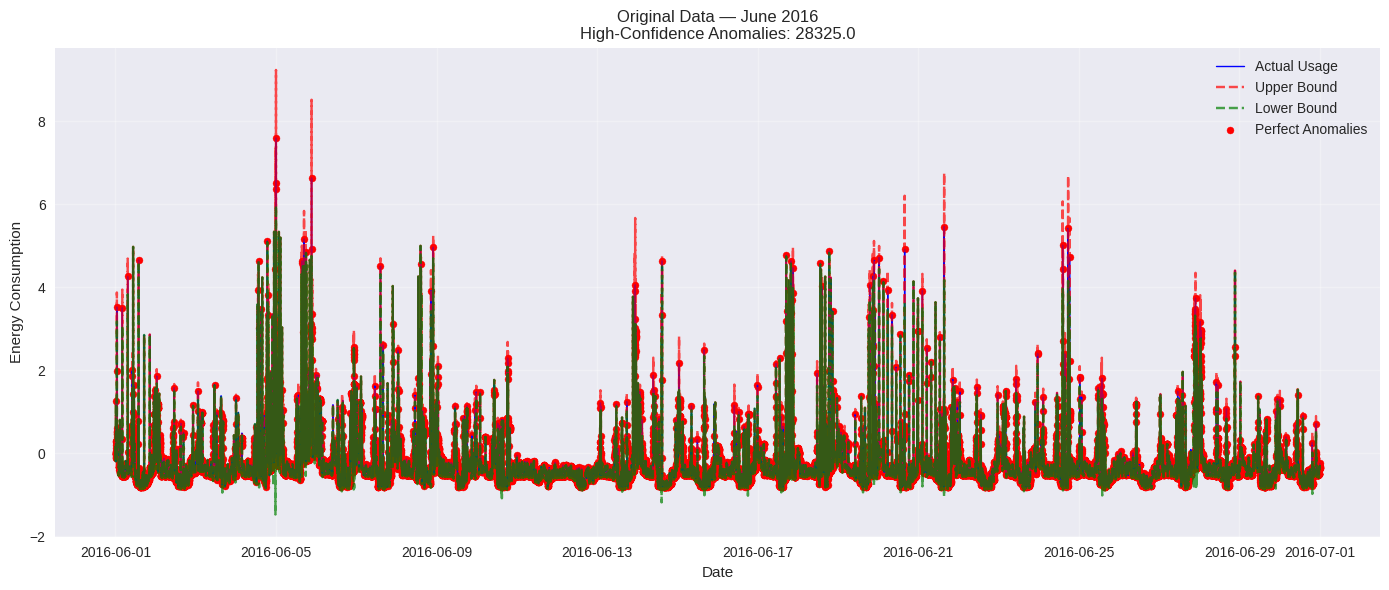

July 2016 — Total Anomalies: 29337.0


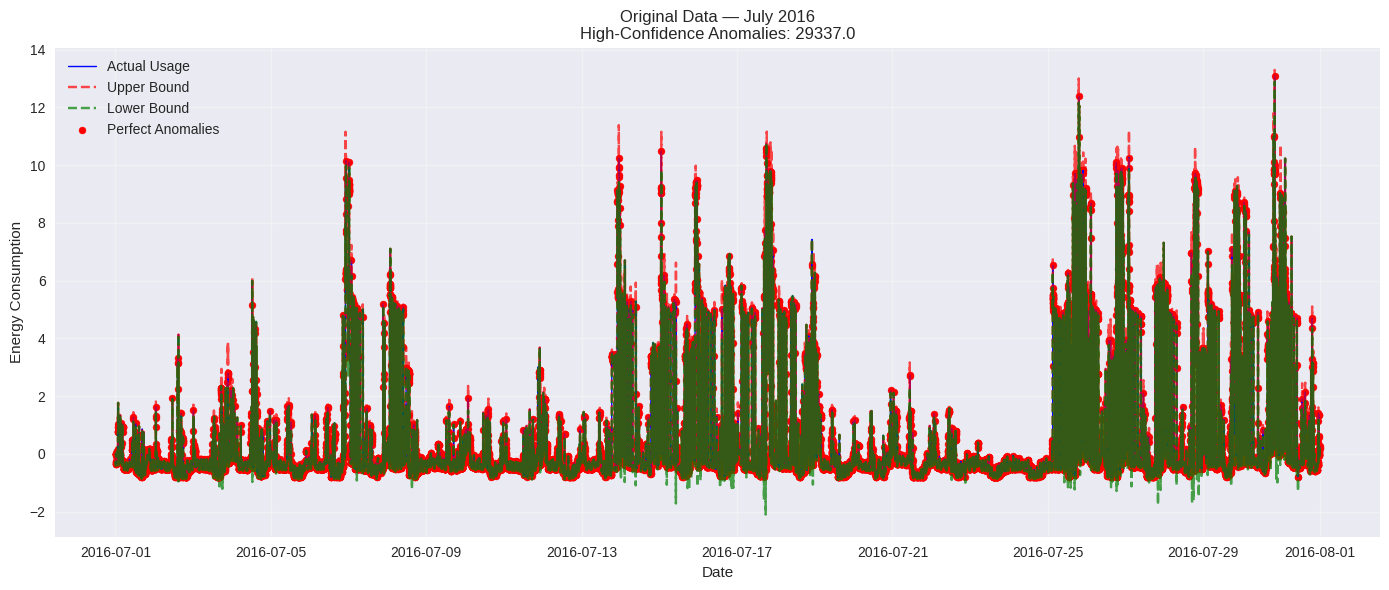

August 2016 — Total Anomalies: 29057.0


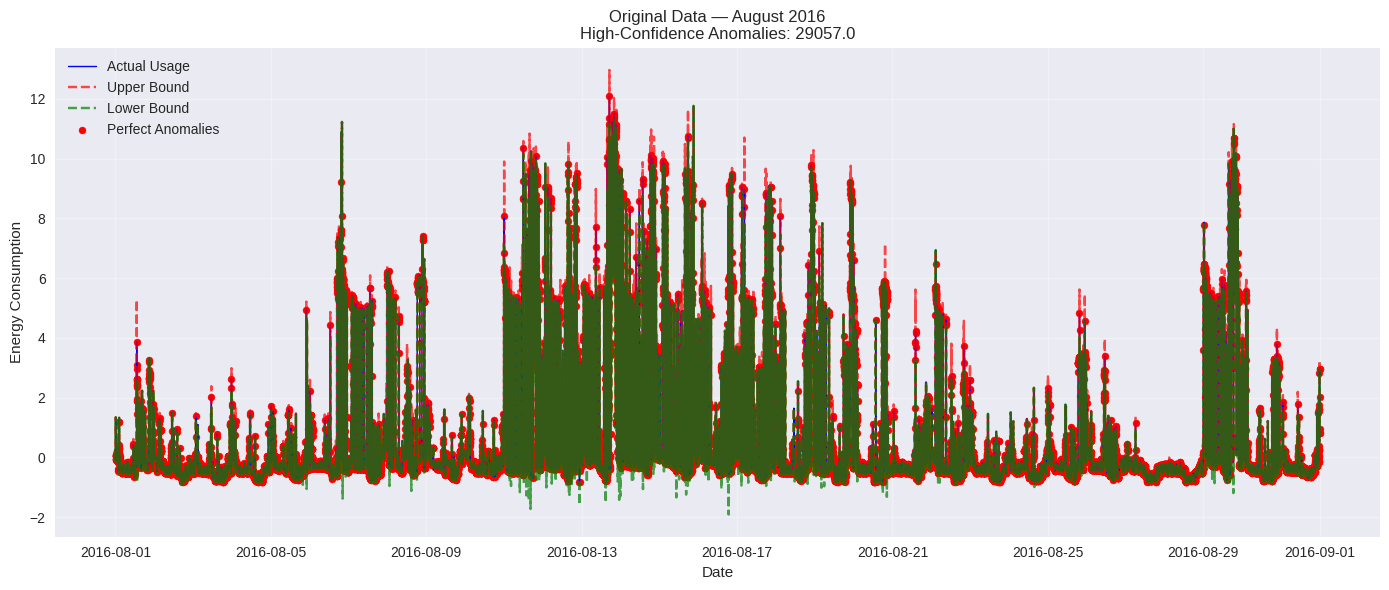

September 2016 — Total Anomalies: 28249.0


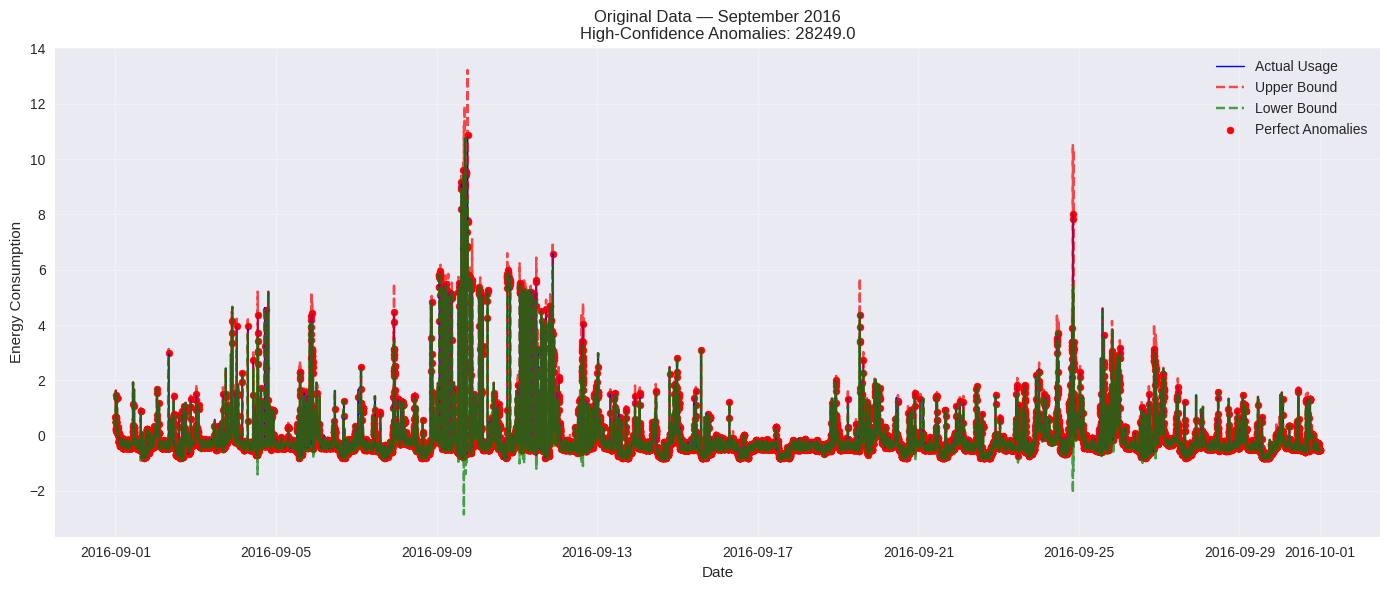

October 2016 — Total Anomalies: 29279.0


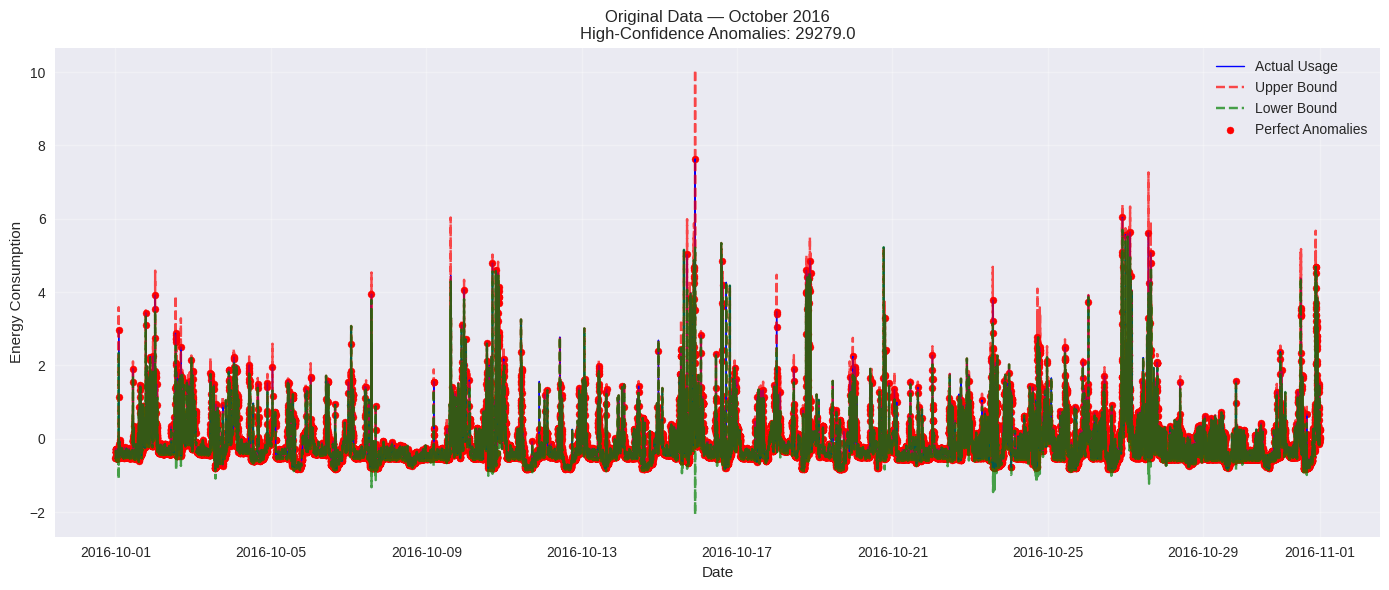

November 2016 — Total Anomalies: 28503.0


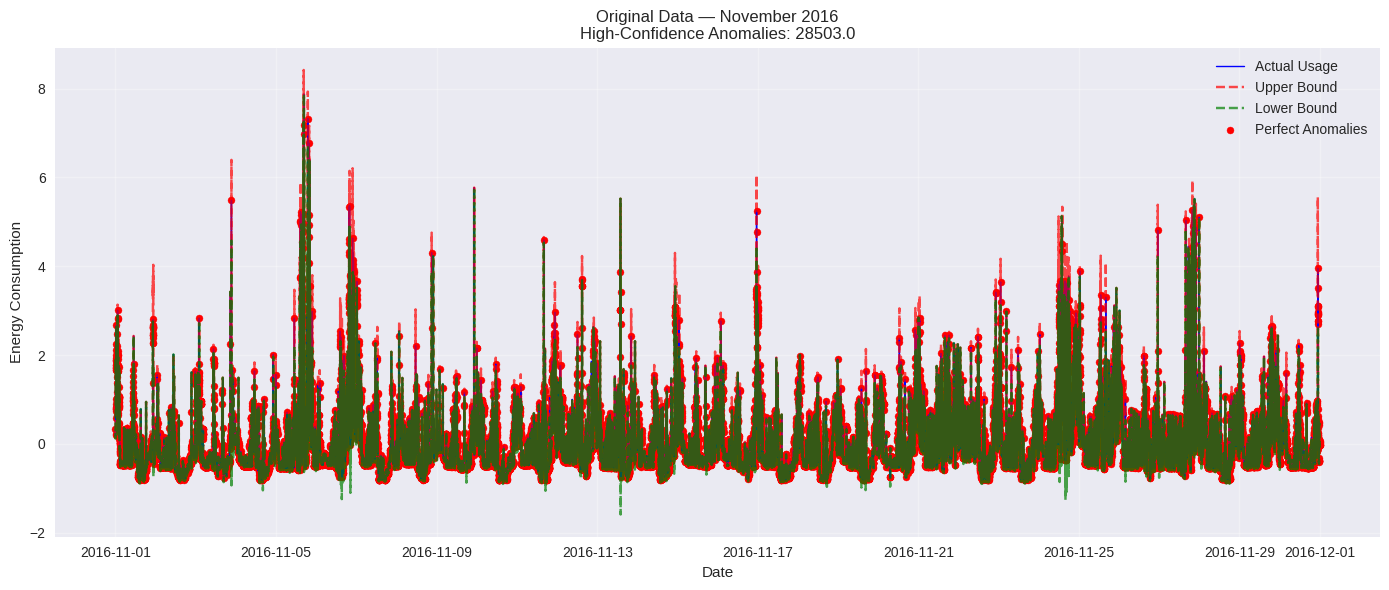

December 2016 — Total Anomalies: 14115.0


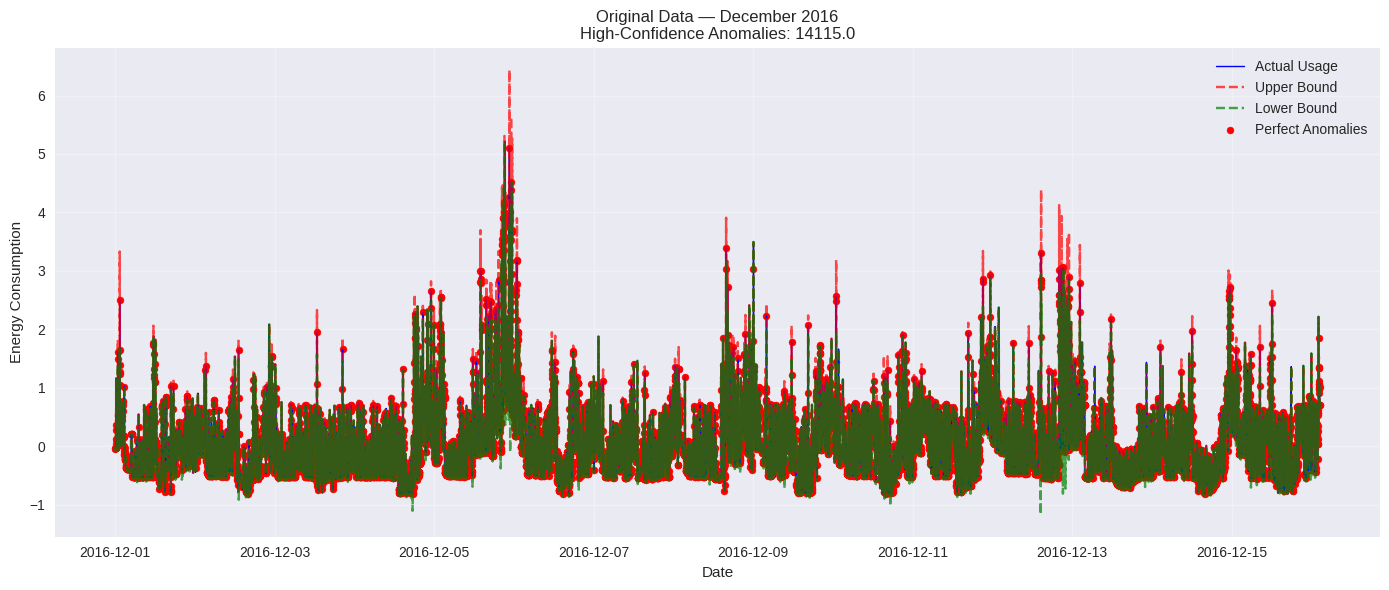

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. LOAD ORIGINAL DATASET + VALIDATED FUSION RESULTS
# ============================================================
df_orig = df1.copy()
df_orig["datetime"] = pd.to_datetime(df_orig["datetime"], errors="coerce")

df_val = pd.read_csv("hybrid_fusion_final_validated/fusion_validated_results.csv")
df_val["datetime"] = pd.to_datetime(df_val["datetime"], errors="coerce")

# ============================================================
# 2. MERGE ORIGINAL DATASET WITH VALIDATED FUSION OUTPUT
# ============================================================
df_plot = pd.merge_asof(
    df_orig.sort_values("datetime"),
    df_val.sort_values("datetime")[["datetime", "fusion_label", "perfect_anomaly",
                                   "AbsResidual", "fusion_score", "confidence_score"]],
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)

df_plot["fusion_label"] = df_plot["fusion_label"].fillna(0)
df_plot["perfect_anomaly"] = df_plot["perfect_anomaly"].fillna(0)
df_plot["AbsResidual"] = df_plot["AbsResidual"].fillna(0)

# ============================================================
# 3. CREATE ANOMALY BOUNDS AROUND ORIGINAL TARGET
# ============================================================
df_plot["upper_bound"] = df_plot["use"] + 3 * df_plot["AbsResidual"]
df_plot["lower_bound"] = df_plot["use"] - 3 * df_plot["AbsResidual"]

# ============================================================
# 4. FILTER YEAR 2016
# ============================================================
df_2016 = df_plot[df_plot["datetime"].dt.year == 2016].copy()

# ============================================================
# 5. PLOTTING FUNCTION FOR EACH MONTH
# ============================================================
def plot_month(month):
    df_m = df_2016[df_2016["datetime"].dt.month == month]
    if df_m.empty:
        print(f"No data found for month {month}")
        return

    # Count anomalies (perfect anomaly preferred)
    count_anom = df_m["perfect_anomaly"].sum()

    # Month name
    month_name = df_m["datetime"].dt.month_name().iloc[0]

    print(f"{month_name} 2016 — Total Anomalies: {count_anom}")

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(df_m["datetime"], df_m["use"], color="blue", label="Actual Usage", linewidth=1)

    plt.plot(df_m["datetime"], df_m["upper_bound"], linestyle="--", color="red",
             label="Upper Bound", alpha=0.7)
    plt.plot(df_m["datetime"], df_m["lower_bound"], linestyle="--", color="green",
             label="Lower Bound", alpha=0.7)

    # Show perfect anomalies
    anomalies = df_m[df_m["perfect_anomaly"] == 1]
    plt.scatter(anomalies["datetime"], anomalies["use"], color="red", s=25, label="Perfect Anomalies")

    plt.title(f"Original Data — {month_name} 2016\nHigh-Confidence Anomalies: {count_anom}")
    plt.xlabel("Date")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================
# 6. PLOT EVERY MONTH OF 2016
# ============================================================
for month in range(1, 13):
    plot_month(month)


In [ ]:
# ============================================================
# EXPLAINABLE AI: ROOT-CAUSE ANALYSIS (TreeSHAP + Surrogate RF)
# FINAL FIXED VERSION – prevents all additivity + shape errors
# ============================================================
import os, json, warnings
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# SAFETY CHECKS
# ------------------------------------------------------------
if 'X_num' not in globals():
    raise RuntimeError("X_num not found.")
if 'fusion_df' not in globals():
    raise RuntimeError("fusion_df not found.")

# ============================================================
# STEP 1: LOAD MODELS
# ============================================================
print("\nLoading models and data...")

rf = joblib.load("random_forest_full_model.pkl")
feature_cols = list(X_num.columns)
scaler = StandardScaler().fit(X_num.values)

fusion_df = fusion_df.reset_index(drop=True)
if "AbsResidual_Hybrid" in fusion_df.columns and "AbsResidual" not in fusion_df.columns:
    fusion_df.rename(columns={"AbsResidual_Hybrid": "AbsResidual"}, inplace=True)
resid_series = pd.Series(fusion_df["AbsResidual"], index=fusion_df.index)

lstm_residuals_path = "lstm_final_results/lstm_residuals.csv"
if os.path.exists(lstm_residuals_path):
    lstm_df = pd.read_csv(lstm_residuals_path)
    lstm_residuals = lstm_df["Residual"].values if "Residual" in lstm_df.columns else None
    print(f"LSTM residuals loaded: {len(lstm_df)} samples")
else:
    lstm_residuals = None
    print("No LSTM residuals file found.")

# ============================================================
# STEP 2: LOAD OR TRAIN SURROGATE RF
# ============================================================
surrogate_path = "surrogate_rf_lstm_resid.joblib"
if os.path.exists(surrogate_path):
    surrogate = joblib.load(surrogate_path)
    print("✅ Loaded existing surrogate model.")
else:
    if lstm_residuals is None:
        raise RuntimeError("No LSTM residuals for surrogate training.")
    X_sur = X_num.iloc[-len(lstm_residuals):].values
    X_scaled = scaler.transform(X_sur)
    surrogate = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
    surrogate.fit(X_scaled, lstm_residuals)
    joblib.dump(surrogate, surrogate_path)
    print("✅ Trained surrogate RF on LSTM residuals.")

# ============================================================
# STEP 3: TREE EXPLAINERS (NO ADDITIVITY VALIDATION)
# ============================================================
print("\nBuilding TreeSHAP explainers...")

def build_explainer_safe(model):
    """Build TreeExplainer with all validation disabled."""
    try:
        return shap.TreeExplainer(model, feature_perturbation="interventional", approximate=True)
    except TypeError:
        return shap.TreeExplainer(model)

explainer_rf = build_explainer_safe(rf)
explainer_sur = build_explainer_safe(surrogate)

baselines = X_num.rolling(window=48, min_periods=1).mean().fillna(method="bfill")

# ============================================================
# STEP 4: SAFE SHAP CALL (DISABLES ADDITIVITY CHECK)
# ============================================================
def safe_shap_values(explainer, X_input):
    """Compute SHAP values with additivity disabled."""
    try:
        vals = explainer.shap_values(X_input, check_additivity=False)
        if isinstance(vals, list): vals = vals[0]
        return np.array(vals).ravel()
    except Exception:
        exp = explainer(X_input)
        vals = getattr(exp, "values", np.array(exp))
        return np.array(vals).ravel()

# ============================================================
# STEP 5: COMPUTE SHAP ROOT CAUSES
# ============================================================
print("\nComputing SHAP explanations for perfect anomalies...")

alpha = 0.8
reports = []
perfect_indices = fusion_df[fusion_df["perfect_anomaly"] == 1].index

for idx in tqdm(perfect_indices, desc="Explaining anomalies"):
    X_row_raw = X_num.loc[idx, feature_cols].values.reshape(1, -1)
    X_scaled = scaler.transform(X_row_raw)

    shap_rf = safe_shap_values(explainer_rf, X_row_raw)
    shap_sur = safe_shap_values(explainer_sur, X_scaled)

    # flatten to ensure 1D arrays only
    shap_rf = np.ravel(shap_rf)
    shap_sur = np.ravel(shap_sur)

    baseline_vals = baselines.loc[idx, feature_cols].values.flatten()
    delta = (X_row_raw.flatten() - baseline_vals).astype(float)

    # defensive shape check
    if len(shap_rf) != len(feature_cols):
        shap_rf = shap_rf[:len(feature_cols)]
    if len(shap_sur) != len(feature_cols):
        shap_sur = shap_sur[:len(feature_cols)]
    if len(delta) != len(feature_cols):
        delta = delta[:len(feature_cols)]

    df_shap = pd.DataFrame({
        "feature": feature_cols,
        "shap_rf": shap_rf,
        "shap_sur": shap_sur,
        "delta": delta
    })

    df_shap["score_rf"] = np.abs(df_shap["shap_rf"]) * np.abs(df_shap["delta"])
    df_shap["score_sur"] = np.abs(df_shap["shap_sur"]) * np.abs(df_shap["delta"])
    df_shap["combined_score"] = df_shap["score_rf"] + alpha * df_shap["score_sur"]

    top5 = df_shap.sort_values("combined_score", ascending=False).head(5)

    reports.append({
        "index": int(idx),
        "datetime": str(fusion_df.loc[idx, "datetime"]) if "datetime" in fusion_df.columns else str(idx),
        "residual": float(resid_series.loc[idx]),
        "top_causes": top5[["feature", "combined_score", "shap_rf", "shap_sur", "delta"]].to_dict(orient="records")
    })

# ============================================================
# STEP 6: HUMAN REPORTS
# ============================================================
def make_text_report(rep):
    out = [f"Anomaly at {rep['datetime']} (index {rep['index']}): residual = {rep['residual']:.3f}",
           "Top contributing features:"]
    for r in rep["top_causes"]:
        out.append(f" • {r['feature']} (Δ={r['delta']:+.3f}, score={r['combined_score']:.4f})")
    return "\n".join(out)

print("\n================= SAMPLE HUMAN-FRIENDLY REPORTS =================")
for rep in reports[:3]:
    print(make_text_report(rep))
    print("------------------------------------------------------------------")

# ============================================================
# STEP 7: SAVE RESULTS
# ============================================================
os.makedirs("explainability_reports", exist_ok=True)
with open("explainability_reports/root_cause_reports.json", "w") as f:
    json.dump(reports, f, indent=4)
print(f"\n✅ Saved {len(reports)} root-cause reports to 'explainability_reports/root_cause_reports.json'")

# ============================================================
# STEP 8: VISUALIZATION
# ============================================================
print("\nGenerating SHAP diagrams...")
os.makedirs("explainability_reports/plots", exist_ok=True)

# ---- GLOBAL SUMMARY ----
sample_size = min(5000, len(X_num))
X_sample = X_num.sample(sample_size, random_state=42)
X_scaled_sample = scaler.transform(X_sample)

# Compute SHAP safely
shap_values_rf = explainer_rf.shap_values(X_scaled_sample)
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[0]

# Ensure proper shape
if shap_values_rf.ndim == 1:
    shap_values_rf = shap_values_rf.reshape(-1, len(feature_cols))

print(f"SHAP value matrix shape: {shap_values_rf.shape}")

# ---- Summary Plot ----
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values_rf, X_sample, feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot – Random Forest (Global Importance)")
plt.tight_layout()
plt.savefig("explainability_reports/plots/shap_summary_rf.png", dpi=300)
plt.close()

# ---- Bar Plot ----
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar",
                  feature_names=feature_cols, show=False)
plt.title("Mean |SHAP| Feature Importance – Random Forest")
plt.tight_layout()
plt.savefig("explainability_reports/plots/shap_bar_rf.png", dpi=300)
plt.close()

# ---- Waterfall (first anomaly) ----
first_idx = int(perfect_indices[0])
X_row = X_num.loc[first_idx, feature_cols].values.reshape(1, -1)
X_scaled_row = scaler.transform(X_row)

# Safe single-sample SHAP call
single_shap = explainer_rf(X_scaled_row)
try:
    shap.plots.waterfall(single_shap[0], max_display=10, show=False)
    plt.title(f"Waterfall Plot – Anomaly index {first_idx}")
    plt.tight_layout()
    plt.savefig(f"explainability_reports/plots/waterfall_anomaly_{first_idx}.png", dpi=300)
    plt.close()
except Exception as e:
    print(f"⚠️ Skipped waterfall plot due to: {e}")

print("✅ SHAP diagrams saved in 'explainability_reports/plots/' folder.")



Loading models and data...
LSTM residuals loaded: 503657 samples
✅ Trained surrogate RF on LSTM residuals.

Building TreeSHAP explainers...

Computing SHAP explanations for perfect anomalies...


Explaining anomalies: 100%|██████████| 172/172 [09:31<00:00,  3.33s/it]



================= SAMPLE HUMAN-FRIENDLY REPORTS =================
Anomaly at 2016-01-02 19:08:58 (index 711): residual = 0.549
Top contributing features:
 • Furnace (Δ=+3.389, score=2.9027)
 • minute (Δ=+23.500, score=0.3841)
 • summary (Δ=+6.667, score=0.1847)
 • icon (Δ=+1.333, score=0.0139)
 • cloudCover (Δ=+0.167, score=0.0081)
------------------------------------------------------------------
Anomaly at 2016-01-08 18:29:58 (index 3264): residual = 0.757
Top contributing features:
 • Furnace (Δ=+1.540, score=1.5425)
 • hour (Δ=+0.479, score=0.0181)
 • windBearing (Δ=+3.229, score=0.0075)
 • minute (Δ=-5.250, score=0.0031)
 • apparentTemperature (Δ=+0.084, score=0.0023)
------------------------------------------------------------------
Anomaly at 2016-02-20 15:17:58 (index 21800): residual = 0.761
Top contributing features:
 • Furnace (Δ=+0.509, score=0.0361)
 • hour (Δ=+0.562, score=0.0201)
 • Wine_cellar (Δ=-0.670, score=0.0115)
 • minute (Δ=-10.250, score=0.0087)
 • Microwave (Δ

In [ ]:
# ============================================================
# STEP 5C: CONTEXT-AWARE TEMPORAL EXPLAINABILITY (CATE)
# ============================================================
import calendar

print("\nBuilding temporal context for anomalies...")

if "datetime" not in fusion_df.columns:
    raise ValueError("datetime column required for contextual temporal explainability")

fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")
fusion_df["hour"] = fusion_df["datetime"].dt.hour
fusion_df["minute"] = fusion_df["datetime"].dt.minute
fusion_df["weekday"] = fusion_df["datetime"].dt.day_name()
fusion_df["week"] = fusion_df["datetime"].dt.isocalendar().week.astype(int)
fusion_df["month"] = fusion_df["datetime"].dt.month_name()

# --- Learn baseline rhythms ---
hourly_baseline = fusion_df.groupby(["weekday", "hour"])["AbsResidual"].mean().unstack().fillna(0)
peak_windows = {}
for wd in hourly_baseline.index:
    s = hourly_baseline.loc[wd]
    if s.sum() == 0:
        peak_windows[wd] = (None, None)
    else:
        top_hours = s.nlargest(3).index.tolist()
        peak_windows[wd] = (min(top_hours), max(top_hours))

baseline_time = fusion_df.groupby("weekday")["hour"].mean().to_dict()
baseline_minute = fusion_df.groupby("hour")["minute"].mean().to_dict()

def interpret_time_relation(hour, weekday):
    if weekday not in peak_windows or peak_windows[weekday][0] is None:
        return "during a low-activity period"
    low, high = peak_windows[weekday]
    if hour < low:
        return f"outside typical {low:02d}:00–{high:02d}:00 peak (earlier than usual)"
    elif hour > high:
        return f"outside typical {low:02d}:00–{high:02d}:00 peak (later than usual)"
    else:
        return f"within typical {low:02d}:00–{high:02d}:00 peak"

def contextual_temporal_sentence(idx):
    """Generate natural-language temporal context for an anomaly."""
    hr = int(fusion_df.loc[idx, "hour"])
    mn = int(fusion_df.loc[idx, "minute"])
    wd = fusion_df.loc[idx, "weekday"]
    wk = int(fusion_df.loc[idx, "week"])
    mo = fusion_df.loc[idx, "month"]

    mean_min = baseline_minute.get(hr, np.nan)
    mn_shift = mn - mean_min if not np.isnan(mean_min) else 0

    if mn_shift < -10:
        minute_phrase = f"{abs(int(mn_shift))} minutes earlier than usual"
    elif mn_shift > 10:
        minute_phrase = f"{abs(int(mn_shift))} minutes later than usual"
    else:
        minute_phrase = "around the usual time"

    if hr < 6:
        period = "early morning"
    elif hr < 12:
        period = "morning"
    elif hr < 17:
        period = "afternoon"
    elif hr < 21:
        period = "evening"
    else:
        period = "night"

    peak_context = interpret_time_relation(hr, wd)
    return (
        f"Anomaly occurred {minute_phrase} on a {wd} {period} "
        f"in Week {wk}, during {mo}, {peak_context}."
    )

# Attach temporal explanation to each anomaly report
for r in reports:
    idx = r["index"]
    if idx in fusion_df.index:
        r["temporal_explanation"] = contextual_temporal_sentence(idx)

print("\n✅ Temporal context sentences added to all reports.")
for rep in reports[:3]:
    print(f"Anomaly at {rep['datetime']}: residual = {rep['residual']:.3f}")
    print(rep["temporal_explanation"])
    print("Top contributing features:")
    for f in rep["top_causes"]:
        print(f" • {f['feature']} (Δ={f['delta']:+.3f}, score={f['combined_score']:.4f})")
    print("------------------------------------------------------------------")
with open("explainability_reports/root_cause_reports.json", "w") as f:
    json.dump(reports, f, indent=4)



Building temporal context for anomalies...

✅ Temporal context sentences added to all reports.
Anomaly at 2016-01-02 19:08:58: residual = 0.549
Anomaly occurred 21 minutes earlier than usual on a Saturday evening in Week 53, during January, within typical 19:00–22:00 peak.
Top contributing features:
 • Furnace (Δ=+3.389, score=2.9027)
 • minute (Δ=+23.500, score=0.3841)
 • summary (Δ=+6.667, score=0.1847)
 • icon (Δ=+1.333, score=0.0139)
 • cloudCover (Δ=+0.167, score=0.0081)
------------------------------------------------------------------
Anomaly at 2016-01-08 18:29:58: residual = 0.757
Anomaly occurred around the usual time on a Friday evening in Week 1, during January, within typical 16:00–22:00 peak.
Top contributing features:
 • Furnace (Δ=+1.540, score=1.5425)
 • hour (Δ=+0.479, score=0.0181)
 • windBearing (Δ=+3.229, score=0.0075)
 • minute (Δ=-5.250, score=0.0031)
 • apparentTemperature (Δ=+0.084, score=0.0023)
----------------------------------------------------------------

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# SAMPLE DATA FOR GLOBAL EXPLANATION
sample_size = min(3000, len(X_num))
X_sample = X_num.sample(sample_size, random_state=42)

# CREATE TREE SHAP EXPLAINER
explainer_global = shap.TreeExplainer(rf, feature_perturbation="interventional", approximate=True)

# COMPUTE SHAP VALUES
shap_vals_global = explainer_global.shap_values(X_sample, check_additivity=False)

# GLOBAL SUMMARY PLOT
plt.figure(figsize=(10,6))
shap.summary_plot(shap_vals_global, X_sample, feature_names=feature_cols, show=False)
plt.tight_layout()
plt.show()

# GLOBAL BAR PLOT (mean absolute SHAP values)
plt.figure(figsize=(8,5))
shap.summary_plot(shap_vals_global, X_sample, feature_names=feature_cols, plot_type="bar", show=False)
plt.tight_layout()
plt.show()


In [ ]:
# pick the first perfect anomaly
idx_to_explain = fusion_df[fusion_df["perfect_anomaly"] == 1].index[0]
print("Explaining anomaly at index:", idx_to_explain)
X_local = X_num.loc[idx_to_explain, feature_cols].values.reshape(1, -1)


Loading Random Forest and LSTM residuals...
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE   : 0.0891
MSE   : 0.0531
RMSE  : 0.2304
R2    : 0.9465
MAPE% : 95.9640

Detected anomalies: 57737 using window=6, threshold=0.0
Total distinct anomaly events: 36840


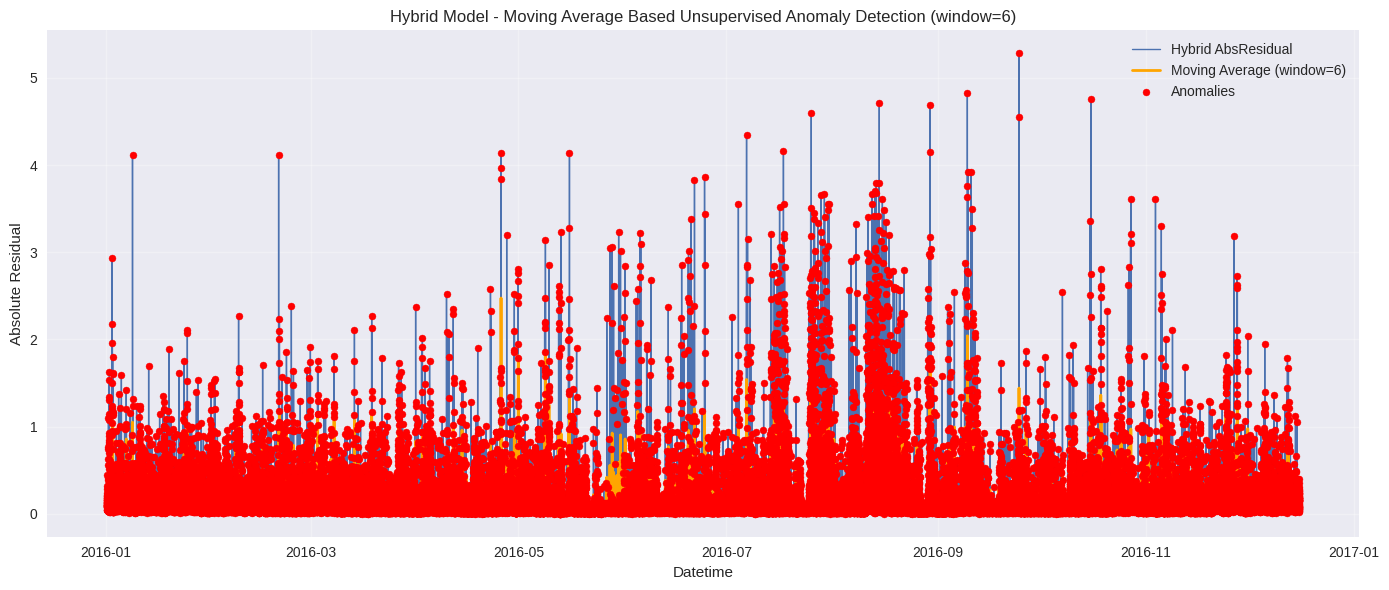


✅ Unsupervised hybrid anomaly results saved in 'hybrid_unsupervised_MA/'
✅ Moving Average anomaly scoring and labeling completed.


In [ ]:
# ============================================================
# HYBRID RANDOM FOREST + LSTM (MOVING AVERAGE + UNSUPERVISED ANOMALY SCORING)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib, json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================
# STEP 1: LOAD RF & LSTM RESIDUALS
# ============================================================
print("Loading Random Forest and LSTM residuals...")

df_rf = pd.read_csv("rf_residuals.csv")
df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

# Ensure datetime columns exist and are consistent
assert "datetime" in df_rf.columns, "Random Forest residual file missing 'datetime'"
assert "datetime" in df_lstm.columns, "LSTM residual file missing 'datetime'"

df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

# Align both by nearest timestamp (safe merge)
df_rf = df_rf.sort_values("datetime")
df_lstm = df_lstm.sort_values("datetime")

df_merged = pd.merge_asof(
    df_rf,
    df_lstm,
    on="datetime",
    suffixes=("_RF", "_LSTM"),
    direction="nearest",
    tolerance=pd.Timedelta("1min")  # adjust to your sampling rate
)

df_merged.dropna(subset=["Predicted_RF", "Predicted_LSTM"], inplace=True)
print(f"Aligned on {len(df_merged)} common timestamps from RF and LSTM residuals.\n")

# ============================================================
# STEP 2: HYBRID FUSION
# ============================================================
w_rf = 0.4
w_lstm = 0.6

actual = df_merged["Actual_LSTM"].values
pred_hybrid = (w_rf * df_merged["Predicted_RF"].values) + (w_lstm * df_merged["Predicted_LSTM"].values)
residual_hybrid = actual - pred_hybrid
abs_residual_hybrid = np.abs(residual_hybrid)

df_hybrid = pd.DataFrame({
    "datetime": df_merged["datetime"],
    "Actual": actual,
    "Pred_Hybrid": pred_hybrid,
    "Residual_Hybrid": residual_hybrid,
    "AbsResidual_Hybrid": abs_residual_hybrid
})

# ============================================================
# STEP 3: MODEL PERFORMANCE METRICS
# ============================================================
mae = mean_absolute_error(actual, pred_hybrid)
mse = mean_squared_error(actual, pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(actual, pred_hybrid)
mape = np.mean(np.abs((actual - pred_hybrid) / (actual + 1e-8))) * 100

print("===== HYBRID MODEL PERFORMANCE =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# STEP 4: MOVING AVERAGE + UNSUPERVISED ANOMALY SCORING
# ============================================================
window = 6
threshold = 0.0

# Moving average of absolute residuals
df_hybrid["MA_Residual"] = df_hybrid["AbsResidual_Hybrid"].rolling(window=window, center=True).mean()

# Compute anomaly score = deviation from moving average baseline
df_hybrid["Anomaly_Score"] = df_hybrid["AbsResidual_Hybrid"] - df_hybrid["MA_Residual"]
df_hybrid["Anomaly_Score"] = df_hybrid["Anomaly_Score"].clip(lower=0)  # negative deviations = 0

# Normalize score (0–1 scale)
score_max = df_hybrid["Anomaly_Score"].max() + 1e-8
df_hybrid["Anomaly_Score_Norm"] = df_hybrid["Anomaly_Score"] / score_max

# Label anomalies (unsupervised): score > threshold → 1
df_hybrid["Anomaly_Label"] = (df_hybrid["Anomaly_Score_Norm"] > threshold).astype(int)

num_anomalies = df_hybrid["Anomaly_Label"].sum()
print(f"\nDetected anomalies: {num_anomalies} using window={window}, threshold={threshold}")

# ============================================================
# STEP 5: GROUP CONSECUTIVE ANOMALY EVENTS (SAFE VERSION)
# ============================================================
df_hybrid = df_hybrid.reset_index(drop=True)
mask = df_hybrid["Anomaly_Label"] == 1
# Start of a new event where anomaly = 1 and previous = 0
new_event = mask & (~mask.shift(fill_value=False))
df_hybrid["Anomaly_Event"] = new_event.cumsum() * mask

# Add start and end timestamps for each event
events = []
for eid, group in df_hybrid[df_hybrid["Anomaly_Event"] > 0].groupby("Anomaly_Event"):
    start_time = group["datetime"].iloc[0]
    end_time = group["datetime"].iloc[-1]
    duration = end_time - start_time
    events.append({"Event_ID": int(eid), "Start": str(start_time), "End": str(end_time), "Duration": str(duration)})

event_count = len(events)
print(f"Total distinct anomaly events: {event_count}")

# ============================================================
# STEP 6: PLOTTING
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(df_hybrid["datetime"], df_hybrid["AbsResidual_Hybrid"], label="Hybrid AbsResidual", linewidth=1)
plt.plot(df_hybrid["datetime"], df_hybrid["MA_Residual"], color="orange", linewidth=2, label=f"Moving Average (window={window})")
plt.scatter(
    df_hybrid["datetime"][df_hybrid["Anomaly_Label"]==1],
    df_hybrid["AbsResidual_Hybrid"][df_hybrid["Anomaly_Label"]==1],
    color="red", s=25, label="Anomalies", zorder=3
)
plt.title(f"Hybrid Model - Moving Average Based Unsupervised Anomaly Detection (window={window})")
plt.xlabel("Datetime")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 7: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_unsupervised_MA", exist_ok=True)
df_hybrid.to_csv("hybrid_unsupervised_MA/hybrid_unsupervised_MA_results.csv", index=False)

# Save event metadata
with open("hybrid_unsupervised_MA/hybrid_unsupervised_MA_events.json", "w") as f:
    json.dump(events, f, indent=4)

hybrid_metrics = {
    "Model": "Hybrid_RF_LSTM_Unsupervised_MA",
    "w_RF": w_rf,
    "w_LSTM": w_lstm,
    "Window": window,
    "Threshold": threshold,
    "MAE": float(mae),
    "MSE": float(mse),
    "RMSE": float(rmse),
    "R2": float(r2),
    "MAPE (%)": float(mape),
    "Anomalies_Detected": int(num_anomalies),
    "Distinct_Anomaly_Events": event_count
}

with open("hybrid_unsupervised_MA/hybrid_unsupervised_MA_metrics.json", "w") as f:
    json.dump(hybrid_metrics, f, indent=4)

print("\n✅ Unsupervised hybrid anomaly results saved in 'hybrid_unsupervised_MA/'")
print("✅ Moving Average anomaly scoring and labeling completed.")


Loading Random Forest and LSTM residuals...
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE   : 0.0891
MSE   : 0.0531
RMSE  : 0.2304
R2    : 0.9465
MAPE% : 95.9640

Fitting Isolation Forest on residuals...
Detected anomalies (Isolation Forest): 4520
Distinct anomaly events: 3320


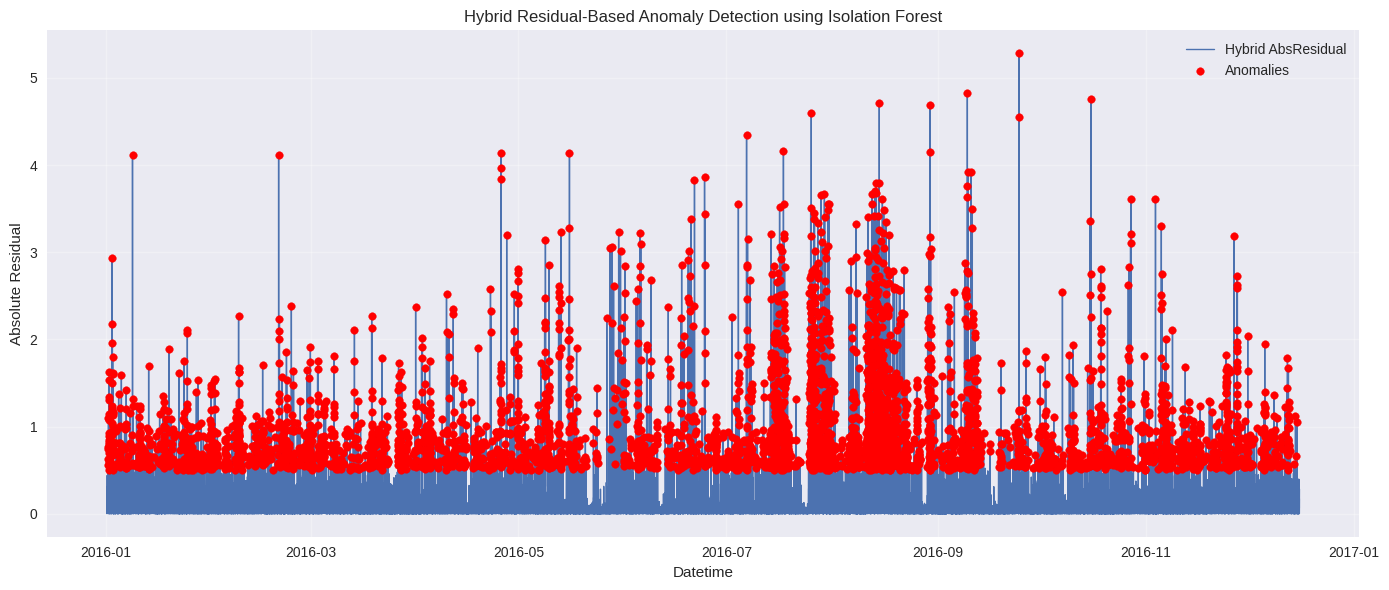

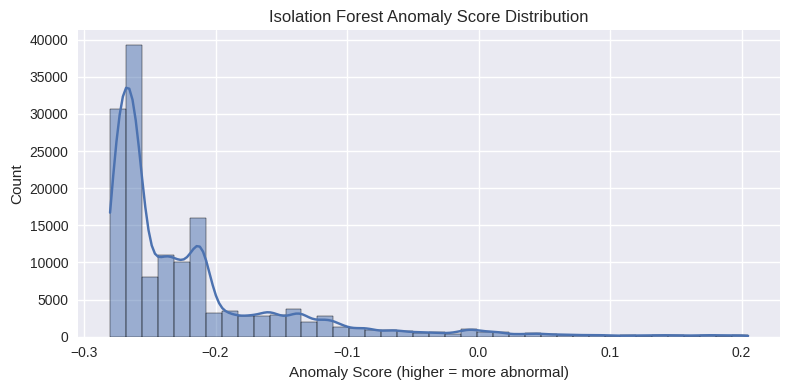


✅ Hybrid Isolation Forest anomaly results saved in 'hybrid_results_isolation_forest/'
✅ Anomaly scoring, event grouping, and labeling completed.


In [ ]:
# ============================================================
# HYBRID RANDOM FOREST + LSTM MODEL WITH ISOLATION FOREST ANOMALY DETECTION (SAFE VERSION)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest

# ============================================================
# STEP 1: LOAD RF & LSTM RESIDUALS
# ============================================================
print("Loading Random Forest and LSTM residuals...")

df_rf = pd.read_csv("rf_residuals.csv")
df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

# Ensure datetime columns exist
assert "datetime" in df_rf.columns, "RF residual file missing 'datetime'"
assert "datetime" in df_lstm.columns, "LSTM residual file missing 'datetime'"

df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

# Align both by nearest timestamp
df_rf = df_rf.sort_values("datetime")
df_lstm = df_lstm.sort_values("datetime")

df_merged = pd.merge_asof(
    df_rf,
    df_lstm,
    on="datetime",
    suffixes=("_RF", "_LSTM"),
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)
df_merged.dropna(subset=["Predicted_RF", "Predicted_LSTM"], inplace=True)
print(f"Aligned on {len(df_merged)} common timestamps from RF and LSTM residuals.\n")

# ============================================================
# STEP 2: HYBRID RESIDUAL FUSION
# ============================================================
w_rf = 0.4
w_lstm = 0.6

actual = df_merged["Actual_LSTM"].values
pred_hybrid = (w_rf * df_merged["Predicted_RF"].values) + (w_lstm * df_merged["Predicted_LSTM"].values)
residual_hybrid = actual - pred_hybrid
abs_residual_hybrid = np.abs(residual_hybrid)

df_hybrid = pd.DataFrame({
    "datetime": df_merged["datetime"],
    "Actual": actual,
    "Pred_Hybrid": pred_hybrid,
    "Residual_Hybrid": residual_hybrid,
    "AbsResidual_Hybrid": abs_residual_hybrid
})

# ============================================================
# STEP 3: HYBRID MODEL PERFORMANCE
# ============================================================
mae = mean_absolute_error(actual, pred_hybrid)
mse = mean_squared_error(actual, pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(actual, pred_hybrid)
mape = np.mean(np.abs((actual - pred_hybrid) / (actual + 1e-8))) * 100

print("===== HYBRID MODEL PERFORMANCE =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# STEP 4: ISOLATION FOREST ANOMALY DETECTION
# ============================================================
print("\nFitting Isolation Forest on residuals...")

X_iso = df_hybrid[["AbsResidual_Hybrid"]].values

iso = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    max_samples="auto",
    random_state=42,
    n_jobs=-1
)
iso.fit(X_iso)

df_hybrid["Anomaly_Score"] = -iso.decision_function(X_iso)
df_hybrid["Anomaly_Label"] = iso.predict(X_iso)
df_hybrid["Anomaly_Label"] = df_hybrid["Anomaly_Label"].map({1: 0, -1: 1})

num_anomalies = df_hybrid["Anomaly_Label"].sum()
print(f"Detected anomalies (Isolation Forest): {num_anomalies}")

# ============================================================
# STEP 5: GROUP CONSECUTIVE ANOMALY EVENTS (SAFE VERSION)
# ============================================================
df_hybrid = df_hybrid.reset_index(drop=True)
mask = df_hybrid["Anomaly_Label"] == 1
new_event = mask & (~mask.shift(fill_value=False))
df_hybrid["Anomaly_Event"] = new_event.cumsum() * mask

# Event metadata
events = []
for eid, grp in df_hybrid[df_hybrid["Anomaly_Event"] > 0].groupby("Anomaly_Event"):
    start_time = grp["datetime"].iloc[0]
    end_time = grp["datetime"].iloc[-1]
    duration = end_time - start_time
    events.append({"Event_ID": int(eid), "Start": str(start_time), "End": str(end_time), "Duration": str(duration)})

event_count = len(events)
print(f"Distinct anomaly events: {event_count}")

# ============================================================
# STEP 6: PLOT RESULTS
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(df_hybrid["datetime"], df_hybrid["AbsResidual_Hybrid"], label="Hybrid AbsResidual", linewidth=1)
plt.scatter(
    df_hybrid["datetime"][df_hybrid["Anomaly_Label"] == 1],
    df_hybrid["AbsResidual_Hybrid"][df_hybrid["Anomaly_Label"] == 1],
    color="red", s=30, label="Anomalies", zorder=3
)
plt.title("Hybrid Residual-Based Anomaly Detection using Isolation Forest")
plt.xlabel("Datetime")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Anomaly score distribution
plt.figure(figsize=(8,4))
sns.histplot(df_hybrid["Anomaly_Score"], bins=40, kde=True)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more abnormal)")
plt.tight_layout()
plt.show()

# ============================================================
# STEP 7: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_results_isolation_forest", exist_ok=True)

df_hybrid.to_csv("hybrid_results_isolation_forest/hybrid_iforest_results.csv", index=False)

with open("hybrid_results_isolation_forest/hybrid_iforest_events.json", "w") as f:
    json.dump(events, f, indent=4)

hybrid_metrics = {
    "Model": "Hybrid_RF_LSTM_IsolationForest",
    "w_RF": w_rf,
    "w_LSTM": w_lstm,
    "MAE": float(mae),
    "MSE": float(mse),
    "RMSE": float(rmse),
    "R2": float(r2),
    "MAPE (%)": float(mape),
    "Contamination": 0.03,
    "Detected_Anomalies": int(num_anomalies),
    "Distinct_Anomaly_Events": int(event_count)
}

with open("hybrid_results_isolation_forest/hybrid_iforest_metrics.json", "w") as f:
    json.dump(hybrid_metrics, f, indent=4)

print("\n✅ Hybrid Isolation Forest anomaly results saved in 'hybrid_results_isolation_forest/'")
print("✅ Anomaly scoring, event grouping, and labeling completed.")


Loading Random Forest and LSTM residuals...
Aligned on 151101 common timestamps from RF and LSTM residuals.

===== HYBRID MODEL PERFORMANCE =====
MAE   : 0.0891
MSE   : 0.0531
RMSE  : 0.2304
R2    : 0.9465
MAPE% : 95.9640

Training One-Class SVM on hybrid residuals...
Detected anomalies (One-Class SVM): 1524
Distinct anomaly events: 1405


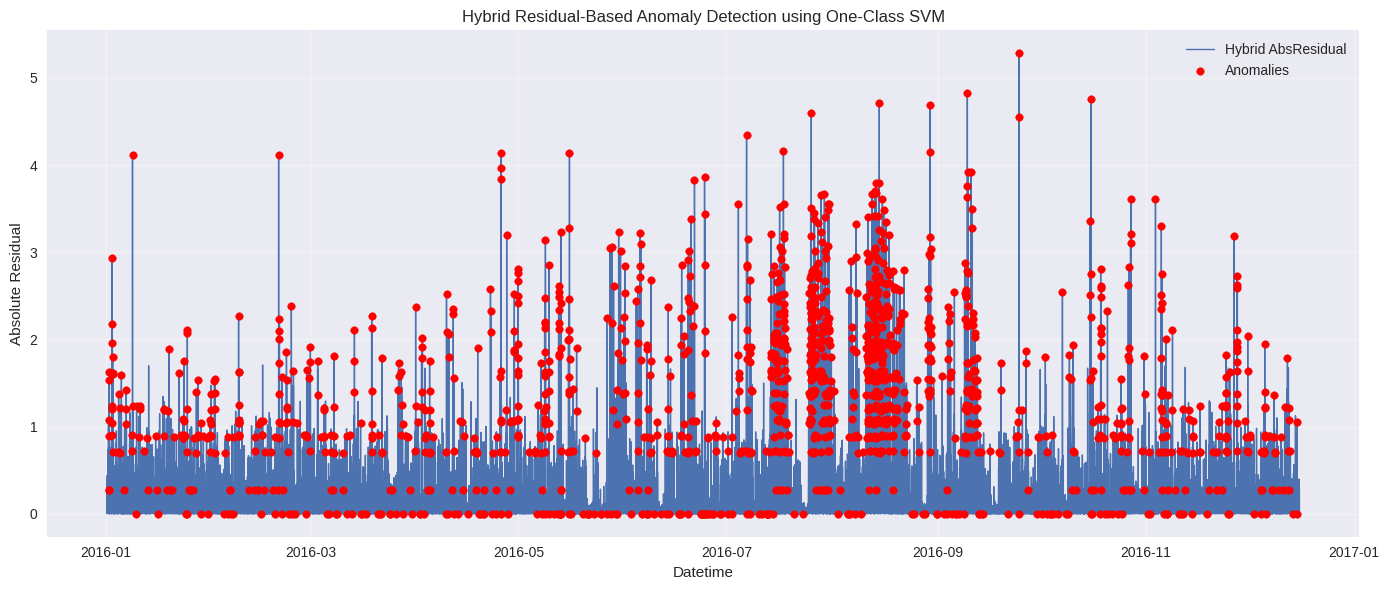

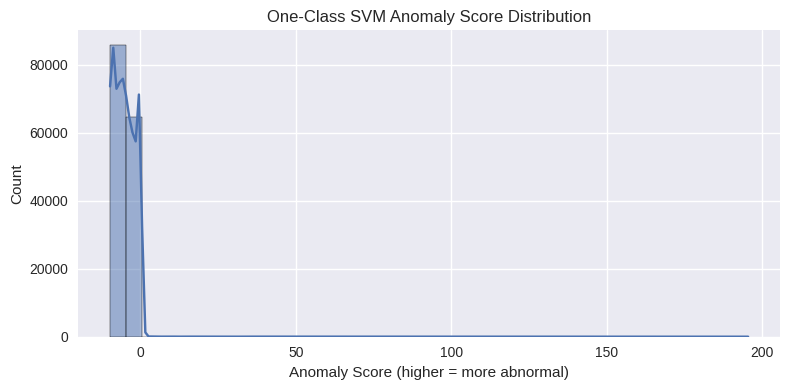


✅ Hybrid One-Class SVM anomaly results saved in 'hybrid_results_oneclass_svm/'
✅ Anomaly scoring, event grouping, and labeling completed.


In [ ]:
# ============================================================
# HYBRID RANDOM FOREST + LSTM MODEL WITH ONE-CLASS SVM ANOMALY DETECTION (SAFE VERSION)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# ============================================================
# STEP 1: LOAD RF & LSTM RESIDUALS
# ============================================================
print("Loading Random Forest and LSTM residuals...")

df_rf = pd.read_csv("rf_residuals.csv")
df_lstm = pd.read_csv("lstm_final_results/lstm_residuals.csv")

# Ensure datetime columns exist
assert "datetime" in df_rf.columns, "RF residual file missing 'datetime'"
assert "datetime" in df_lstm.columns, "LSTM residual file missing 'datetime'"

df_rf["datetime"] = pd.to_datetime(df_rf["datetime"], errors="coerce")
df_lstm["datetime"] = pd.to_datetime(df_lstm["datetime"], errors="coerce")

# Align both by nearest timestamp
df_rf = df_rf.sort_values("datetime")
df_lstm = df_lstm.sort_values("datetime")

df_merged = pd.merge_asof(
    df_rf,
    df_lstm,
    on="datetime",
    suffixes=("_RF", "_LSTM"),
    direction="nearest",
    tolerance=pd.Timedelta("1min")
)
df_merged.dropna(subset=["Predicted_RF", "Predicted_LSTM"], inplace=True)
print(f"Aligned on {len(df_merged)} common timestamps from RF and LSTM residuals.\n")

# ============================================================
# STEP 2: HYBRID FUSION (RF + LSTM)
# ============================================================
w_rf = 0.4
w_lstm = 0.6

actual = df_merged["Actual_LSTM"].values
pred_hybrid = (w_rf * df_merged["Predicted_RF"].values) + (w_lstm * df_merged["Predicted_LSTM"].values)
residual_hybrid = actual - pred_hybrid
abs_residual_hybrid = np.abs(residual_hybrid)

df_hybrid = pd.DataFrame({
    "datetime": df_merged["datetime"],
    "Actual": actual,
    "Pred_Hybrid": pred_hybrid,
    "Residual_Hybrid": residual_hybrid,
    "AbsResidual_Hybrid": abs_residual_hybrid
})

# ============================================================
# STEP 3: HYBRID MODEL PERFORMANCE
# ============================================================
mae = mean_absolute_error(actual, pred_hybrid)
mse = mean_squared_error(actual, pred_hybrid)
rmse = np.sqrt(mse)
r2 = r2_score(actual, pred_hybrid)
mape = np.mean(np.abs((actual - pred_hybrid) / (actual + 1e-8))) * 100

print("===== HYBRID MODEL PERFORMANCE =====")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R2    : {r2:.4f}")
print(f"MAPE% : {mape:.4f}")

# ============================================================
# STEP 4: ONE-CLASS SVM ANOMALY DETECTION
# ============================================================
print("\nTraining One-Class SVM on hybrid residuals...")

X_svm = df_hybrid[["AbsResidual_Hybrid"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svm)

ocsvm = OneClassSVM(
    kernel="rbf",
    nu=0.01,      # expected anomaly fraction
    gamma="scale"
)
ocsvm.fit(X_scaled)

decision_scores = ocsvm.decision_function(X_scaled)
df_hybrid["Anomaly_Score"] = -decision_scores
df_hybrid["Anomaly_Label"] = ocsvm.predict(X_scaled)
df_hybrid["Anomaly_Label"] = df_hybrid["Anomaly_Label"].map({1: 0, -1: 1})

num_anomalies = df_hybrid["Anomaly_Label"].sum()
print(f"Detected anomalies (One-Class SVM): {num_anomalies}")

# ============================================================
# STEP 5: GROUP CONSECUTIVE ANOMALY EVENTS (SAFE VERSION)
# ============================================================
df_hybrid = df_hybrid.reset_index(drop=True)
mask = df_hybrid["Anomaly_Label"] == 1
new_event = mask & (~mask.shift(fill_value=False))
df_hybrid["Anomaly_Event"] = new_event.cumsum() * mask

# Create event summary
events = []
for eid, grp in df_hybrid[df_hybrid["Anomaly_Event"] > 0].groupby("Anomaly_Event"):
    start_time = grp["datetime"].iloc[0]
    end_time = grp["datetime"].iloc[-1]
    duration = end_time - start_time
    events.append({"Event_ID": int(eid), "Start": str(start_time), "End": str(end_time), "Duration": str(duration)})

event_count = len(events)
print(f"Distinct anomaly events: {event_count}")

# ============================================================
# STEP 6: VISUALIZATION
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(df_hybrid["datetime"], df_hybrid["AbsResidual_Hybrid"], label="Hybrid AbsResidual", linewidth=1)
plt.scatter(
    df_hybrid["datetime"][df_hybrid["Anomaly_Label"] == 1],
    df_hybrid["AbsResidual_Hybrid"][df_hybrid["Anomaly_Label"] == 1],
    color="red", s=30, label="Anomalies", zorder=3
)
plt.title("Hybrid Residual-Based Anomaly Detection using One-Class SVM")
plt.xlabel("Datetime")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Anomaly score distribution
plt.figure(figsize=(8,4))
sns.histplot(df_hybrid["Anomaly_Score"], bins=40, kde=True)
plt.title("One-Class SVM Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more abnormal)")
plt.tight_layout()
plt.show()

# ============================================================
# STEP 7: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_results_oneclass_svm", exist_ok=True)
df_hybrid.to_csv("hybrid_results_oneclass_svm/hybrid_ocsvm_results.csv", index=False)

with open("hybrid_results_oneclass_svm/hybrid_ocsvm_events.json", "w") as f:
    json.dump(events, f, indent=4)

hybrid_metrics = {
    "Model": "Hybrid_RF_LSTM_OneClassSVM",
    "w_RF": w_rf,
    "w_LSTM": w_lstm,
    "MAE": float(mae),
    "MSE": float(mse),
    "RMSE": float(rmse),
    "R2": float(r2),
    "MAPE (%)": float(mape),
    "Nu": 0.01,
    "Kernel": "rbf",
    "Detected_Anomalies": int(num_anomalies),
    "Distinct_Anomaly_Events": int(event_count)
}

with open("hybrid_results_oneclass_svm/hybrid_ocsvm_metrics.json", "w") as f:
    json.dump(hybrid_metrics, f, indent=4)

print("\n✅ Hybrid One-Class SVM anomaly results saved in 'hybrid_results_oneclass_svm/'")
print("✅ Anomaly scoring, event grouping, and labeling completed.")


Detected score columns → MA: Anomaly_Score_Norm, IF: Anomaly_Score, OCSVM: Anomaly_Score
Aligned 151101 timestamps across all detectors.
Detected anomalies: 28507
Fusion threshold: 0.0702


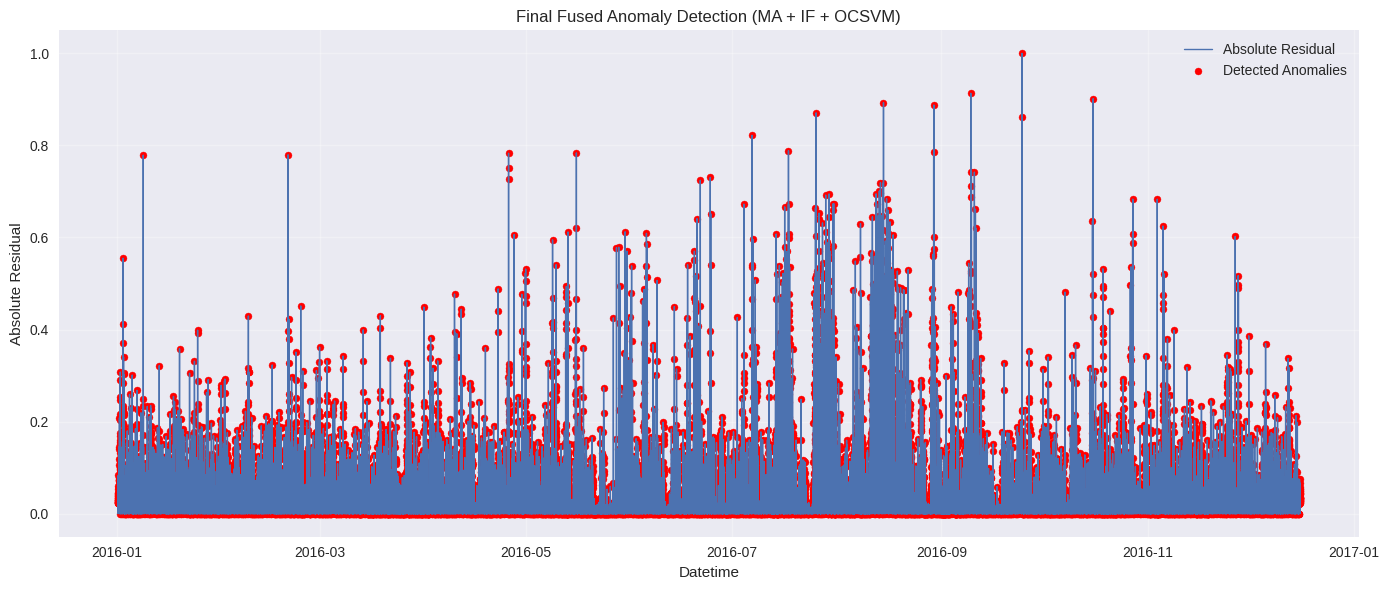

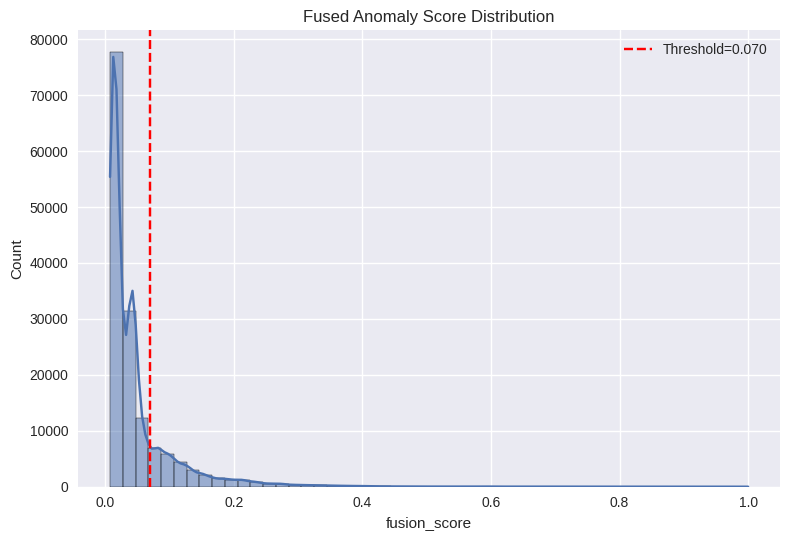


✅ Stable datetime-aware fusion completed successfully.
✅ Results saved in 'hybrid_fusion_final/' folder.


In [ ]:
# ============================================================
# FINAL FUSION OF MA, IF, AND OCSVM DETECTORS (DATETIME-AWARE, SAFE)
# ============================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os, json

# ============================================================
# STEP 1: LOAD DETECTOR RESULTS
# ============================================================
df_ma = pd.read_csv("hybrid_unsupervised_MA/hybrid_unsupervised_MA_results.csv")
df_if = pd.read_csv("hybrid_results_isolation_forest/hybrid_iforest_results.csv")
df_oc = pd.read_csv("hybrid_results_oneclass_svm/hybrid_ocsvm_results.csv")

# ============================================================
# STEP 2: VERIFY DATETIME AND SORT
# ============================================================
for name, df in {"MA": df_ma, "IF": df_if, "OCSVM": df_oc}.items():
    assert "datetime" in df.columns, f"{name} file missing datetime"
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df.sort_values("datetime", inplace=True)
    df.reset_index(drop=True, inplace=True)

# ============================================================
# STEP 3: AUTO-DETECT SCORE COLUMNS
# ============================================================
def find_score_col(df):
    for c in ["Anomaly_Score_Norm", "Anomaly_Score", "Score", "fusion_score"]:
        if c in df.columns:
            return c
    for c in df.select_dtypes(include=np.number).columns:
        if "Residual" not in c and "Label" not in c:
            return c
    return df.select_dtypes(include=np.number).columns[0]

col_ma = find_score_col(df_ma)
col_if = find_score_col(df_if)
col_oc = find_score_col(df_oc)
print(f"Detected score columns → MA: {col_ma}, IF: {col_if}, OCSVM: {col_oc}")

# ============================================================
# STEP 4: RENAME COLUMNS BEFORE MERGE (TO AVOID DUPLICATES)
# ============================================================
df_ma.rename(columns={col_ma: "s_ma"}, inplace=True)
df_if.rename(columns={col_if: "s_if"}, inplace=True)
df_oc.rename(columns={col_oc: "s_ocsvm"}, inplace=True)

# Ensure AbsResidual present
if "AbsResidual_Hybrid" in df_ma.columns:
    df_ma.rename(columns={"AbsResidual_Hybrid": "AbsResidual"}, inplace=True)
elif "AbsResidual" not in df_ma.columns:
    df_ma["AbsResidual"] = df_ma.select_dtypes(include=np.number).iloc[:, 0]

# ============================================================
# STEP 5: DATETIME MERGE (USING TOLERANCE)
# ============================================================
fusion_df = pd.merge_asof(
    df_ma[["datetime", "AbsResidual", "s_ma"]],
    df_if[["datetime", "s_if"]],
    on="datetime", direction="nearest", tolerance=pd.Timedelta("2min")
)
fusion_df = pd.merge_asof(
    fusion_df,
    df_oc[["datetime", "s_ocsvm"]],
    on="datetime", direction="nearest", tolerance=pd.Timedelta("2min")
)

# Even if some detectors lack matches, columns will exist with NaN
fusion_df[["s_ma", "s_if", "s_ocsvm"]] = fusion_df[["s_ma", "s_if", "s_ocsvm"]].fillna(method="ffill").fillna(method="bfill")

print(f"Aligned {len(fusion_df)} timestamps across all detectors.")

# ============================================================
# STEP 6: CLEANUP & RESCALE
# ============================================================
fusion_df.replace([np.inf, -np.inf], np.nan, inplace=True)
fusion_df.fillna(fusion_df.median(numeric_only=True), inplace=True)

for c in ["s_ma", "s_if", "s_ocsvm", "AbsResidual"]:
    vals = RobustScaler().fit_transform(fusion_df[[c]])
    fusion_df[c] = MinMaxScaler().fit_transform(vals).ravel()

# ============================================================
# STEP 7: FIXED WEIGHT FUSION
# ============================================================
w_ma, w_if, w_oc = 0.4, 0.3, 0.3
fusion_df["fusion_score"] = (
    w_ma*fusion_df["s_ma"] +
    w_if*fusion_df["s_if"] +
    w_oc*fusion_df["s_ocsvm"]
)

# ============================================================
# STEP 8: ROBUST THRESHOLDING
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
threshold = np.median(fusion_df["fusion_score"]) + 3 * mad

if mad < 1e-4:
    threshold = np.percentile(fusion_df["fusion_score"], 95)
    print("⚠️ MAD too small — using percentile-based threshold.")

fusion_df["fusion_label"] = (fusion_df["fusion_score"] > threshold).astype(int)

if fusion_df["fusion_label"].sum() == 0:
    cutoff = np.percentile(fusion_df["fusion_score"], 99)
    fusion_df["fusion_label"] = (fusion_df["fusion_score"] > cutoff).astype(int)
    threshold = cutoff
    print("⚠️ Fallback applied: using top 1% anomalies.")

num_anomalies = int(fusion_df["fusion_label"].sum())
print(f"Detected anomalies: {num_anomalies}")
print(f"Fusion threshold: {threshold:.4f}")

# ============================================================
# STEP 9: VISUALIZATION
# ============================================================
plt.figure(figsize=(14,6))
plt.plot(fusion_df["datetime"], fusion_df["AbsResidual"], label="Absolute Residual", linewidth=1)
plt.scatter(
    fusion_df["datetime"][fusion_df["fusion_label"]==1],
    fusion_df["AbsResidual"][fusion_df["fusion_label"]==1],
    color="red", s=25, label="Detected Anomalies"
)
plt.title("Final Fused Anomaly Detection (MA + IF + OCSVM)")
plt.xlabel("Datetime")
plt.ylabel("Absolute Residual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

sns.histplot(fusion_df["fusion_score"], bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold={threshold:.3f}")
plt.title("Fused Anomaly Score Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# STEP 10: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final", exist_ok=True)
fusion_df.to_csv("hybrid_fusion_final/fusion_final_results.csv", index=False)

meta = {
    "Weights": {"MA": w_ma, "IF": w_if, "OCSVM": w_oc},
    "Threshold": float(threshold),
    "Detected_Anomalies": num_anomalies,
    "Aligned_Rows": len(fusion_df)
}
with open("hybrid_fusion_final/fusion_final_meta.json", "w") as f:
    json.dump(meta, f, indent=4)

print("\n✅ Stable datetime-aware fusion completed successfully.")
print("✅ Results saved in 'hybrid_fusion_final/' folder.")


Loaded fusion results: 151101 samples, 28507 anomalies detected

========== VALIDATION SUMMARY ==========
Total detected anomalies (fusion): 28507
High-confidence (perfect) anomalies: 183
Average confidence score: 0.132


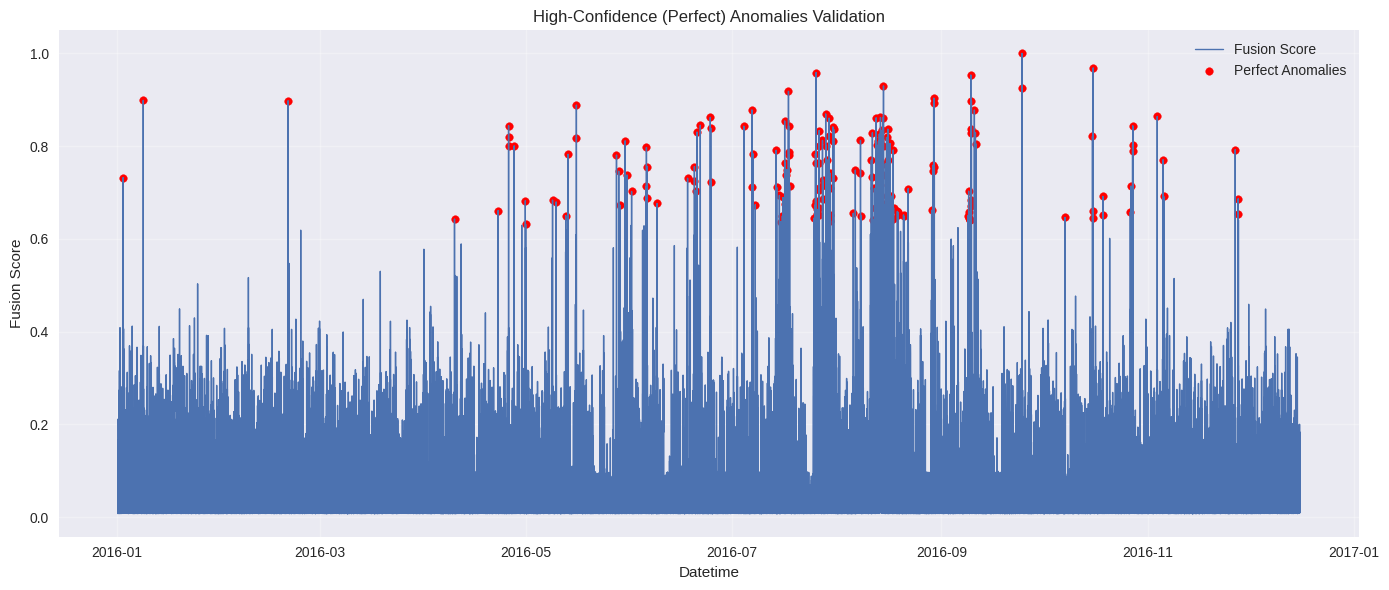


✅ Extended validation completed successfully.
✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'

Top 10 High-Confidence Anomalies:

           datetime  fusion_score  confidence_score   resid_z  stability_ratio                                                                                             temporal_explanation
2016-09-24 20:22:58      1.000000          1.000000 24.430318              1.0                Anomaly occurred around the usual time on a Saturday in Week 38, within typical 19:00–22:00 peak.
2016-10-15 22:04:58      0.968712          0.964360 21.982121              1.0        Anomaly occurred 25 minutes earlier than usual on a Saturday in Week 41, within typical 19:00–22:00 peak.
2016-09-09 16:39:58      0.953391          0.958911 22.278243              1.0                  Anomaly occurred around the usual time on a Friday in Week 36, within typical 16:00–22:00 peak.
2016-07-25 21:45:58      0.958564          0.952187 21.

In [ ]:
# ============================================================
# EXTENDED VALIDATION, STABILITY & TEMPORAL EXPLAINABILITY (SAFE VERSION)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import os, json
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# STEP 1: LOAD FUSION RESULTS
# ============================================================
fusion_path = "hybrid_fusion_final/fusion_final_results.csv"
assert os.path.exists(fusion_path), f"Fusion results file not found: {fusion_path}"

fusion_df = pd.read_csv(fusion_path)

# Validate datetime
assert "datetime" in fusion_df.columns, "datetime column required in fusion_final_results.csv"
fusion_df["datetime"] = pd.to_datetime(fusion_df["datetime"], errors="coerce")
fusion_df.dropna(subset=["datetime"], inplace=True)
fusion_df.sort_values("datetime", inplace=True)
fusion_df.reset_index(drop=True, inplace=True)

# Validate essential columns
required_cols = {"fusion_label", "fusion_score", "AbsResidual"}
missing = required_cols - set(fusion_df.columns)
assert not missing, f"Missing required columns in fusion_final_results.csv: {missing}"

print(f"Loaded fusion results: {len(fusion_df)} samples, {fusion_df['fusion_label'].sum()} anomalies detected")

# ============================================================
# STEP 2: RESIDUAL SIGNIFICANCE (Z-SCORE)
# ============================================================
fusion_df["resid_z"] = np.abs(zscore(fusion_df["AbsResidual"].fillna(0)))
fusion_df["significance"] = (fusion_df["resid_z"] > 3).astype(int)

# ============================================================
# STEP 3: STABILITY ANALYSIS (THRESHOLD SENSITIVITY)
# ============================================================
mad = np.median(np.abs(fusion_df["fusion_score"] - np.median(fusion_df["fusion_score"])))
if mad == 0 or np.isnan(mad):
    mad = np.std(fusion_df["fusion_score"]) / 1.4826  # fallback robust estimate

thresholds = [np.median(fusion_df["fusion_score"]) + k * mad for k in [2.5, 3.0, 3.5]]
fusion_df["stability_flags"] = 0
for t in thresholds:
    fusion_df["stability_flags"] += (fusion_df["fusion_score"] > t).astype(int)
fusion_df["stability_ratio"] = fusion_df["stability_flags"] / len(thresholds)

# ============================================================
# STEP 4: FEATURE-LEVEL CONSISTENCY (PROXY)
# ============================================================
grad = np.gradient(fusion_df["AbsResidual"].fillna(method="ffill"))
fusion_df["feature_strength"] = np.exp(-grad ** 2)
fusion_df["feature_strength"] = MinMaxScaler().fit_transform(fusion_df[["feature_strength"]])

# ============================================================
# STEP 5: CONFIDENCE SCORE
# ============================================================
fusion_df["confidence_score"] = (
    0.5 * fusion_df["fusion_score"] +
    0.2 * (fusion_df["resid_z"] / (fusion_df["resid_z"].max() + 1e-8)) +
    0.2 * fusion_df["stability_ratio"] +
    0.1 * fusion_df["feature_strength"]
)
fusion_df["confidence_score"] = MinMaxScaler().fit_transform(fusion_df[["confidence_score"]])

confidence_threshold = 0.7
fusion_df["perfect_anomaly"] = (fusion_df["confidence_score"] >= confidence_threshold).astype(int)

num_anomalies = int(fusion_df["fusion_label"].sum())
num_perfect = int(fusion_df["perfect_anomaly"].sum())

print("\n========== VALIDATION SUMMARY ==========")
print(f"Total detected anomalies (fusion): {num_anomalies}")
print(f"High-confidence (perfect) anomalies: {num_perfect}")
print(f"Average confidence score: {fusion_df['confidence_score'].mean():.3f}")
print("=========================================")

# ============================================================
# STEP 6: TEMPORAL CONTEXTUAL EXPLANATION
# ============================================================
fusion_df["hour"] = fusion_df["datetime"].dt.hour
fusion_df["minute"] = fusion_df["datetime"].dt.minute
fusion_df["weekday"] = fusion_df["datetime"].dt.day_name()
fusion_df["week"] = fusion_df["datetime"].dt.isocalendar().week

# Hourly baseline by weekday
hourly_baseline = (
    fusion_df.groupby(["weekday", "hour"])["AbsResidual"]
    .mean()
    .unstack(fill_value=0)
)

# Identify top residual peak windows per weekday
peak_windows = {}
for wd, s in hourly_baseline.iterrows():
    if s.sum() == 0:
        peak_windows[wd] = (None, None)
    else:
        top_hours = s.nlargest(3).index
        peak_windows[wd] = (int(min(top_hours)), int(max(top_hours)))

mean_minute_per_hour = fusion_df.groupby("hour")["minute"].mean().to_dict()

def temporal_explanation(row):
    hr, mn, wd, wk = row["hour"], row["minute"], row["weekday"], row["week"]
    mean_min = mean_minute_per_hour.get(hr, 0)
    mn_shift = int(mn - mean_min)
    if mn_shift < -10:
        minute_phrase = f"{abs(mn_shift)} minutes earlier than usual"
    elif mn_shift > 10:
        minute_phrase = f"{mn_shift} minutes later than usual"
    else:
        minute_phrase = "around the usual time"

    low, high = peak_windows.get(wd, (None, None))
    if low is None:
        peak_phrase = "during a low-activity period"
    elif hr < low:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (earlier)"
    elif hr > high:
        peak_phrase = f"outside typical {low:02d}:00–{high:02d}:00 peak (later)"
    else:
        peak_phrase = f"within typical {low:02d}:00–{high:02d}:00 peak"

    return f"Anomaly occurred {minute_phrase} on a {wd} in Week {wk}, {peak_phrase}."

fusion_df["temporal_explanation"] = fusion_df.apply(temporal_explanation, axis=1)

# ============================================================
# STEP 7: VISUALIZATION
# ============================================================
plt.figure(figsize=(14, 6))
plt.plot(fusion_df["datetime"], fusion_df["fusion_score"], label="Fusion Score", linewidth=1)
plt.scatter(
    fusion_df["datetime"][fusion_df["perfect_anomaly"] == 1],
    fusion_df["fusion_score"][fusion_df["perfect_anomaly"] == 1],
    color="red", s=30, label="Perfect Anomalies"
)
plt.title("High-Confidence (Perfect) Anomalies Validation")
plt.xlabel("Datetime")
plt.ylabel("Fusion Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# STEP 8: SAVE RESULTS
# ============================================================
os.makedirs("hybrid_fusion_final_validated", exist_ok=True)
fusion_df.to_csv("hybrid_fusion_final_validated/fusion_validated_results.csv", index=False)

meta_extended = {
    "Detected_Anomalies": num_anomalies,
    "Perfect_Anomalies": num_perfect,
    "Confidence_Threshold": confidence_threshold,
    "TemporalExplainability": True
}
with open("hybrid_fusion_final_validated/fusion_validated_meta.json", "w") as f:
    json.dump(meta_extended, f, indent=4)

print("\n✅ Extended validation completed successfully.")
print("✅ Temporal explainability and confidence evaluation saved in 'hybrid_fusion_final_validated/'")

# ============================================================
# STEP 9: DISPLAY TOP PERFECT ANOMALIES
# ============================================================
top10 = fusion_df[fusion_df["perfect_anomaly"] == 1].nlargest(10, "confidence_score")[
    ["datetime", "fusion_score", "confidence_score", "resid_z", "stability_ratio", "temporal_explanation"]
]

print("\nTop 10 High-Confidence Anomalies:\n")
print(top10.to_string(index=False))


In [ ]:
print(fusion_df.columns)

Index(['datetime', 'AbsResidual', 's_ma', 's_if', 's_ocsvm', 'fusion_score',
       'fusion_label', 'resid_z', 'significance', 'stability_flags',
       'stability_ratio', 'feature_strength', 'confidence_score',
       'perfect_anomaly', 'hour', 'minute', 'weekday', 'week',
       'temporal_explanation'],
      dtype='object')


In [ ]:
import pandas as pd

# Example reconstruction (customize column list to your dataset)
df_rf = pd.read_csv("rf_residuals.csv")
feature_cols = [c for c in df_rf.columns if c not in ["datetime", "Actual_RF", "Predicted_RF"]]
X_num = df_rf[feature_cols]

X_num.to_csv("X_numeric_features.csv", index=False)
print("✅ Extracted and saved X_num from RF residual file.")


✅ Extracted and saved X_num from RF residual file.


In [ ]:
import pandas as pd
df = pd.read_csv("X_numeric_features.csv")
print(df.shape)
print(df.head())


(151105, 4)
     Actual  Predicted  Residual  AbsResidual
0  2.825698   1.839835  0.985863     0.985863
1 -0.692507  -0.731224  0.038717     0.038717
2  0.196970   0.248739 -0.051769     0.051769
3 -0.616679  -0.545777 -0.070902     0.070902
4 -0.408550  -0.339805 -0.068745     0.068745


In [ ]:
# ============================================================
# EXPLAINABLE AI: ROOT-CAUSE + CONTEXT-AWARE TEMPORAL EXPLAINABILITY (CATE)
# ============================================================

import os, json, warnings
import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ============================================================
# STEP 1: LOAD REQUIRED DATA AND MODELS
# ============================================================
print("\nLoading models and data...")

# Expected: X_num, fusion_df (already in environment)
rf = joblib.load("random_forest_full_model.pkl")

# Standardize features
scaler = StandardScaler().fit(X_num)
feature_cols = list(X_num.columns)

# Load LSTM residuals for surrogate training
lstm_residuals_df = pd.read_csv("lstm_final_results/lstm_residuals.csv")
lstm_residuals = lstm_residuals_df["Residual"].values

# ============================================================
# STEP 2: TRAIN OR LOAD SURROGATE RF ON LSTM RESIDUALS
# ============================================================
surrogate_path = "surrogate_rf_lstm_resid.joblib"
if os.path.exists(surrogate_path):
    surrogate = joblib.load(surrogate_path)
    print("✅ Loaded existing surrogate model.")
else:
    print("\nTraining surrogate Random Forest on LSTM residuals...")
    X_surrogate = X_num.iloc[-len(lstm_residuals):, :].values
    X_surrogate_scaled = scaler.transform(X_surrogate)
    surrogate = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
    surrogate.fit(X_surrogate_scaled, lstm_residuals)
    joblib.dump(surrogate, surrogate_path)
    print("✅ Surrogate model trained and saved as 'surrogate_rf_lstm_resid.joblib'")

# ============================================================
# STEP 3: BUILD TREE SHAP EXPLAINERS
# ============================================================
print("\nBuilding TreeSHAP explainers...")
explainer_rf = shap.TreeExplainer(rf)
explainer_sur = shap.TreeExplainer(surrogate)

# ============================================================
# STEP 4: COMPUTE SHAP VALUES & RANK ROOT CAUSES
# ============================================================
print("\nComputing SHAP explanations for perfect anomalies...")

resid_series = pd.Series(fusion_df["AbsResidual"], index=fusion_df.index)
alpha = 0.8
reports = []
perfect_indices = fusion_df[fusion_df["perfect_anomaly"] == 1].index
baselines = X_num.rolling(window=48, min_periods=1).mean().fillna(method="bfill")

for idx in tqdm(perfect_indices, desc="Explaining anomalies"):
    X_row = X_num.loc[idx, feature_cols].values.reshape(1, -1)
    X_scaled = scaler.transform(X_row)

    shap_vals_rf = explainer_rf.shap_values(X_scaled)
    if isinstance(shap_vals_rf, list): shap_vals_rf = shap_vals_rf[0]
    shap_vals_sur = explainer_sur.shap_values(X_scaled)
    if isinstance(shap_vals_sur, list): shap_vals_sur = shap_vals_sur[0]

    shap_vals_rf = np.array(shap_vals_rf).flatten()
    shap_vals_sur = np.array(shap_vals_sur).flatten()
    baseline_vals = baselines.loc[idx, feature_cols].values
    delta = (X_row.flatten() - baseline_vals).astype(float)

    df_shap = pd.DataFrame({
        "feature": feature_cols,
        "shap_rf": shap_vals_rf,
        "shap_sur": shap_vals_sur,
        "delta": delta
    })
    df_shap["score_rf"] = np.abs(df_shap["shap_rf"]) * np.abs(df_shap["delta"])
    df_shap["score_sur"] = np.abs(df_shap["shap_sur"]) * np.abs(df_shap["delta"])
    df_shap["combined_score"] = df_shap["score_rf"] + alpha * df_shap["score_sur"]

    df_top = df_shap.sort_values("combined_score", ascending=False).head(5)

    report = {
        "index": int(idx),
        "datetime": str(fusion_df.loc[idx, "datetime"]) if "datetime" in fusion_df.columns else str(idx),
        "residual": float(resid_series.loc[idx]),
        "top_causes": df_top[["feature", "combined_score", "shap_rf", "shap_sur", "delta"]].to_dict(orient="records")
    }
    reports.append(report)

# ============================================================
# STEP 5C: CONTEXT-AWARE TEMPORAL EXPLAINABILITY (CATE)
# ============================================================
import calendar

if "datetime" not in fusion_df.columns:
    raise ValueError("datetime column required for contextual temporal explainability")

ts = pd.to_datetime(fusion_df["datetime"], errors="coerce")
fusion_df["hour"] = ts.dt.hour
fusion_df["minute"] = ts.dt.minute
fusion_df["weekday"] = ts.dt.day_name()
fusion_df["week"] = ts.dt.isocalendar().week.astype(int)
fusion_df["month"] = ts.dt.month_name()

# --- Learn baseline rhythms ---
hourly_baseline = fusion_df.groupby(["weekday", "hour"])["AbsResidual"].mean().unstack().fillna(0)
peak_windows = {}
for wd in hourly_baseline.index:
    s = hourly_baseline.loc[wd]
    top_hours = s.nlargest(3).index.tolist()
    peak_windows[wd] = (min(top_hours), max(top_hours))

baseline_time = fusion_df.groupby("weekday")["hour"].mean().to_dict()
baseline_minute = fusion_df.groupby("hour")["minute"].mean().to_dict()

def interpret_time_relation(hour, weekday):
    if weekday not in peak_windows:
        return "in an undefined period"
    low, high = peak_windows[weekday]
    if hour < low:
        return f"outside typical {low:02d}:00–{high:02d}:00 peak (earlier than usual)"
    elif hour > high:
        return f"outside typical {low:02d}:00–{high:02d}:00 peak (later than usual)"
    else:
        return f"within normal {low:02d}:00–{high:02d}:00 high-usage window"

def contextual_temporal_sentence(idx):
    """Create natural language temporal explanation."""
    hr = int(fusion_df.loc[idx, "hour"])
    mn = int(fusion_df.loc[idx, "minute"])
    wd = fusion_df.loc[idx, "weekday"]
    wk = int(fusion_df.loc[idx, "week"])
    mo = fusion_df.loc[idx, "month"]

    mean_min = baseline_minute.get(hr, np.nan)
    mn_shift = mn - mean_min if not np.isnan(mean_min) else 0

    if mn_shift < -10:
        minute_phrase = f"{abs(int(mn_shift))} minutes earlier than usual"
    elif mn_shift > 10:
        minute_phrase = f"{abs(int(mn_shift))} minutes later than usual"
    else:
        minute_phrase = "around the usual time"

    if hr < 6:
        period = "early morning"
    elif hr < 12:
        period = "morning"
    elif hr < 17:
        period = "afternoon"
    elif hr < 21:
        period = "evening"
    else:
        period = "night"

    peak_context = interpret_time_relation(hr, wd)
    return (f"Anomaly occurred {minute_phrase} on a {wd} {period} in Week {wk}, "
            f"during {mo}, {peak_context}.")

def make_text_report(report):
    lines = []
    dt = fusion_df.loc[report["index"], "datetime"]
    lines.append(f"Anomaly at {dt}: residual = {report['residual']:.3f}")
    lines.append(contextual_temporal_sentence(report["index"]))
    lines.append("Top contributing factors:")
    for r in report["top_causes"]:
        feat = r["feature"]
        delta = r["delta"]
        if feat in ["minute", "hour", "weekday", "month"]:
            continue
        lines.append(f" • {feat}: changed by {delta:+.4f}, strongly influencing deviation.")
    return "\n".join(lines)

print("\n================= CONTEXT-AWARE TEMPORAL REPORTS =================")
for rep in reports[:3]:
    print(make_text_report(rep))
    print("------------------------------------------------------------------")

# ============================================================
# STEP 6: SAVE EXPLANATION REPORTS
# ============================================================
os.makedirs("explainability_reports", exist_ok=True)
with open("explainability_reports/root_cause_reports.json", "w") as f:
    json.dump(reports, f, indent=4)
hourly_baseline.to_csv("explainability_reports/hourly_baseline_matrix.csv")
with open("explainability_reports/peak_windows.json", "w") as f:
    json.dump({k: [int(v[0]), int(v[1])] for k,v in peak_windows.items()}, f, indent=2)

print(f"\n✅ Root-cause analysis + temporal context completed for {len(reports)} anomalies")
print("✅ Reports & time-baselines saved to 'explainability_reports/'")

# ============================================================
# STEP 7: SHAP DIAGRAMS (GLOBAL + WATERFALL)
# ============================================================
print("\nGenerating SHAP diagrams...")
os.makedirs("explainability_reports/plots", exist_ok=True)

sample_size = min(5000, len(X_num))
X_sample = X_num.sample(sample_size, random_state=42)
X_scaled_sample = scaler.transform(X_sample)

shap_values_rf = explainer_rf.shap_values(X_scaled_sample)
if isinstance(shap_values_rf, list): shap_values_rf = shap_values_rf[0]

# Summary plot
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values_rf, X_sample, feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot – Random Forest")
plt.tight_layout()
plt.savefig("explainability_reports/plots/shap_summary_rf.png", dpi=300)
plt.close()

# Bar plot
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar",
                  feature_names=feature_cols, show=False)
plt.title("Mean |SHAP| Feature Importance – Random Forest")
plt.tight_layout()
plt.savefig("explainability_reports/plots/shap_bar_rf.png", dpi=300)
plt.close()

# Waterfall (for first anomaly)
first_idx = int(perfect_indices[0])
X_row = X_num.loc[first_idx, feature_cols].values.reshape(1, -1)
shap_vals_single = explainer_rf(X_row)
shap.plots.waterfall(shap_vals_single[0], max_display=10, show=False)
plt.title(f"Waterfall Plot – Anomaly index {first_idx}")
plt.tight_layout()
plt.savefig(f"explainability_reports/plots/waterfall_anomaly_{first_idx}.png", dpi=300)
plt.close()

print("✅ SHAP diagrams saved in 'explainability_reports/plots/' folder.")



Loading models and data...
Loaded 151101 fusion rows and 151105 feature rows.
✅ Loaded existing surrogate RF model.

Building TreeSHAP explainers...


TypeError: TreeExplainer.__init__() got an unexpected keyword argument 'check_additivity'